In [1]:
%pylab inline
import jax
import jax.numpy as jnp

Populating the interactive namespace from numpy and matplotlib


Data and VAE prepraretion

In [2]:
# Let's start with the imports
import haiku as hk     # NN library
import optax           # Optimizer library
import pickle

# Utility function for tensoboard
from flax.metrics import tensorboard

# TensorFlow probability
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

# Specific models built by EiffL
from quarks2cosmos.models.vae import Decoder
from quarks2cosmos.models.flow import AffineFlow

In [3]:
rng_seq = hk.PRNGSequence(42)
from jax import random

In [4]:
import pickle
with open('models/resvae2/model-195000.pckl', 'rb') as file:
    params, state, _ = pickle.load(file)
with open('models/flowResnet2/model-95000.pckl', 'rb') as file:
    params_flow, _ = pickle.load(file)    
    
params = hk.data_structures.merge(params, params_flow)
params_1 = hk.data_structures.merge(params, params_flow)


In [5]:
def generative_model_fn(z):
    # Transform from Gaussian space to VAE latent space
    z1 = AffineFlow()().bijector.forward(z)
    
    # Decode sample with decoder
    likelihood = Decoder()(z1, is_training=False)
    
    return likelihood.mean()

generative_model = hk.without_apply_rng(hk.transform_with_state(generative_model_fn))


In [6]:
import quarks2cosmos.datasets
import tensorflow_datasets as tfds
from quarks2cosmos import galjax as gj

In [7]:
dset_cosmos = tfds.load("Cosmos/23.5", split=tfds.Split.TRAIN) # Load the TRAIN split
dset_cosmos = dset_cosmos.as_numpy_iterator()                  # Convert the dataset to numpy iterator

dset_hsc = tfds.load("HSC", split=tfds.Split.TRAIN)
dset_hsc = dset_hsc.as_numpy_iterator()

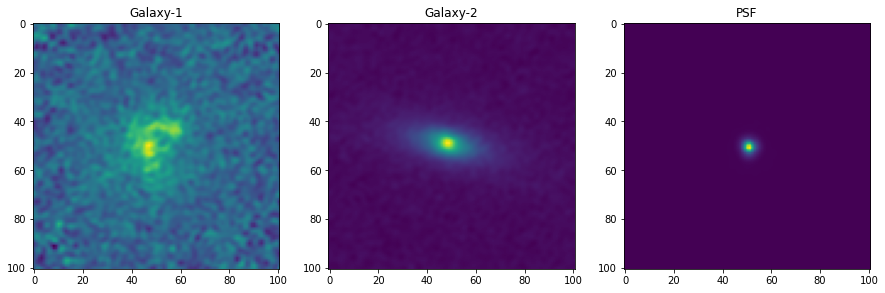

In [18]:
# Extract a new example from the dataset
cosmos1 = next(dset_cosmos)
cosmos2 = next(dset_cosmos)

figure(figsize=[15,5])
subplot(131)
imshow(cosmos1['image'])
title('Galaxy-1')
subplot(132)
imshow(cosmos2['image'])
title('Galaxy-2')
subplot(133)
imshow(cosmos1['psf'])
title('PSF');

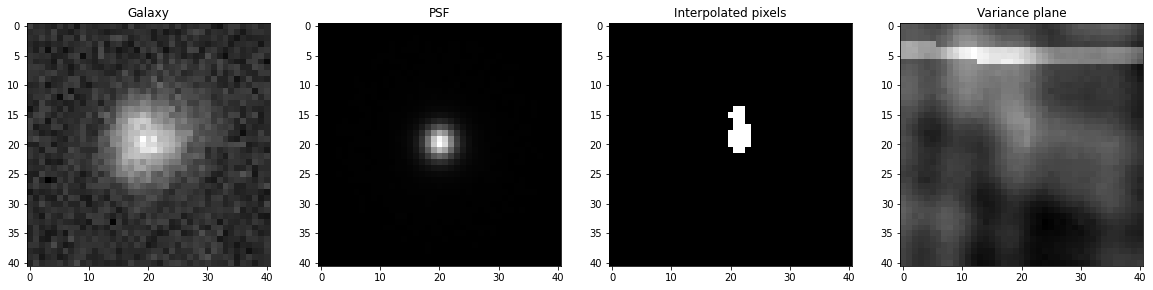

In [19]:
# Extract a new example from the dataset
hsc = next(dset_hsc)

figure(figsize=[20,5])
subplot(141)
imshow(hsc['image'],cmap='gray')
title('Galaxy')
subplot(142)
imshow(hsc['psf'],cmap='gray')
title('PSF')
subplot(143)
imshow(hsc['mask'] == 44,cmap='gray')
title('Interpolated pixels')
subplot(144)
imshow(hsc['variance'],cmap='gray')
title('Variance plane');

In [20]:
@jax.jit
def simulate_hsc(x, in_psf, out_psf):
    """ This function will simulate an image at HSC resolution given an image at HST resolution,
    accounting for input PSF and convolving by output PSF
    Args:
        x: HST resolution image (MUST BE ODD SIZE!!!!)
        in_psf: HST PSF
        out_psf: HSC PSF
    Returns:
        y: HSC simulated image of size [41,41]
    """
    y = gj.deconvolve(x, in_psf)         # Deconvolve by input PSF
    y = gj.kresample(y, 0.03, 0.168, 41) # Resample image to HSC grid
    y = gj.convolve(y,  out_psf)         # Reconvolve by HSC PSF
    return 2.587*y                       # Conversion factor for the flux

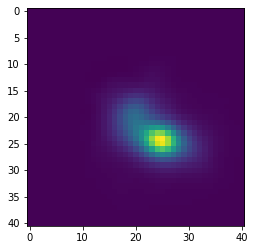

In [21]:
import matplotlib.pyplot as plt
@jax.jit
def blendingHSC(x1,x2):
    im_hsc1 = simulate_hsc(x1, cosmos1['psf'], hsc['psf'])
    im_hsc2 = simulate_hsc(x2, cosmos2['psf'], hsc['psf'])
    im_hsc2 = jnp.roll(jnp.roll(im_hsc2, 5, axis=1), 5, axis=0)
    im_blended = im_hsc1 + im_hsc2
    likelihood = tfd.Independent(tfd.Normal(loc=im_blended,
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) 
    return likelihood.mean()

blended=blendingHSC(cosmos1['image'],cosmos2['image'])
plt.imshow(blended)

In [22]:
likelihood = tfd.Independent(tfd.Normal(loc=blended,
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2)

In [23]:
im_noise = likelihood.sample(seed=jax.random.PRNGKey(1))
x1_true = cosmos1['image']
x2_true = cosmos2['image']
cr_mask = 1.*(hsc['mask'] == 44)
y_obs = im_noise * (1 - cr_mask)

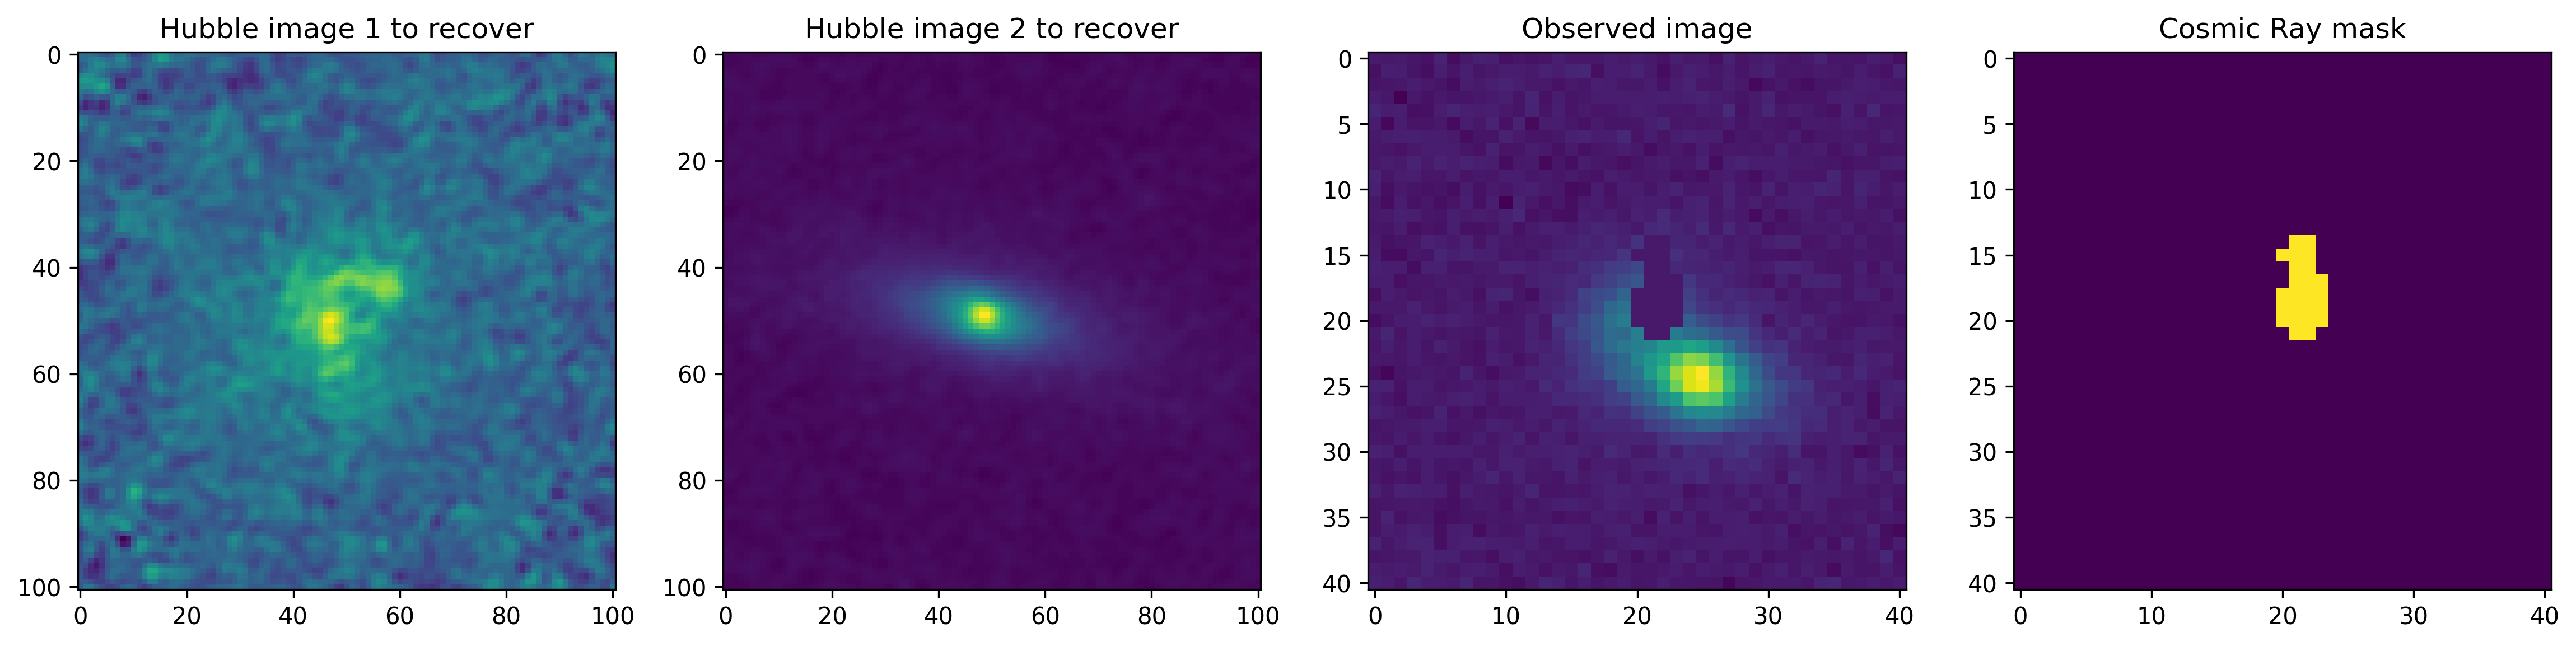

In [69]:
figure(figsize=[19,5])
subplot(141)
imshow(x1_true)
title('Hubble image 1 to recover')
subplot(142)
imshow(x2_true)
title('Hubble image 2 to recover')
subplot(143)
imshow(y_obs)
title('Observed image')
subplot(144)
imshow(cr_mask)
title('Cosmic Ray mask');

#### The MAP solution

In [40]:
# our forward model
@jax.jit
def blending(z1, z2):
    im1, _ = generative_model.apply(params, state, z1)
    im2, _ = generative_model.apply(params, state, z2)
    im_hsc1 = simulate_hsc(im1[0], cosmos1['psf'], hsc['psf'])
    im_hsc2 = simulate_hsc(im2[0], cosmos2['psf'], hsc['psf'])
    im_hsc2 = jnp.roll(jnp.roll(im_hsc2, 5, axis=1), 5, axis=0)
    im_blended = im_hsc1 + im_hsc2
    likelihood = tfd.Independent(tfd.Normal(loc=im_blended,
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) 
    return likelihood.mean()

In [41]:
#our posterior probability
@jax.jit
def log_probz(z):
    x=blending(z[0:32],z[32:64])
    prior=tfd.Independent(tfd.Normal(jnp.zeros(64), jnp.zeros(64)+1), # We add a high noise component in mask
                             reinterpreted_batch_ndims=1)
    likelihood = tfd.Independent(tfd.Normal(x,
                                            jnp.sqrt(hsc['variance'] + cr_mask*1e3)), # We add a high noise component in mask
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)+prior.log_prob(z)

In [79]:
# some routines to do the optimization
optimizer = optax.adam(0.002)
z = tfd.MultivariateNormalDiag(jnp.zeros(64), scale_identity_multiplier=1).sample(16, seed=next(rng_seq))[0]
# Create a parameter
#z = jnp.zeros([32,])

opt_state = optimizer.init(z)

In [80]:
@jax.jit
def update(z, opt_state):
    logp, grads = jax.value_and_grad(log_probz)(z)
    updates, opt_state = optimizer.update(-grads, opt_state)
    
    # Apply gradient descent
    z = optax.apply_updates(z, updates)
    
    # Apply proximal constraints
    z = jnp.abs(z)
    
    return logp,z,opt_state

In [81]:
%%time
losses = []

for i in range(10000):
    #print(1)
    logp, z, opt_state = update(z, opt_state)
    losses.append(logp)

CPU times: user 51.6 s, sys: 12.2 s, total: 1min 3s
Wall time: 50.8 s


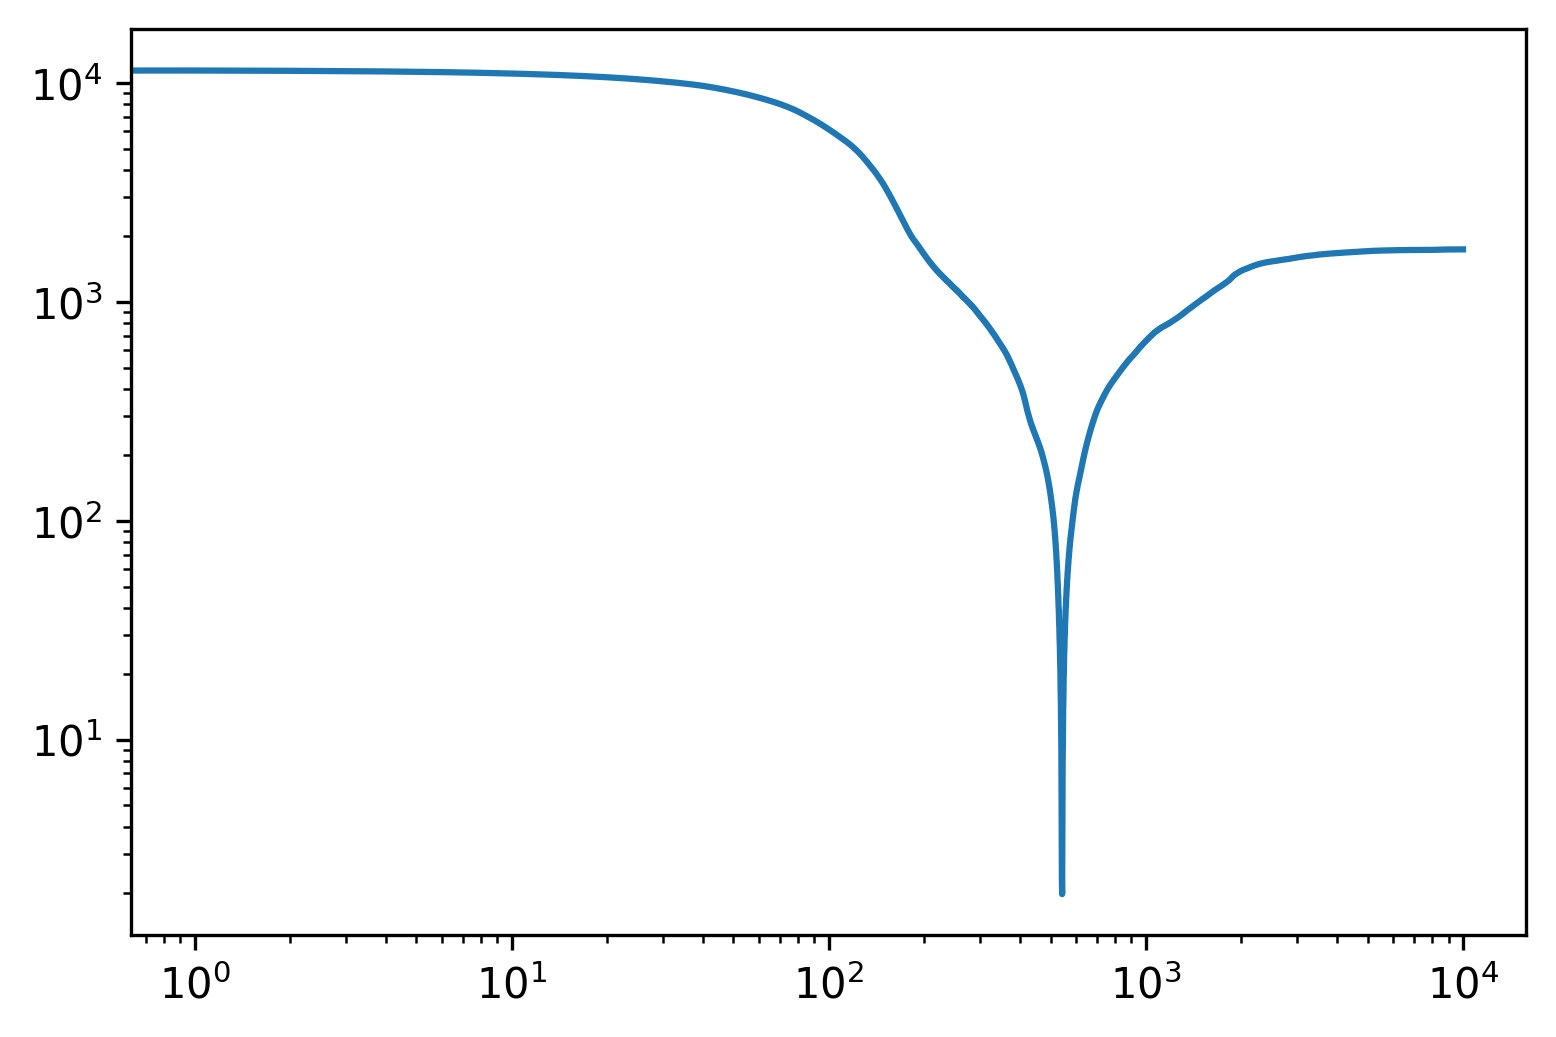

In [82]:
loglog(abs(np.array(losses)))

Text(0.5, 1.0, 'Residuals')

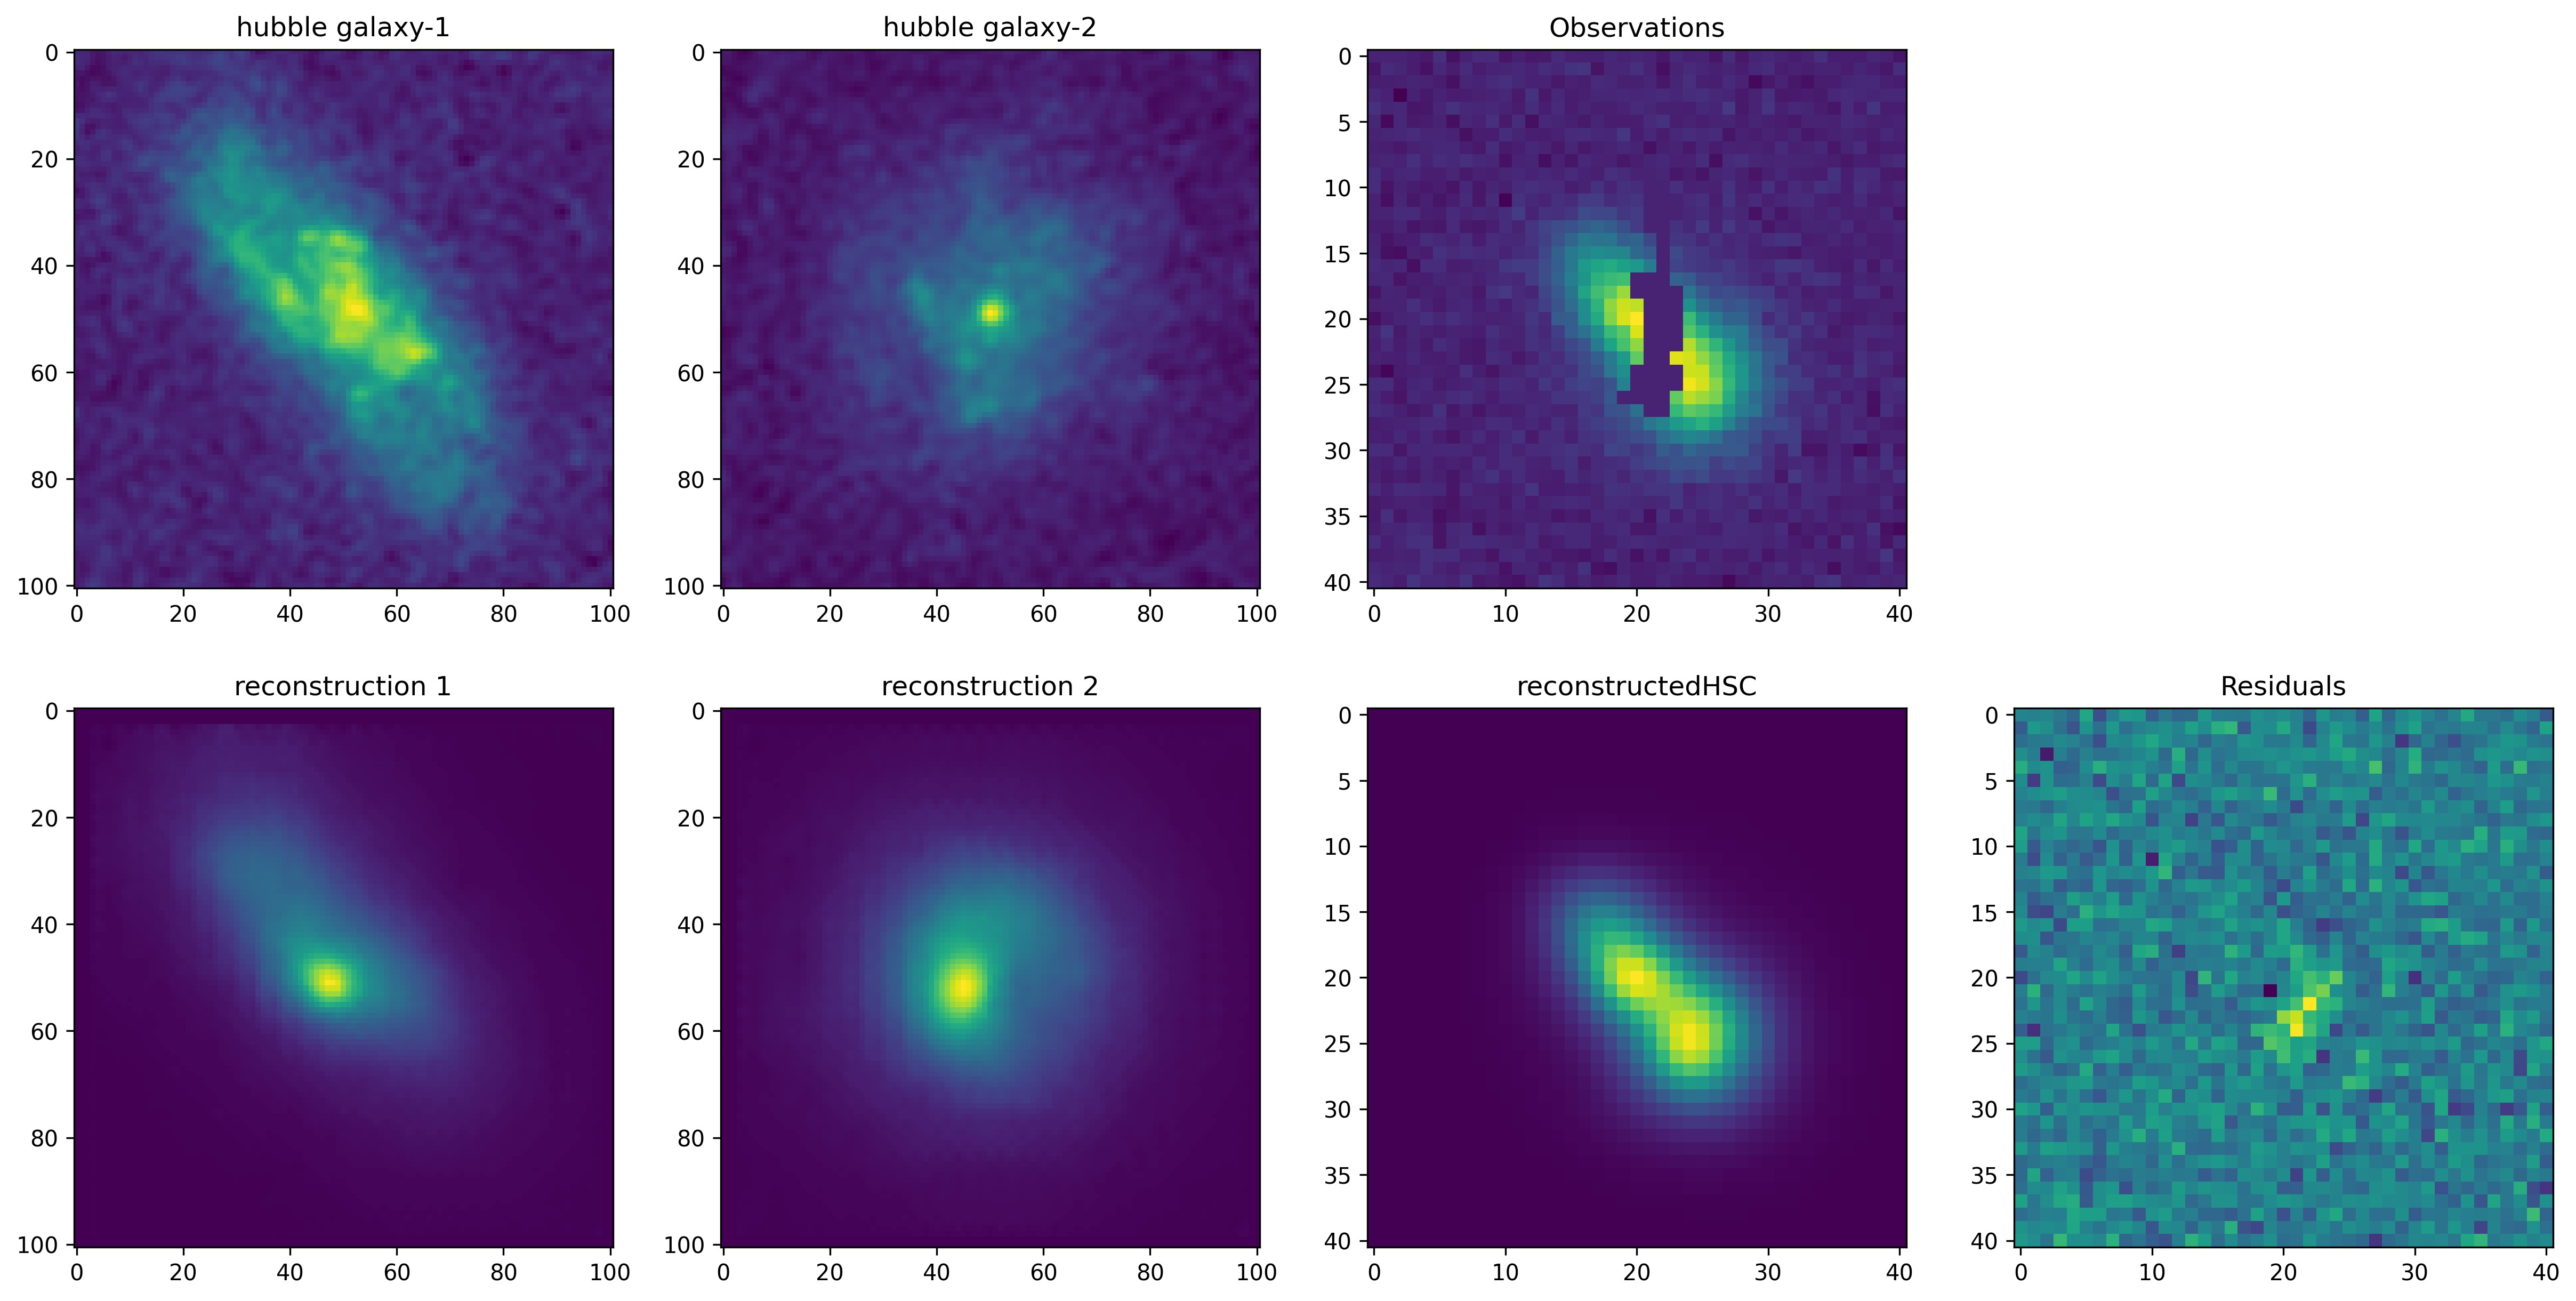

In [83]:
im1, _ = generative_model.apply(params, state, z[0:32])
im2, _ = generative_model.apply(params, state, z[32:64])
plt.rcParams['figure.dpi']=300
figure(figsize=[20,10])
subplot(241)
imshow(x1_true)
title('hubble galaxy-1')
subplot(242)
imshow(x2_true)
title('hubble galaxy-2')
subplot(243)
imshow(y_obs)
title('Observations')
subplot(245)
imshow(im1[0])
title('reconstruction 1')
subplot(246)
imshow(im2[0])
title('reconstruction 2')
subplot(247)
imshow(blending(z[0:32],z[32:64]))
title('reconstructedHSC')
subplot(248)
imshow(im_noise-blending(z[0:32],z[32:64]))
title('Residuals')

Text(0.5, 1.0, 'Residuals')

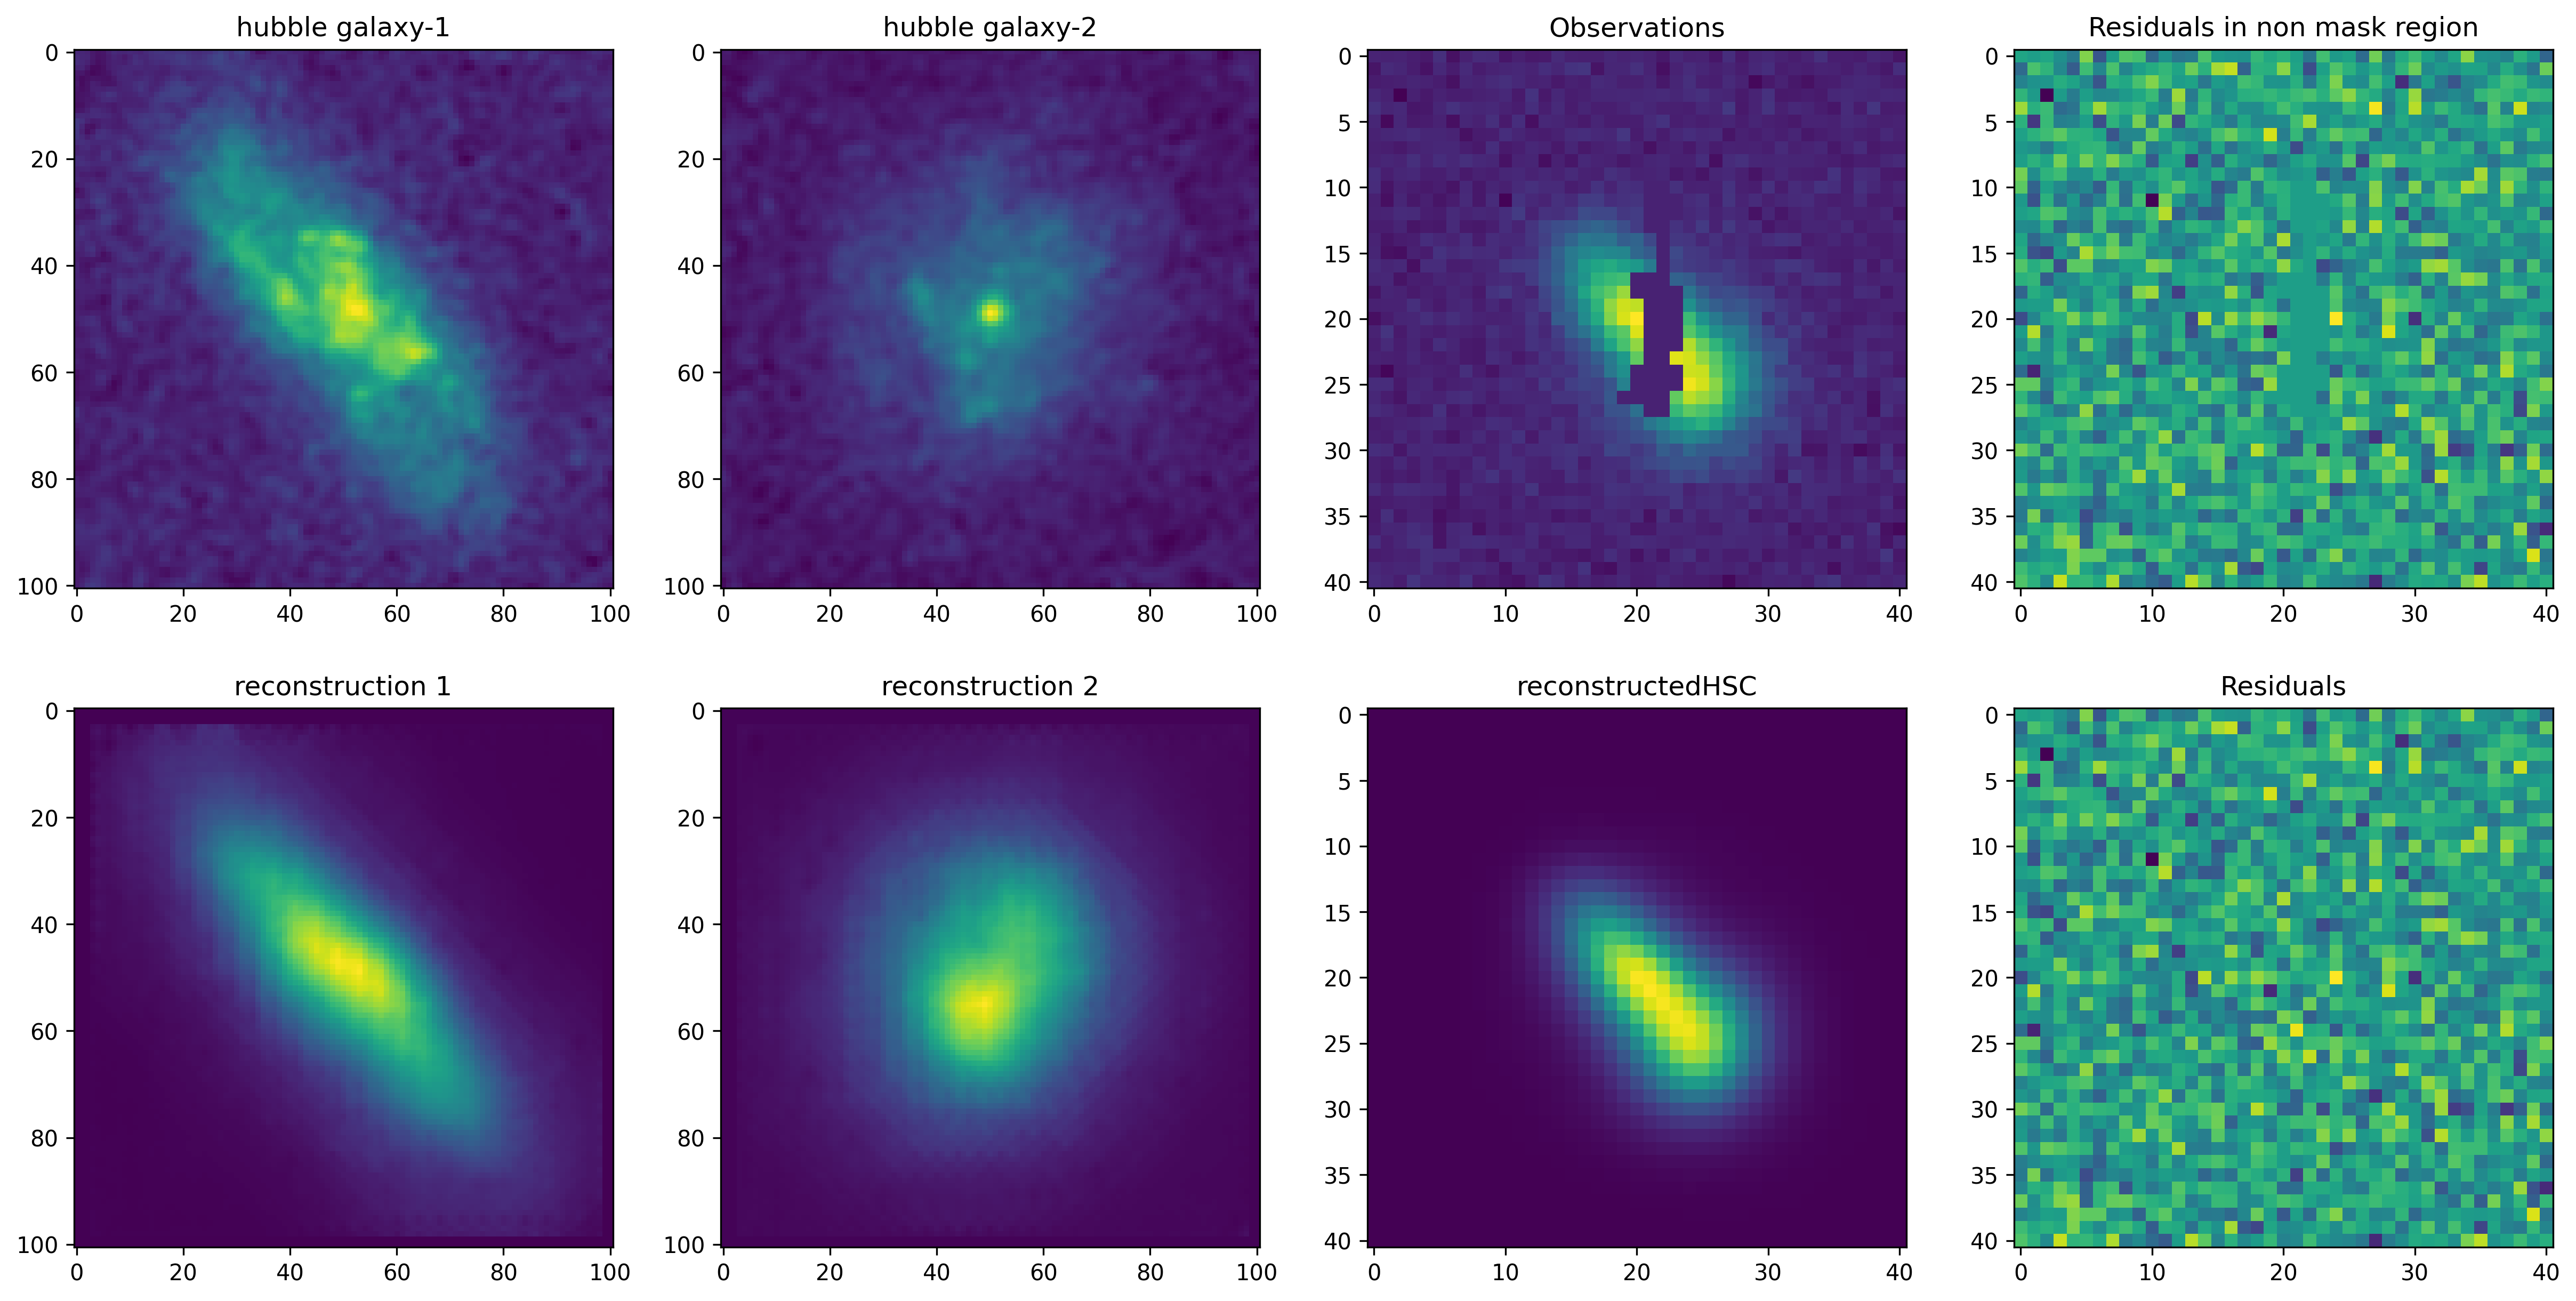

In [77]:
plt.rcParams['figure.dpi']=300
figure(figsize=[20,10])
subplot(241)
imshow(x1_true)
title('hubble galaxy-1')
subplot(242)
imshow(x2_true)
title('hubble galaxy-2')
subplot(243)
imshow(y_obs)
title('Observations')
subplot(245)
imshow(im1[0])
title('reconstruction 1')
subplot(246)
imshow(im2[0])
title('reconstruction 2')
subplot(247)
imshow(blending(z[0:32],z[32:64]))
title('reconstructedHSC')
subplot(244)
imshow((im_noise-blending(z[0:32],z[32:64]))*(1-cr_mask))
title('Residuals in non mask region')
subplot(248)
imshow((im_noise-blending(z[0:32],z[32:64])))
title('Residuals')

In [50]:
# an affine flow converting z to any distribution we want
d = 64
class AffineCoupling_deblend(hk.Module):
  """This is the coupling layer used in the Flow."""
  def __init__(self, scale_only=True, **kwargs):
    super().__init__(**kwargs)
    self.scale_only = scale_only

  def __call__(self, x, output_units, **condition_kwargs):
    net = hk.Linear(128)(x)
    net = jax.nn.leaky_relu(net)
    net = hk.Linear(128)(net)
    net = jax.nn.leaky_relu(net)
    shifter = tfb.Shift(hk.Linear(output_units)(net))
    if self.scale_only:
      return shifter
    else:
      scaler = tfb.Scale(jnp.clip(jax.nn.softplus(hk.Linear(output_units)(net)), 1e-2, 1e1))
      return tfb.Chain([shifter, scaler])
    
class AffineFlow_deblend(hk.Module):
    """This is a normalizing flow using the coupling layers defined
    above."""
    def __call__(self):
        chain = tfb.Chain([
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling_deblend(name='aff1')),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling_deblend(name='aff2')),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling_deblend(name='aff3',
                                                         scale_only=False)),
            tfb.Permute(np.arange(d)[::-1]),
            tfb.RealNVP(d//2, bijector_fn=AffineCoupling_deblend(name='aff4',
                                                         scale_only=False)),
            tfb.Permute(np.arange(d)[::-1]),
        ])
        
        nvp = tfd.TransformedDistribution(
            tfd.MultivariateNormalDiag(jnp.zeros(d),jnp.ones(d)),
            bijector=chain)
        return nvp

In [51]:
def sample_and_logp(N=1):
    flow = AffineFlow_deblend()()
    z = flow.sample(N, seed=hk.next_rng_key())
    log_p = flow.log_prob(z)
    return z, log_p


In [52]:
q_sample_logp = hk.transform(sample_and_logp)

# We initialize the parameters for the variational distribution
q_params = q_sample_logp.init(next(rng_seq), 1)

# And here is our prior distribution
p = tfd.MultivariateNormalDiag(jnp.zeros(64), 
                               scale_identity_multiplier=1.)


/home/dkn16/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


In [53]:
# Let's write a concrete ELBO
@jax.jit
def log_l(x):
    likelihood = tfd.Independent(tfd.Normal(x,
                                           jnp.sqrt(hsc['variance'] + cr_mask*1e3)), # We add a high noise component in mask
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)

@jax.jit
def elbo(params, rng_key):
    
    # Sample from the log posterior
    z, log_q = q_sample_logp.apply(params, rng_key, N=100)
    
    # KL term 
    kl = log_q - p.log_prob(z)
    vmap_batched_blend = jax.vmap(blending)
    x=vmap_batched_blend(z[...,0:32],z[...,32:64])
    
    #y_pred=jnp.zeros((100,101,101))
    #variance=jnp.zeros((100,101,101))
    #y_observe=jnp.zeros((100,101,101))
    vmap_batched_log_joint = jax.vmap(log_l)
    log_likelihood=vmap_batched_log_joint(x)
    
    #likelihood = tfd.Independent(tfd.Normal(y_pred,
                                            #variance), # We add a high noise component in mask
                             #reinterpreted_batch_ndims=2)
    
    # You need to plug your forward model producing a likelihood object here
    #likelihood = # .....
    
    #log_likelihood.log_prob(y_obs)
    
    # Form the ELBO
    elbo = jnp.mean(log_likelihood - kl)
    
    return -elbo

In [54]:
def lr_schedule(step):
  """Linear scaling rule optimized for 90 epochs."""
  steps_per_epoch = 40000 // 64 

  current_epoch = step / steps_per_epoch  # type: float
  boundaries = jnp.array((40, 80, 120)) * steps_per_epoch
  values = jnp.array([1., 0.1, 0.01, 0.001])

  index = jnp.sum(boundaries < step)
  return jnp.take(values, index)

In [55]:
# do the optimization
optimizer = optax.chain(
      optax.adam(1e-3),
      optax.scale_by_schedule(lr_schedule))

opt_state = optimizer.init(q_params)

In [56]:
@jax.jit
def update(params, rng_key, opt_state):
    """Single SGD update step."""
    logp, grads = jax.value_and_grad(elbo)(params, rng_key)
    updates, new_opt_state = optimizer.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return logp, new_params, new_opt_state

In [57]:
%%time
losses=[]
for s in range(10000):
    logp, q_params, opt_state = update(q_params, next(rng_seq), opt_state)
    losses.append(logp)

CPU times: user 4min 28s, sys: 3min 7s, total: 7min 35s
Wall time: 7min 21s


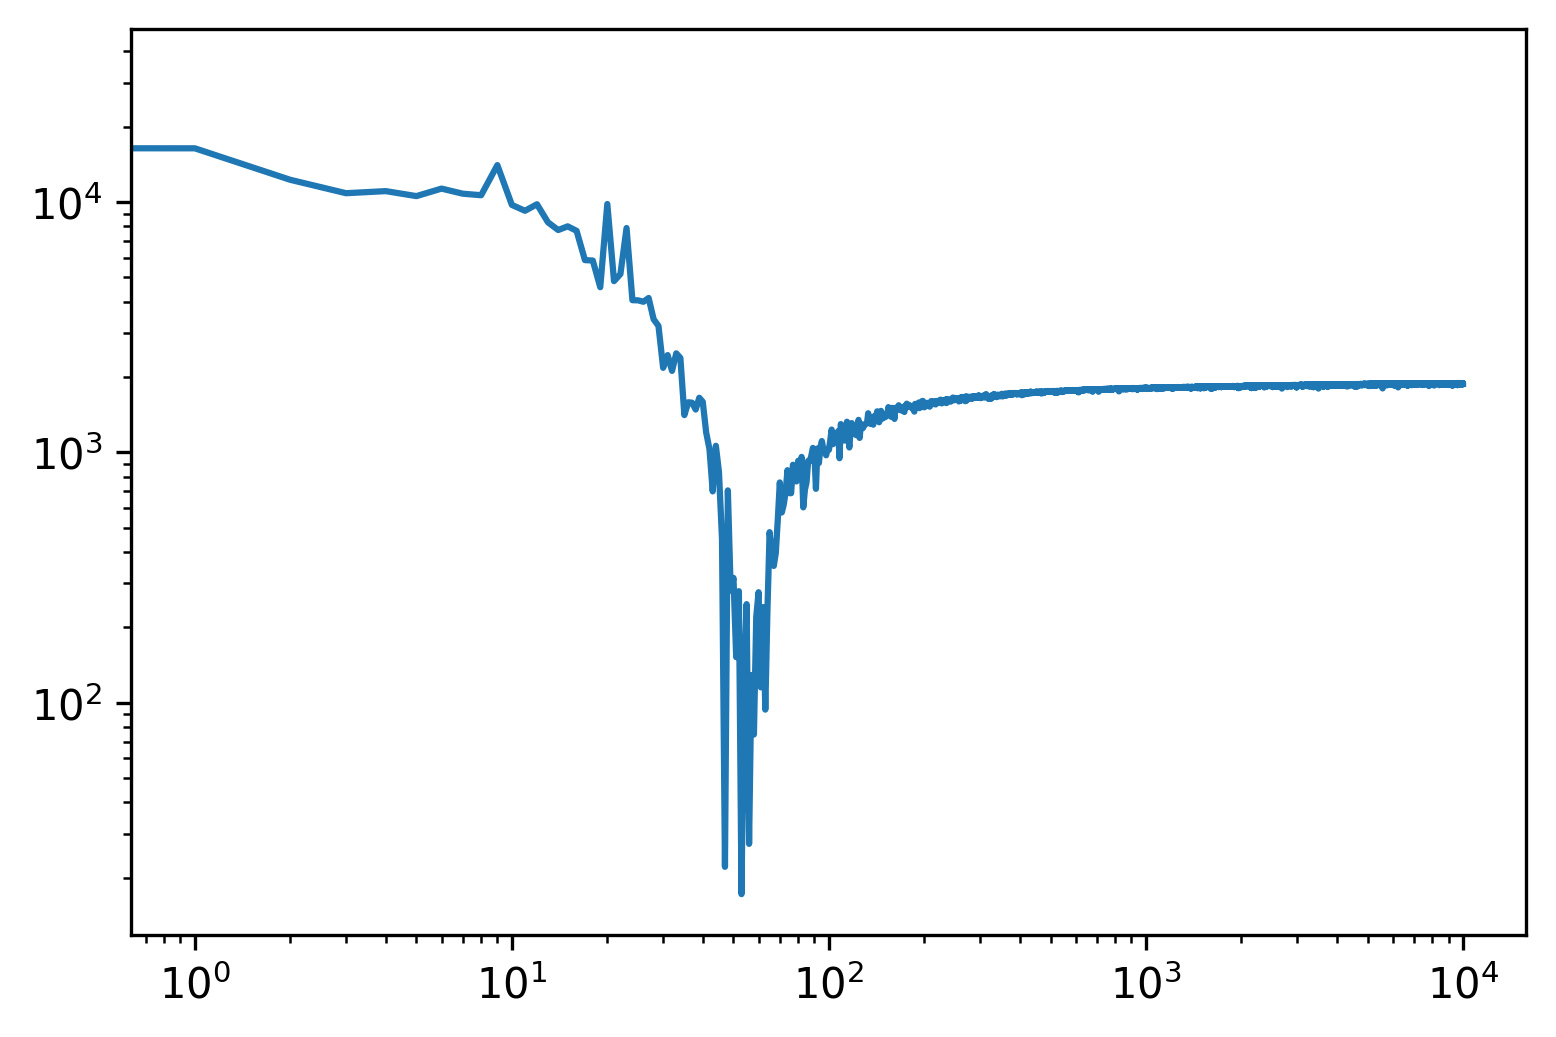

In [58]:
loglog(abs(np.array(losses)))


/home/dkn16/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")


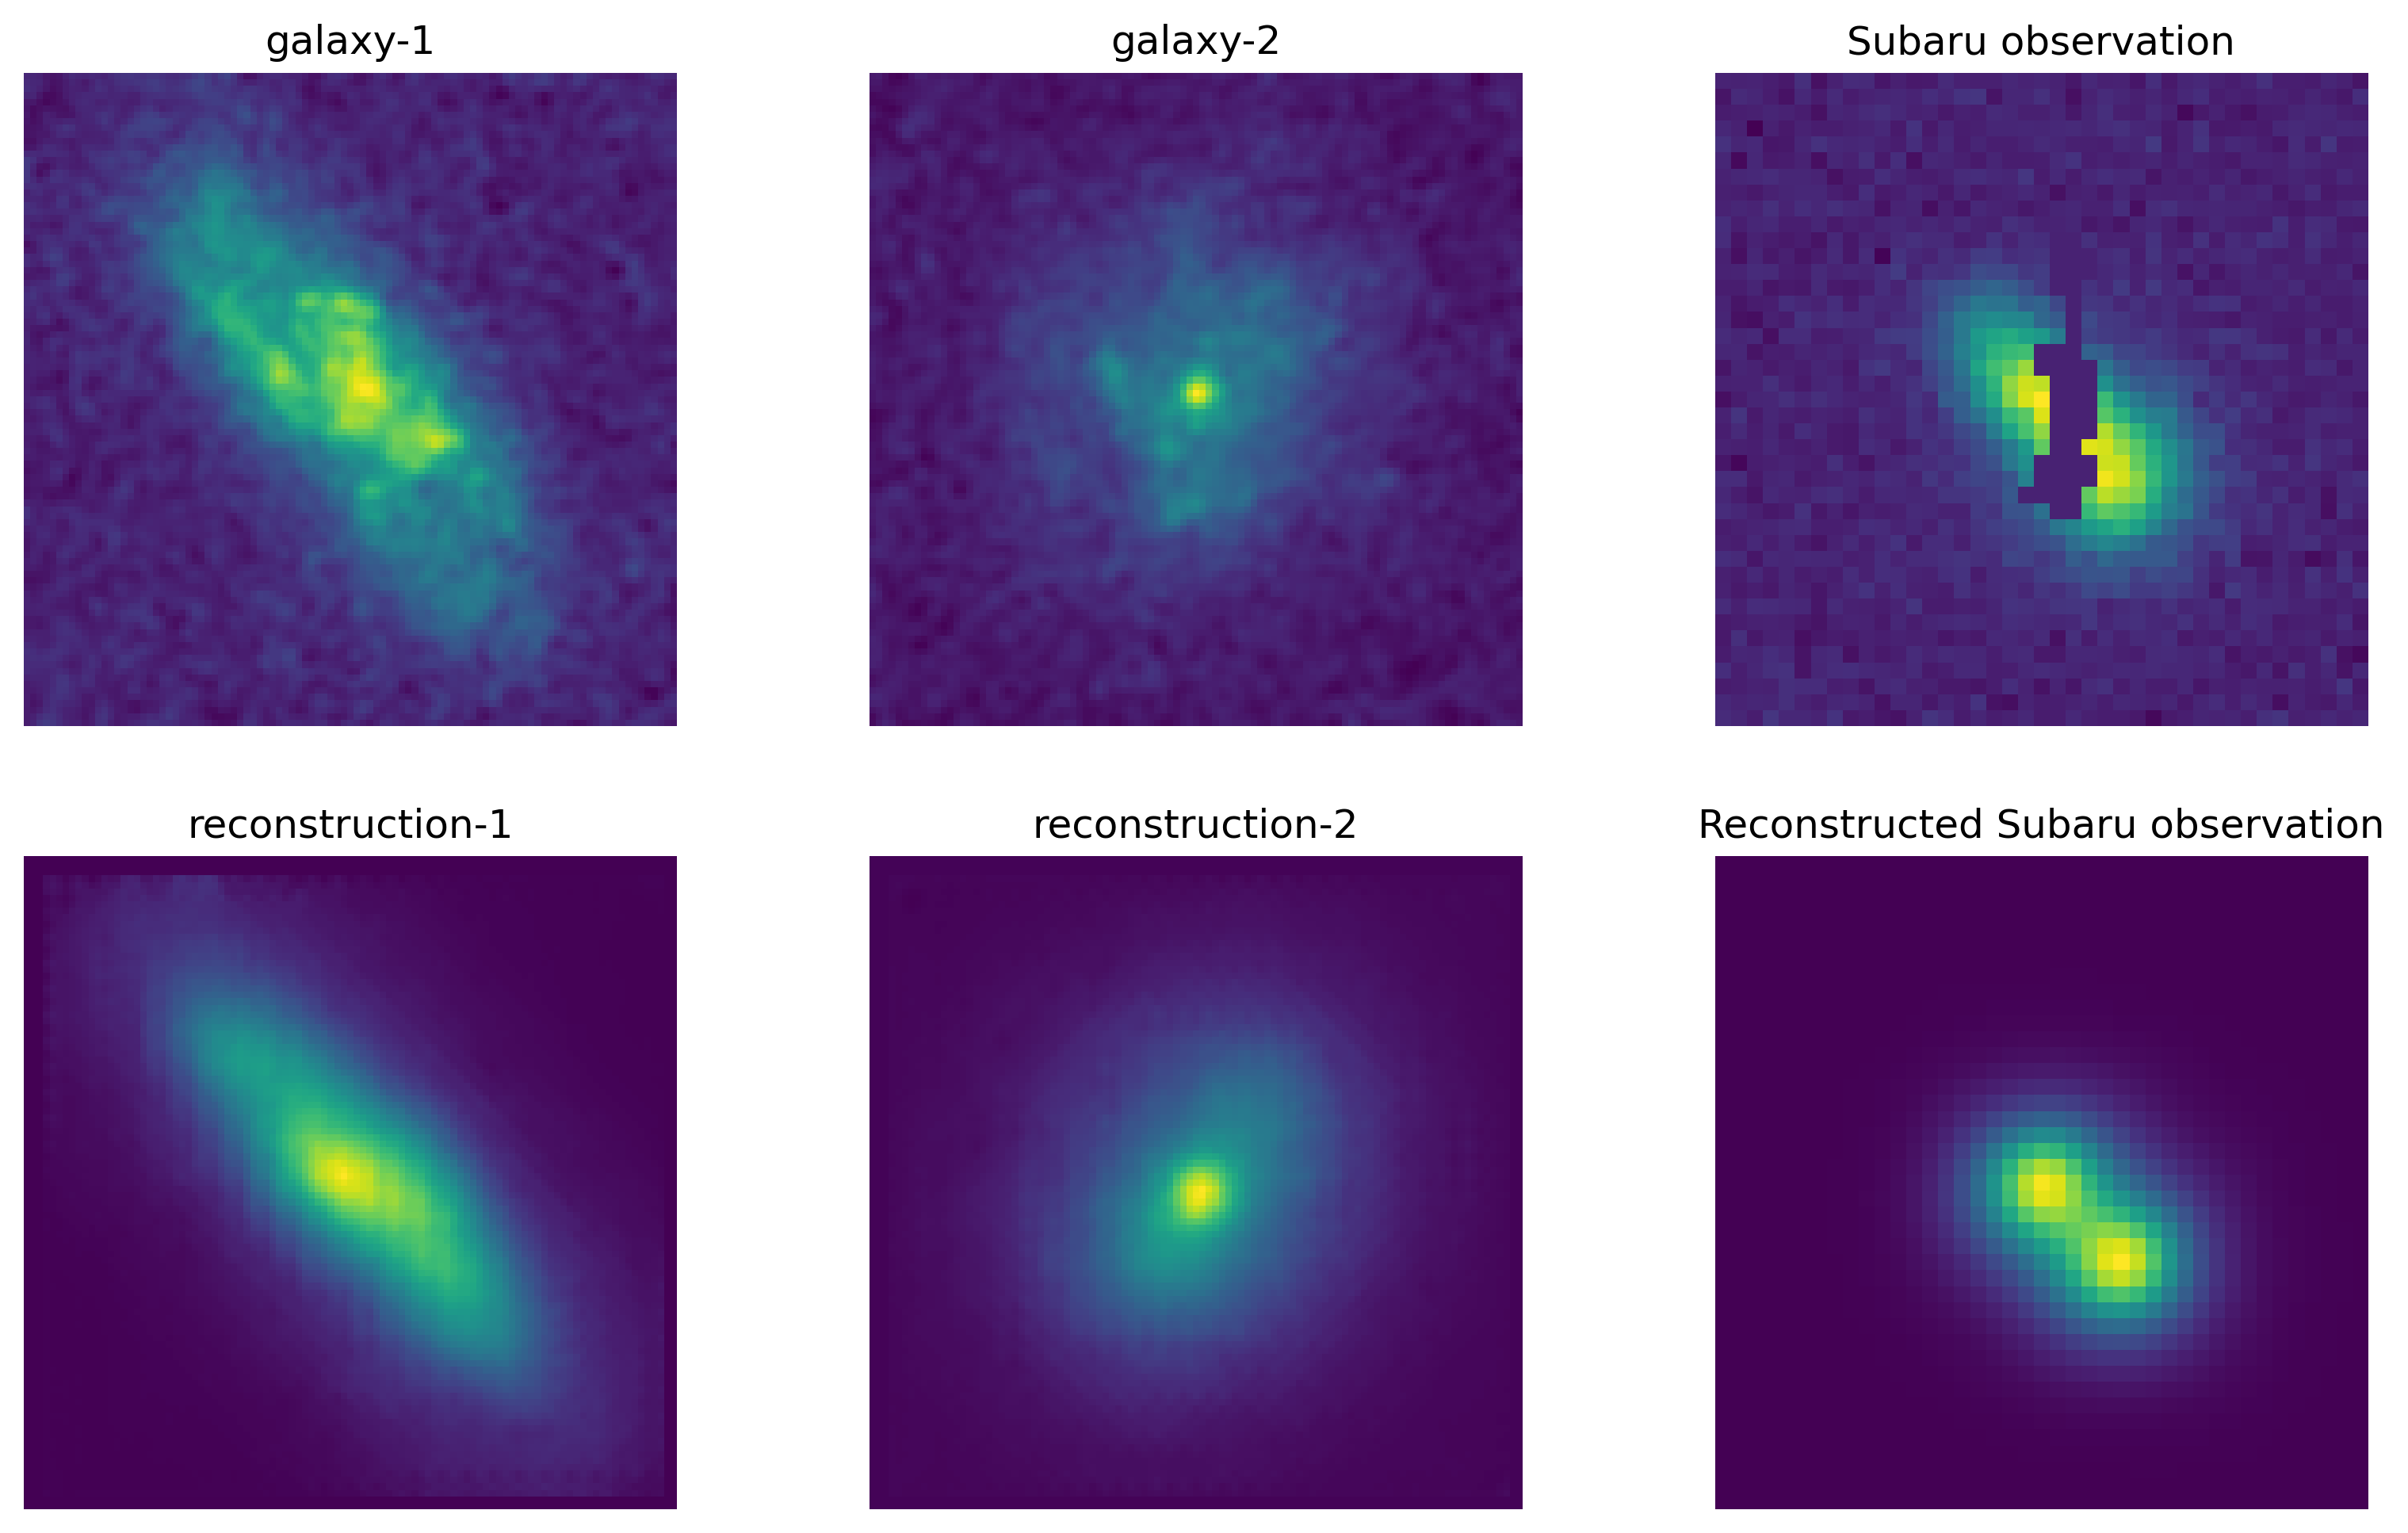

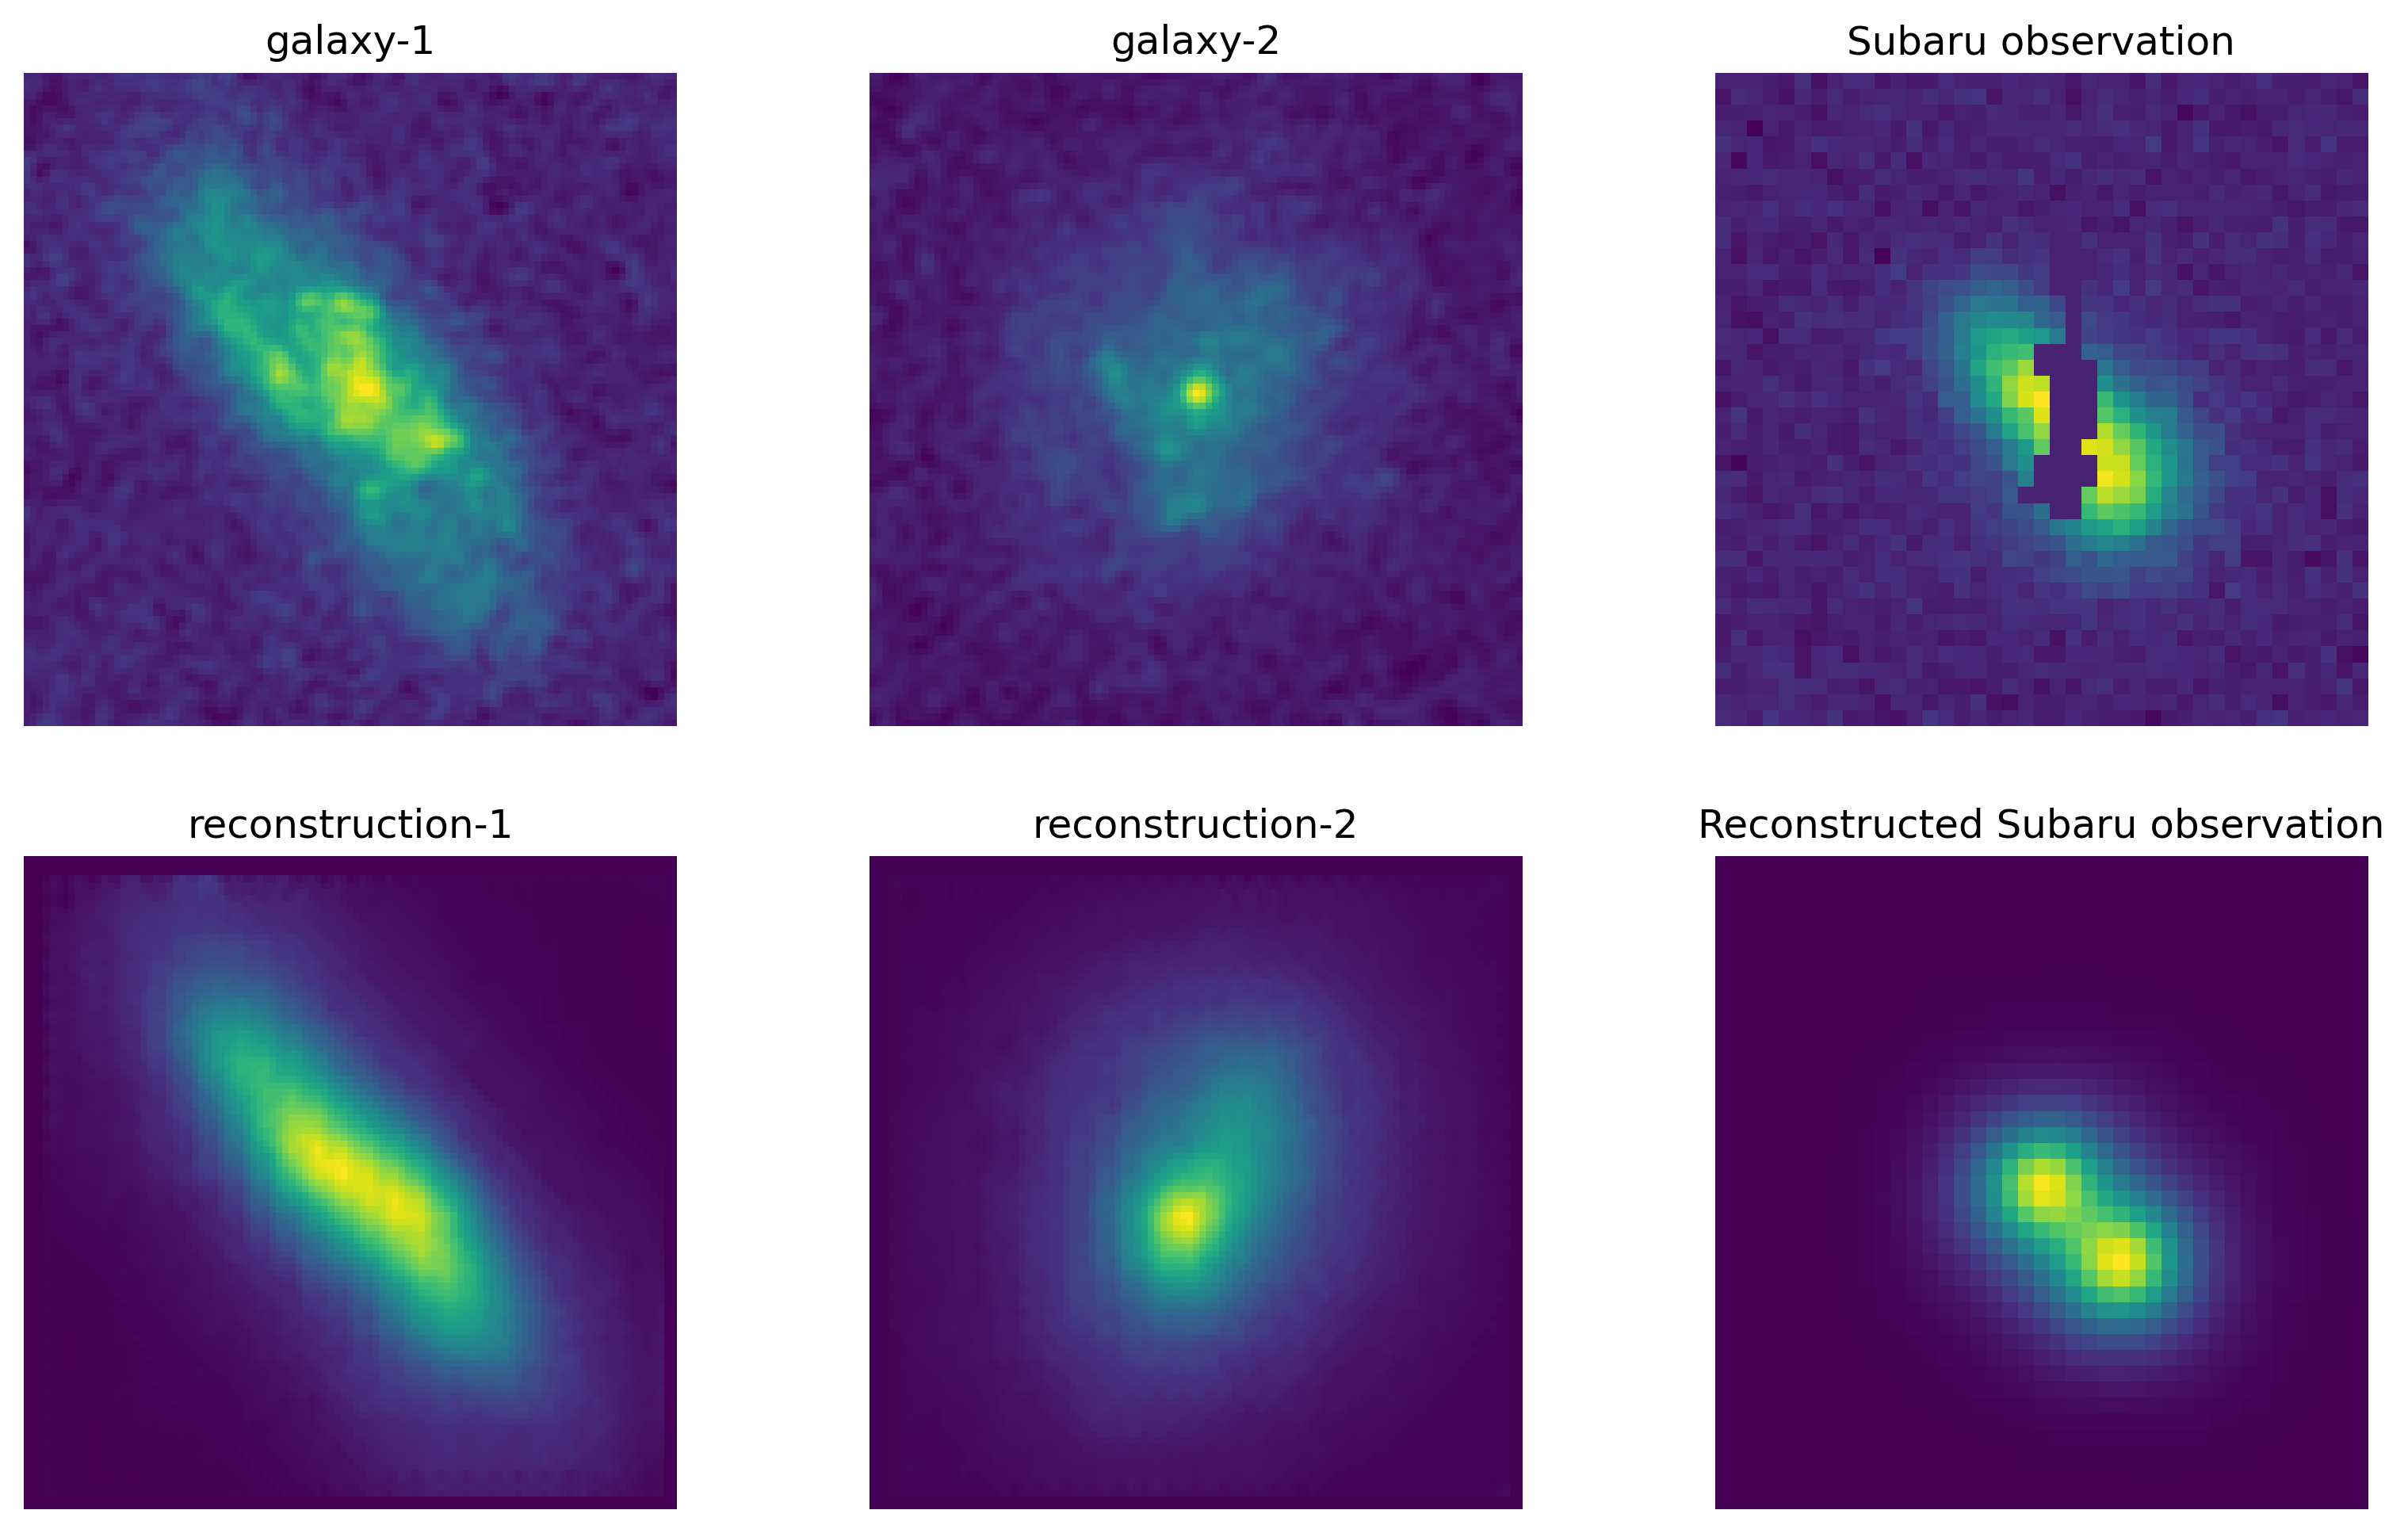

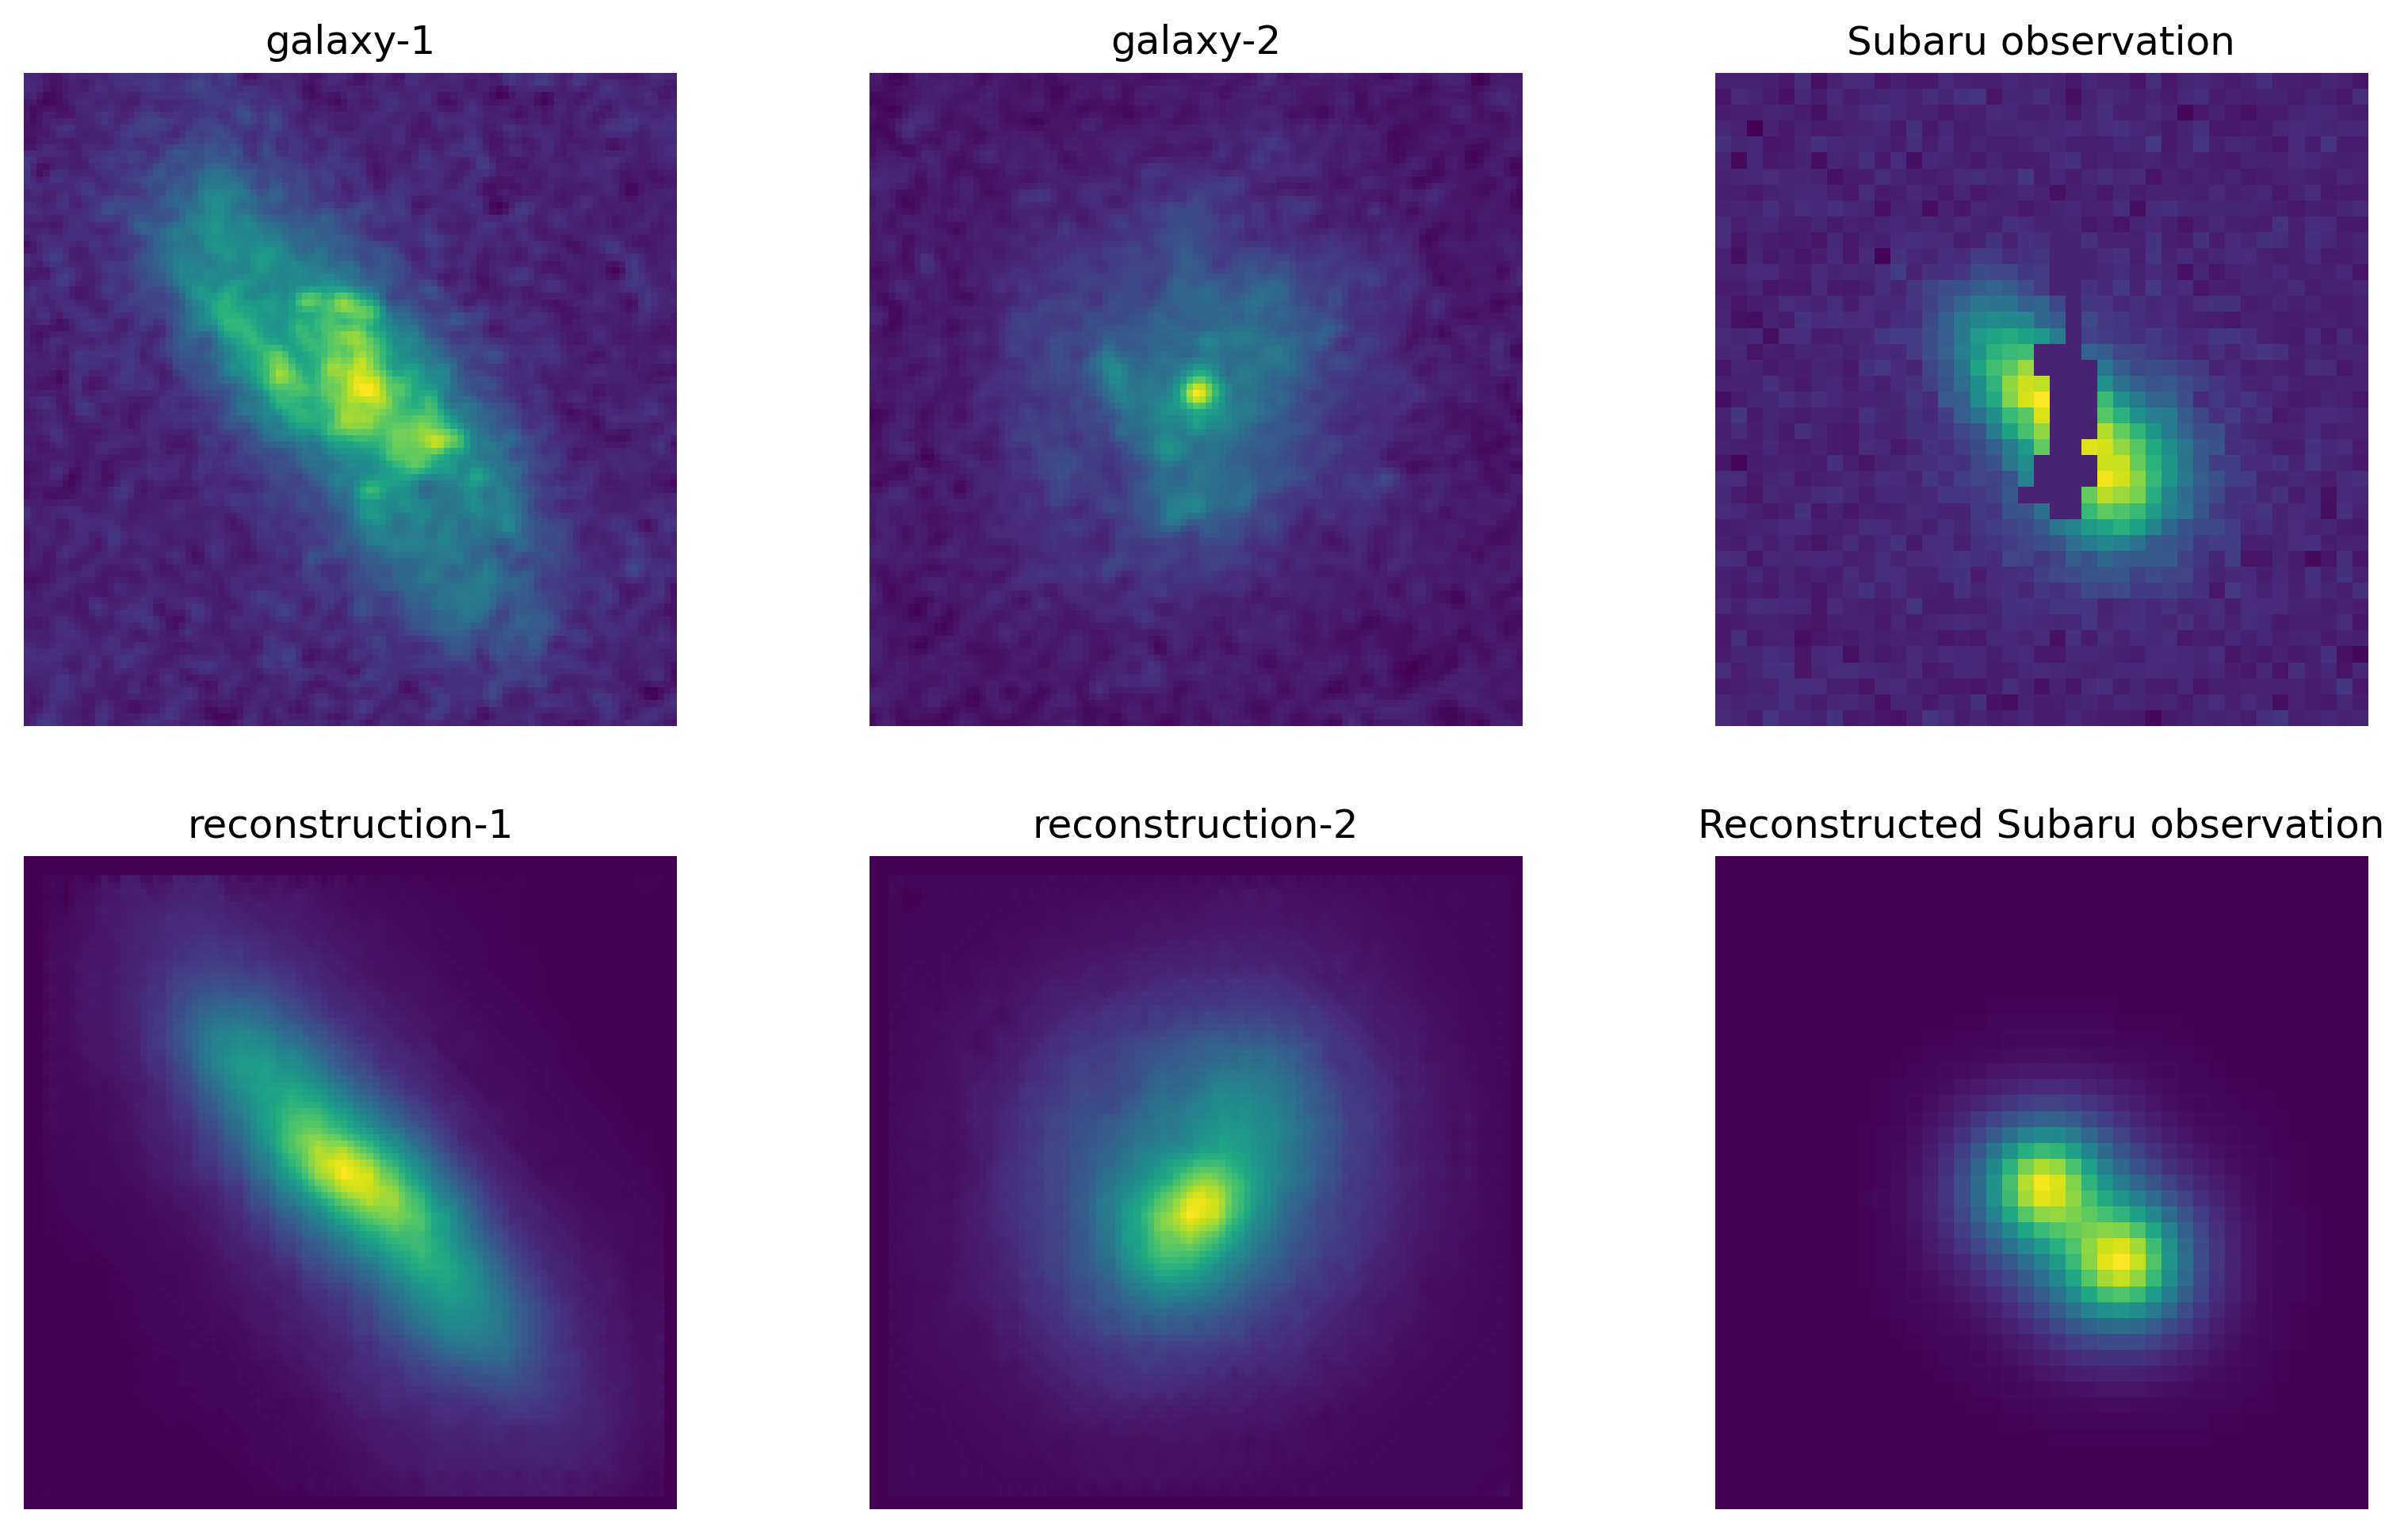

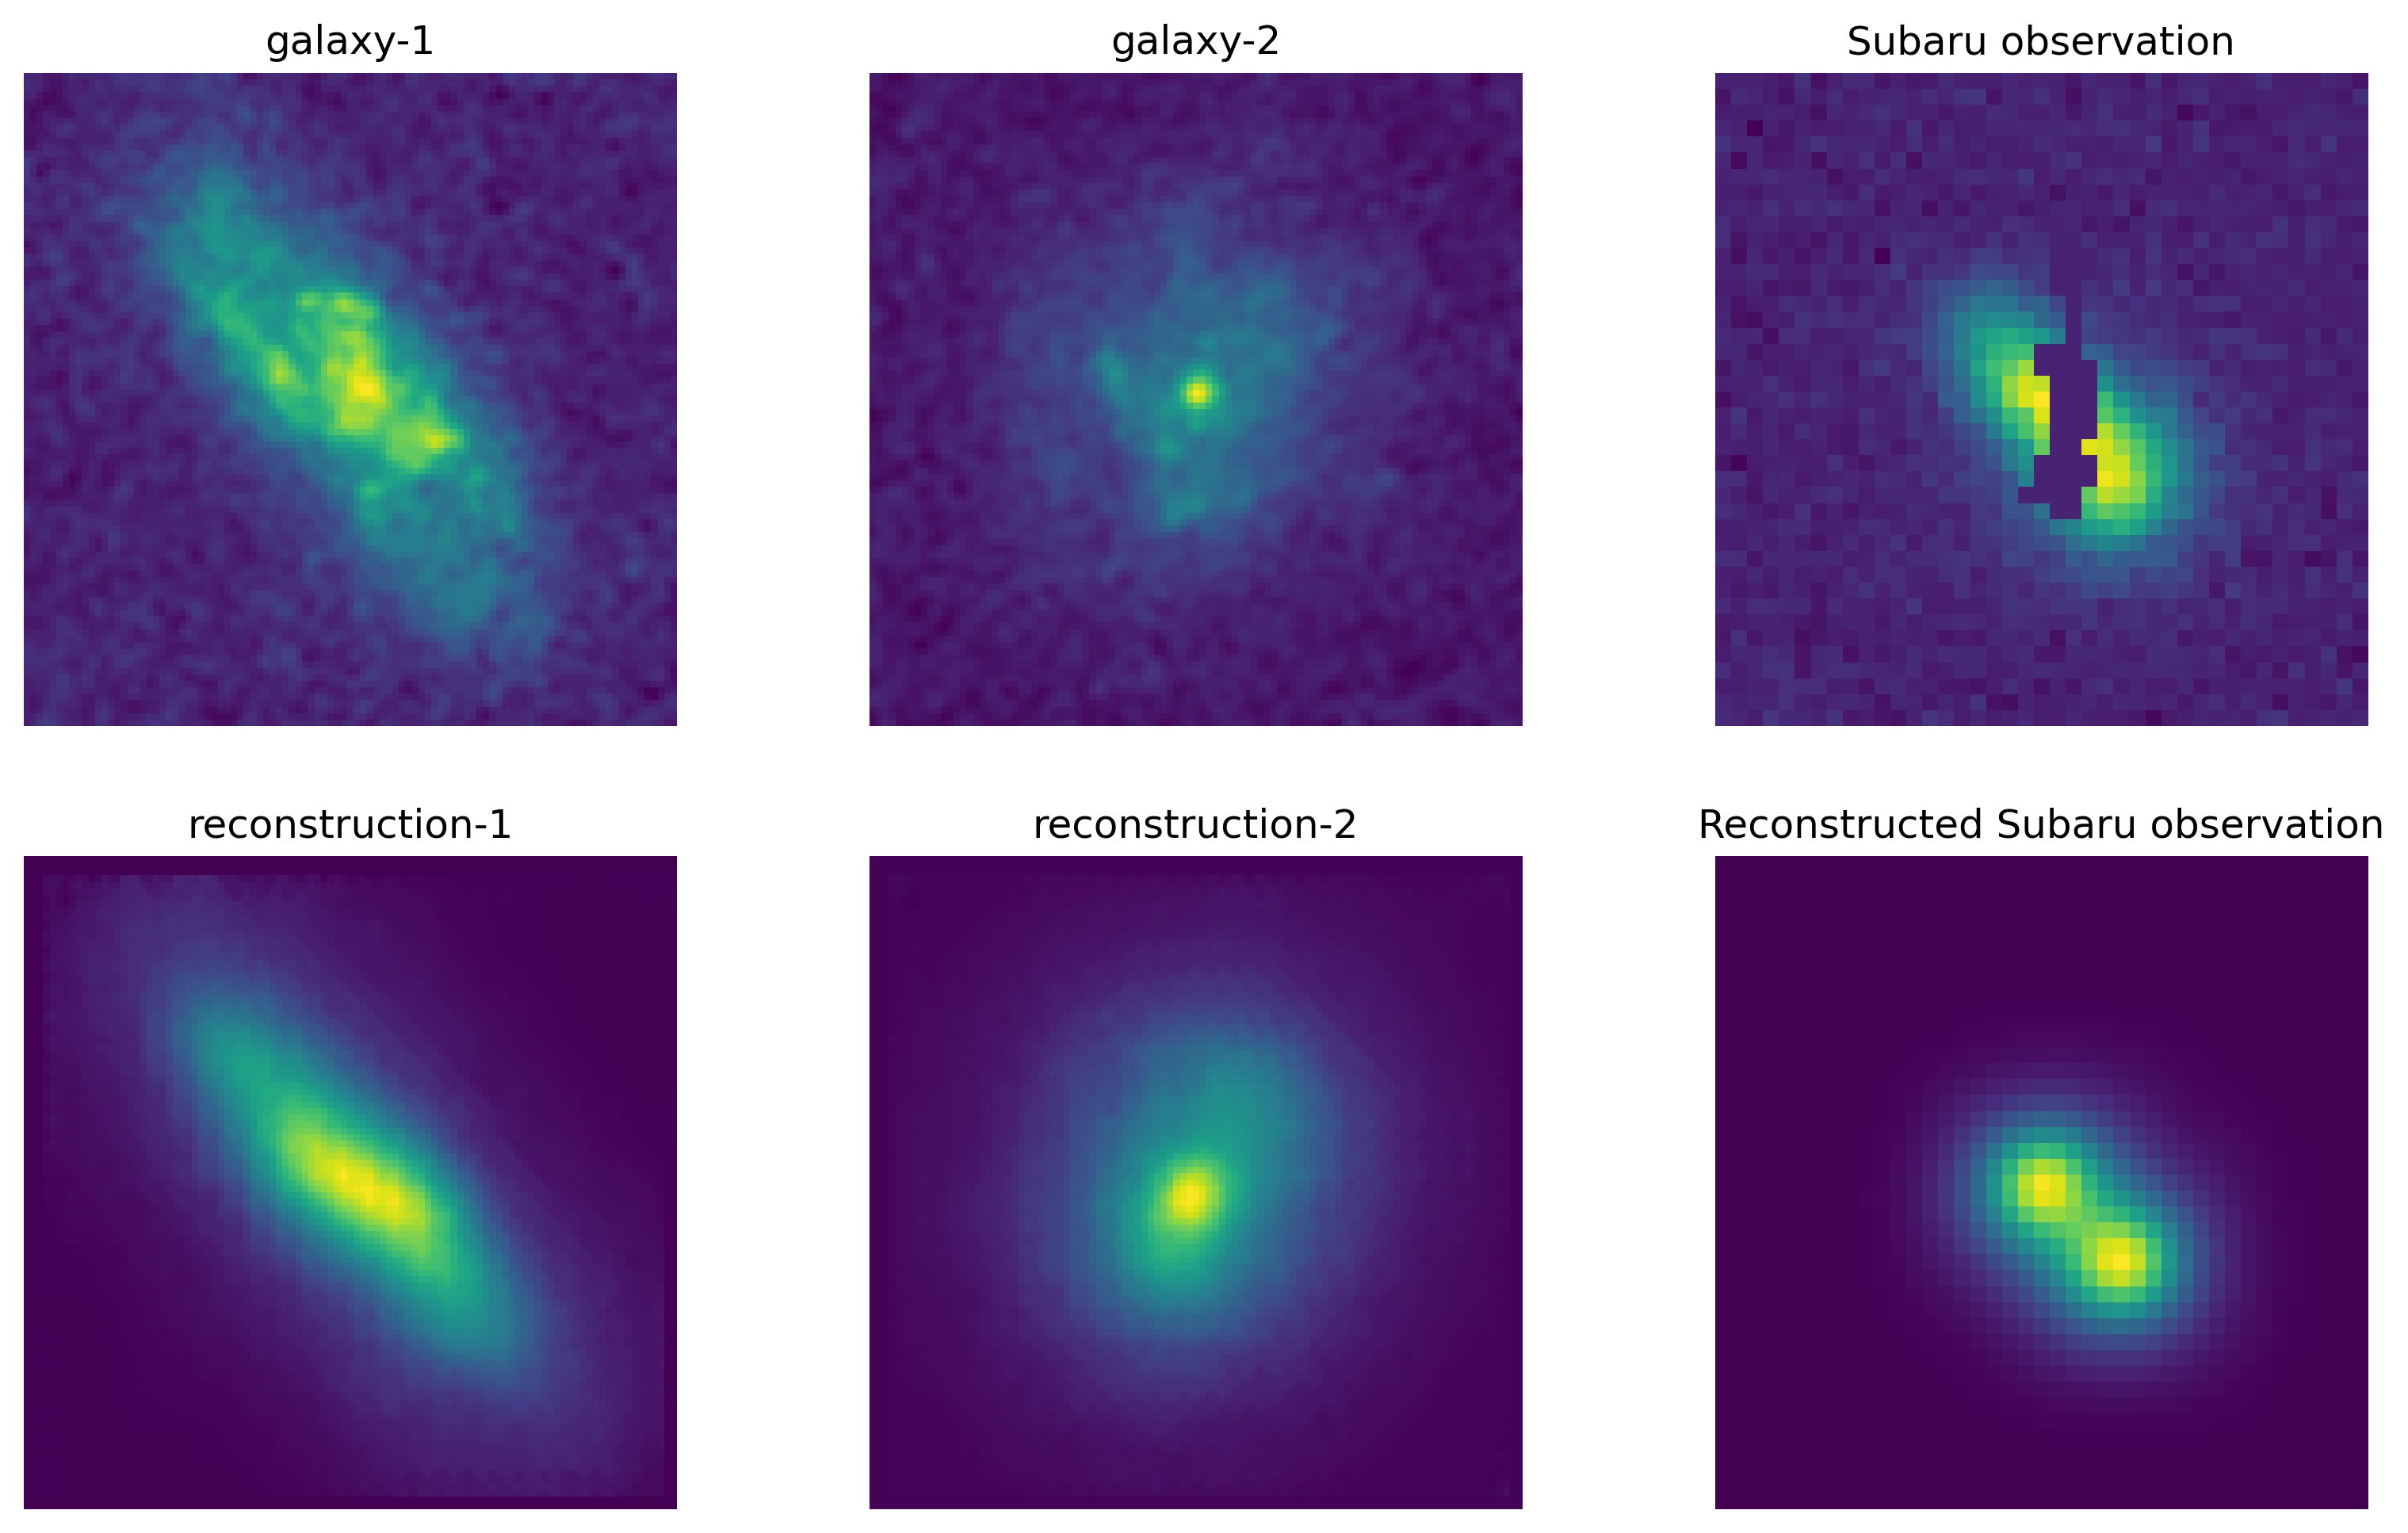

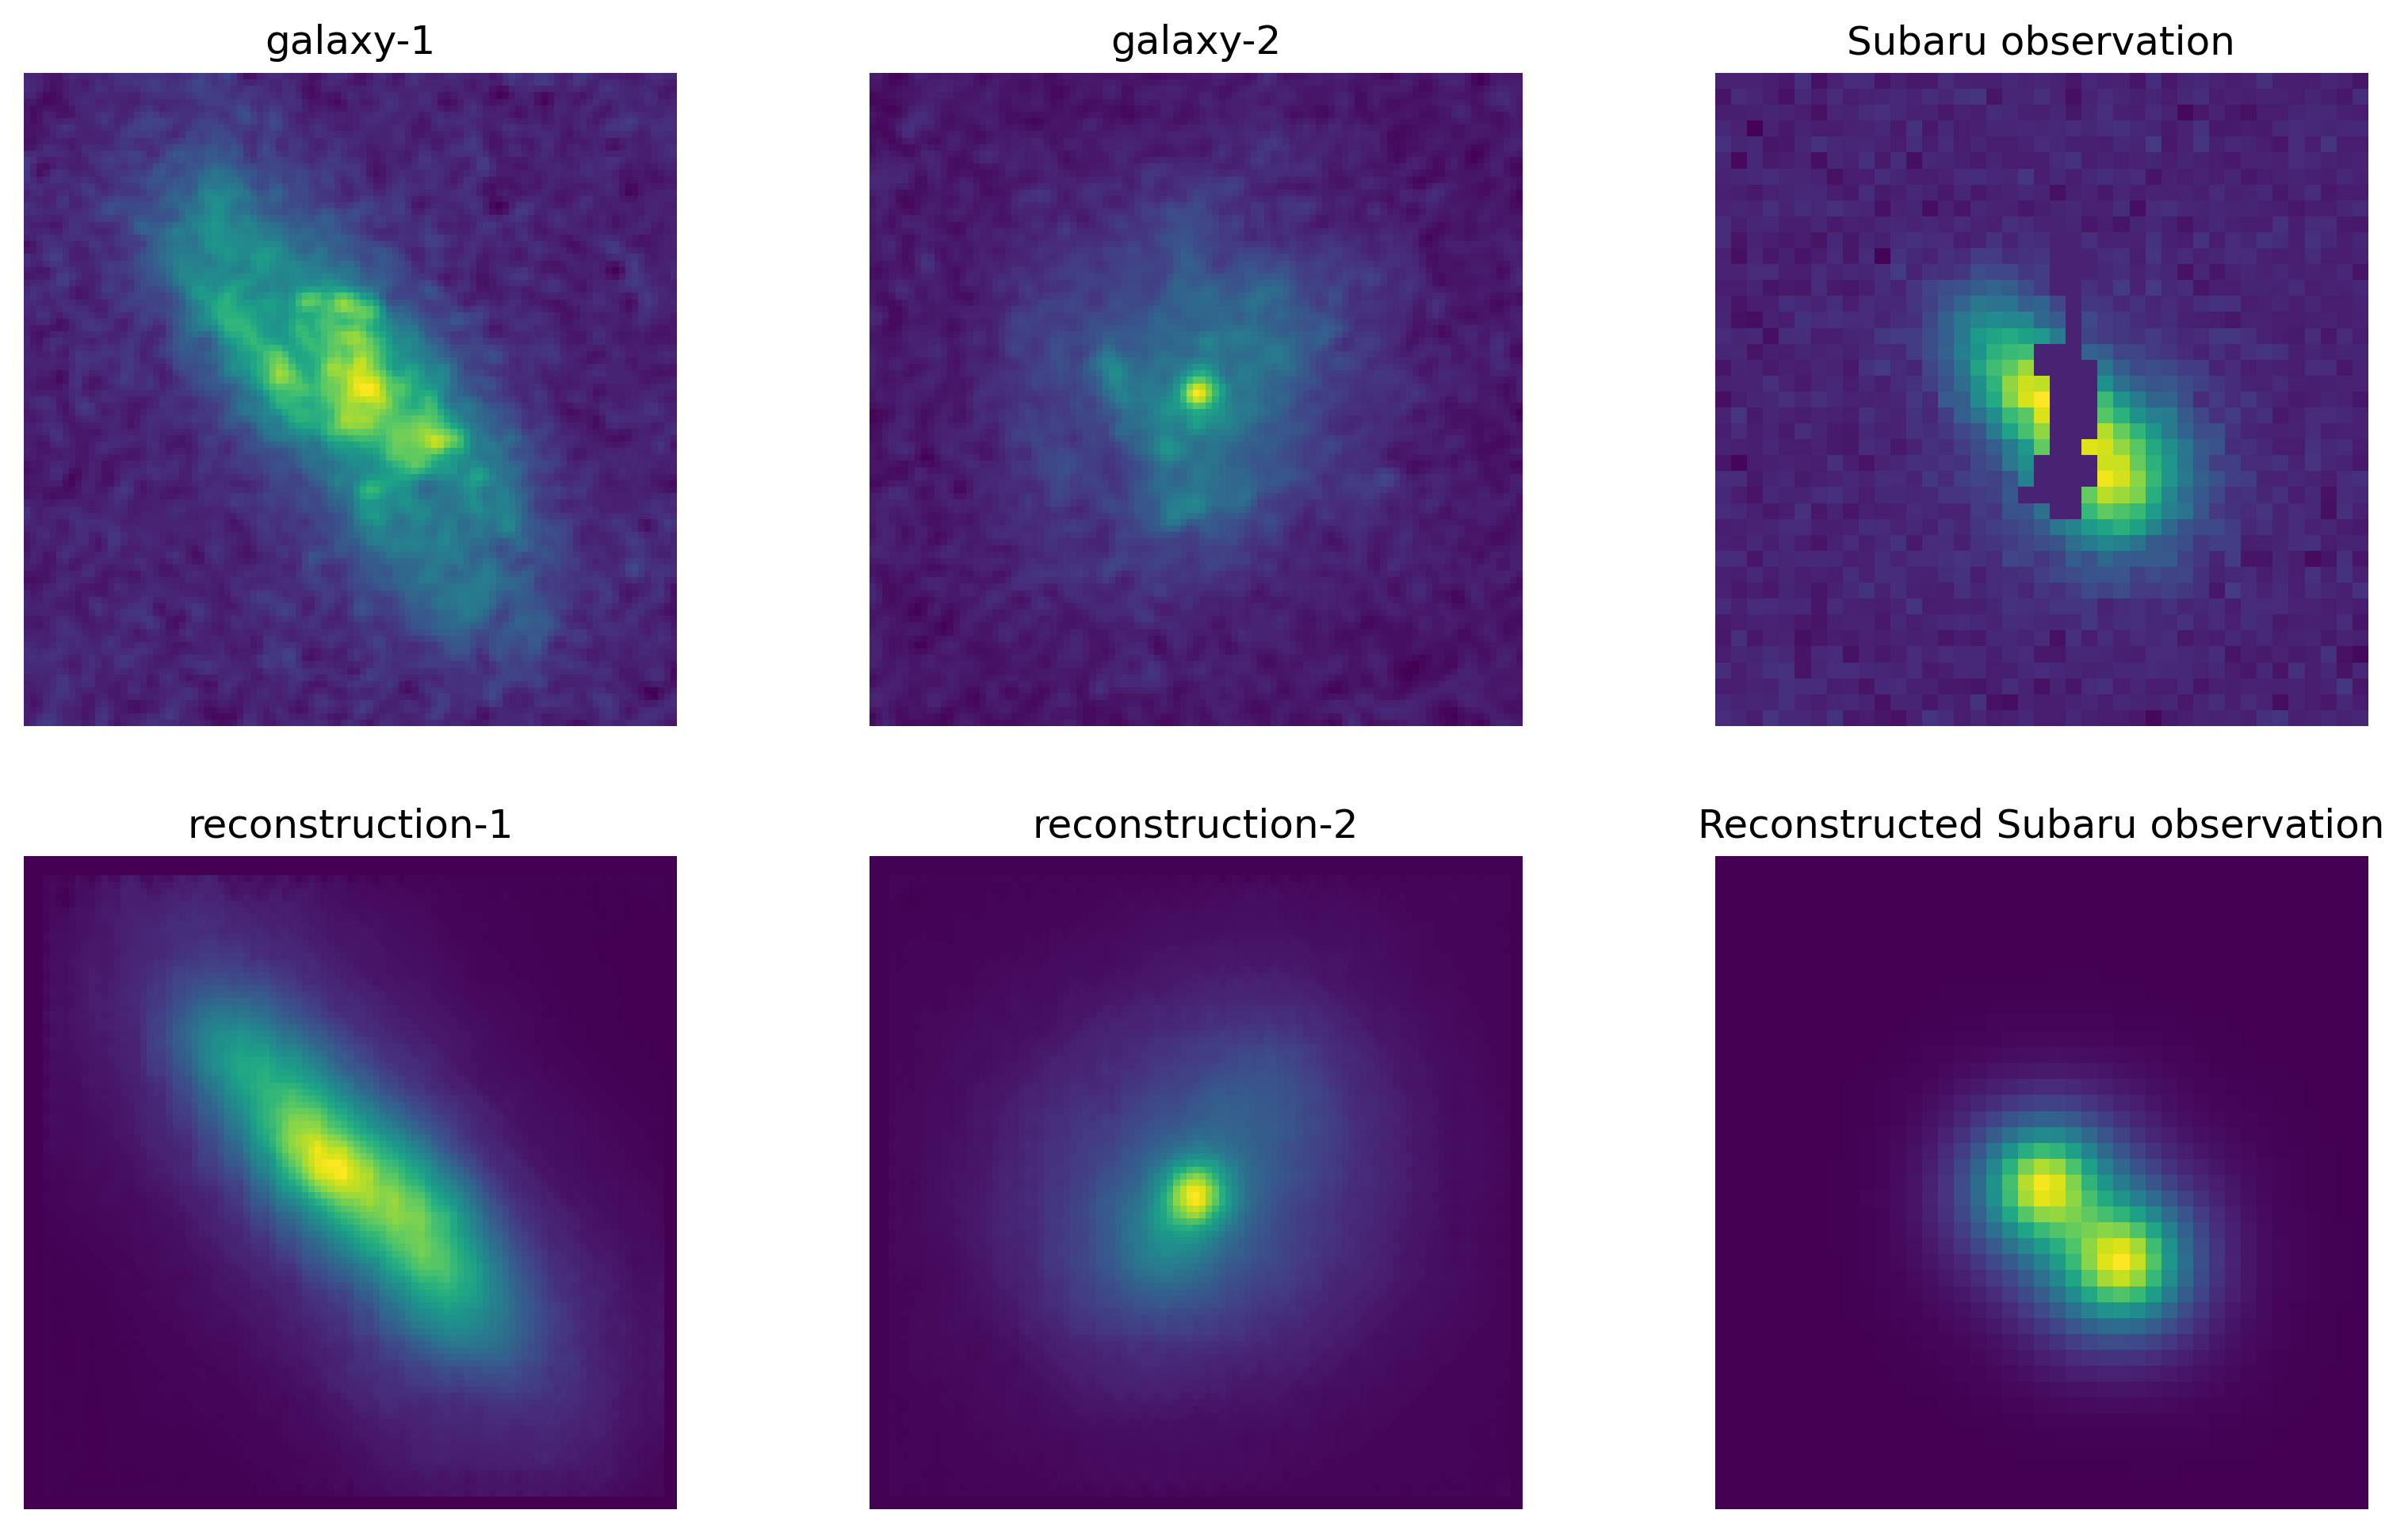

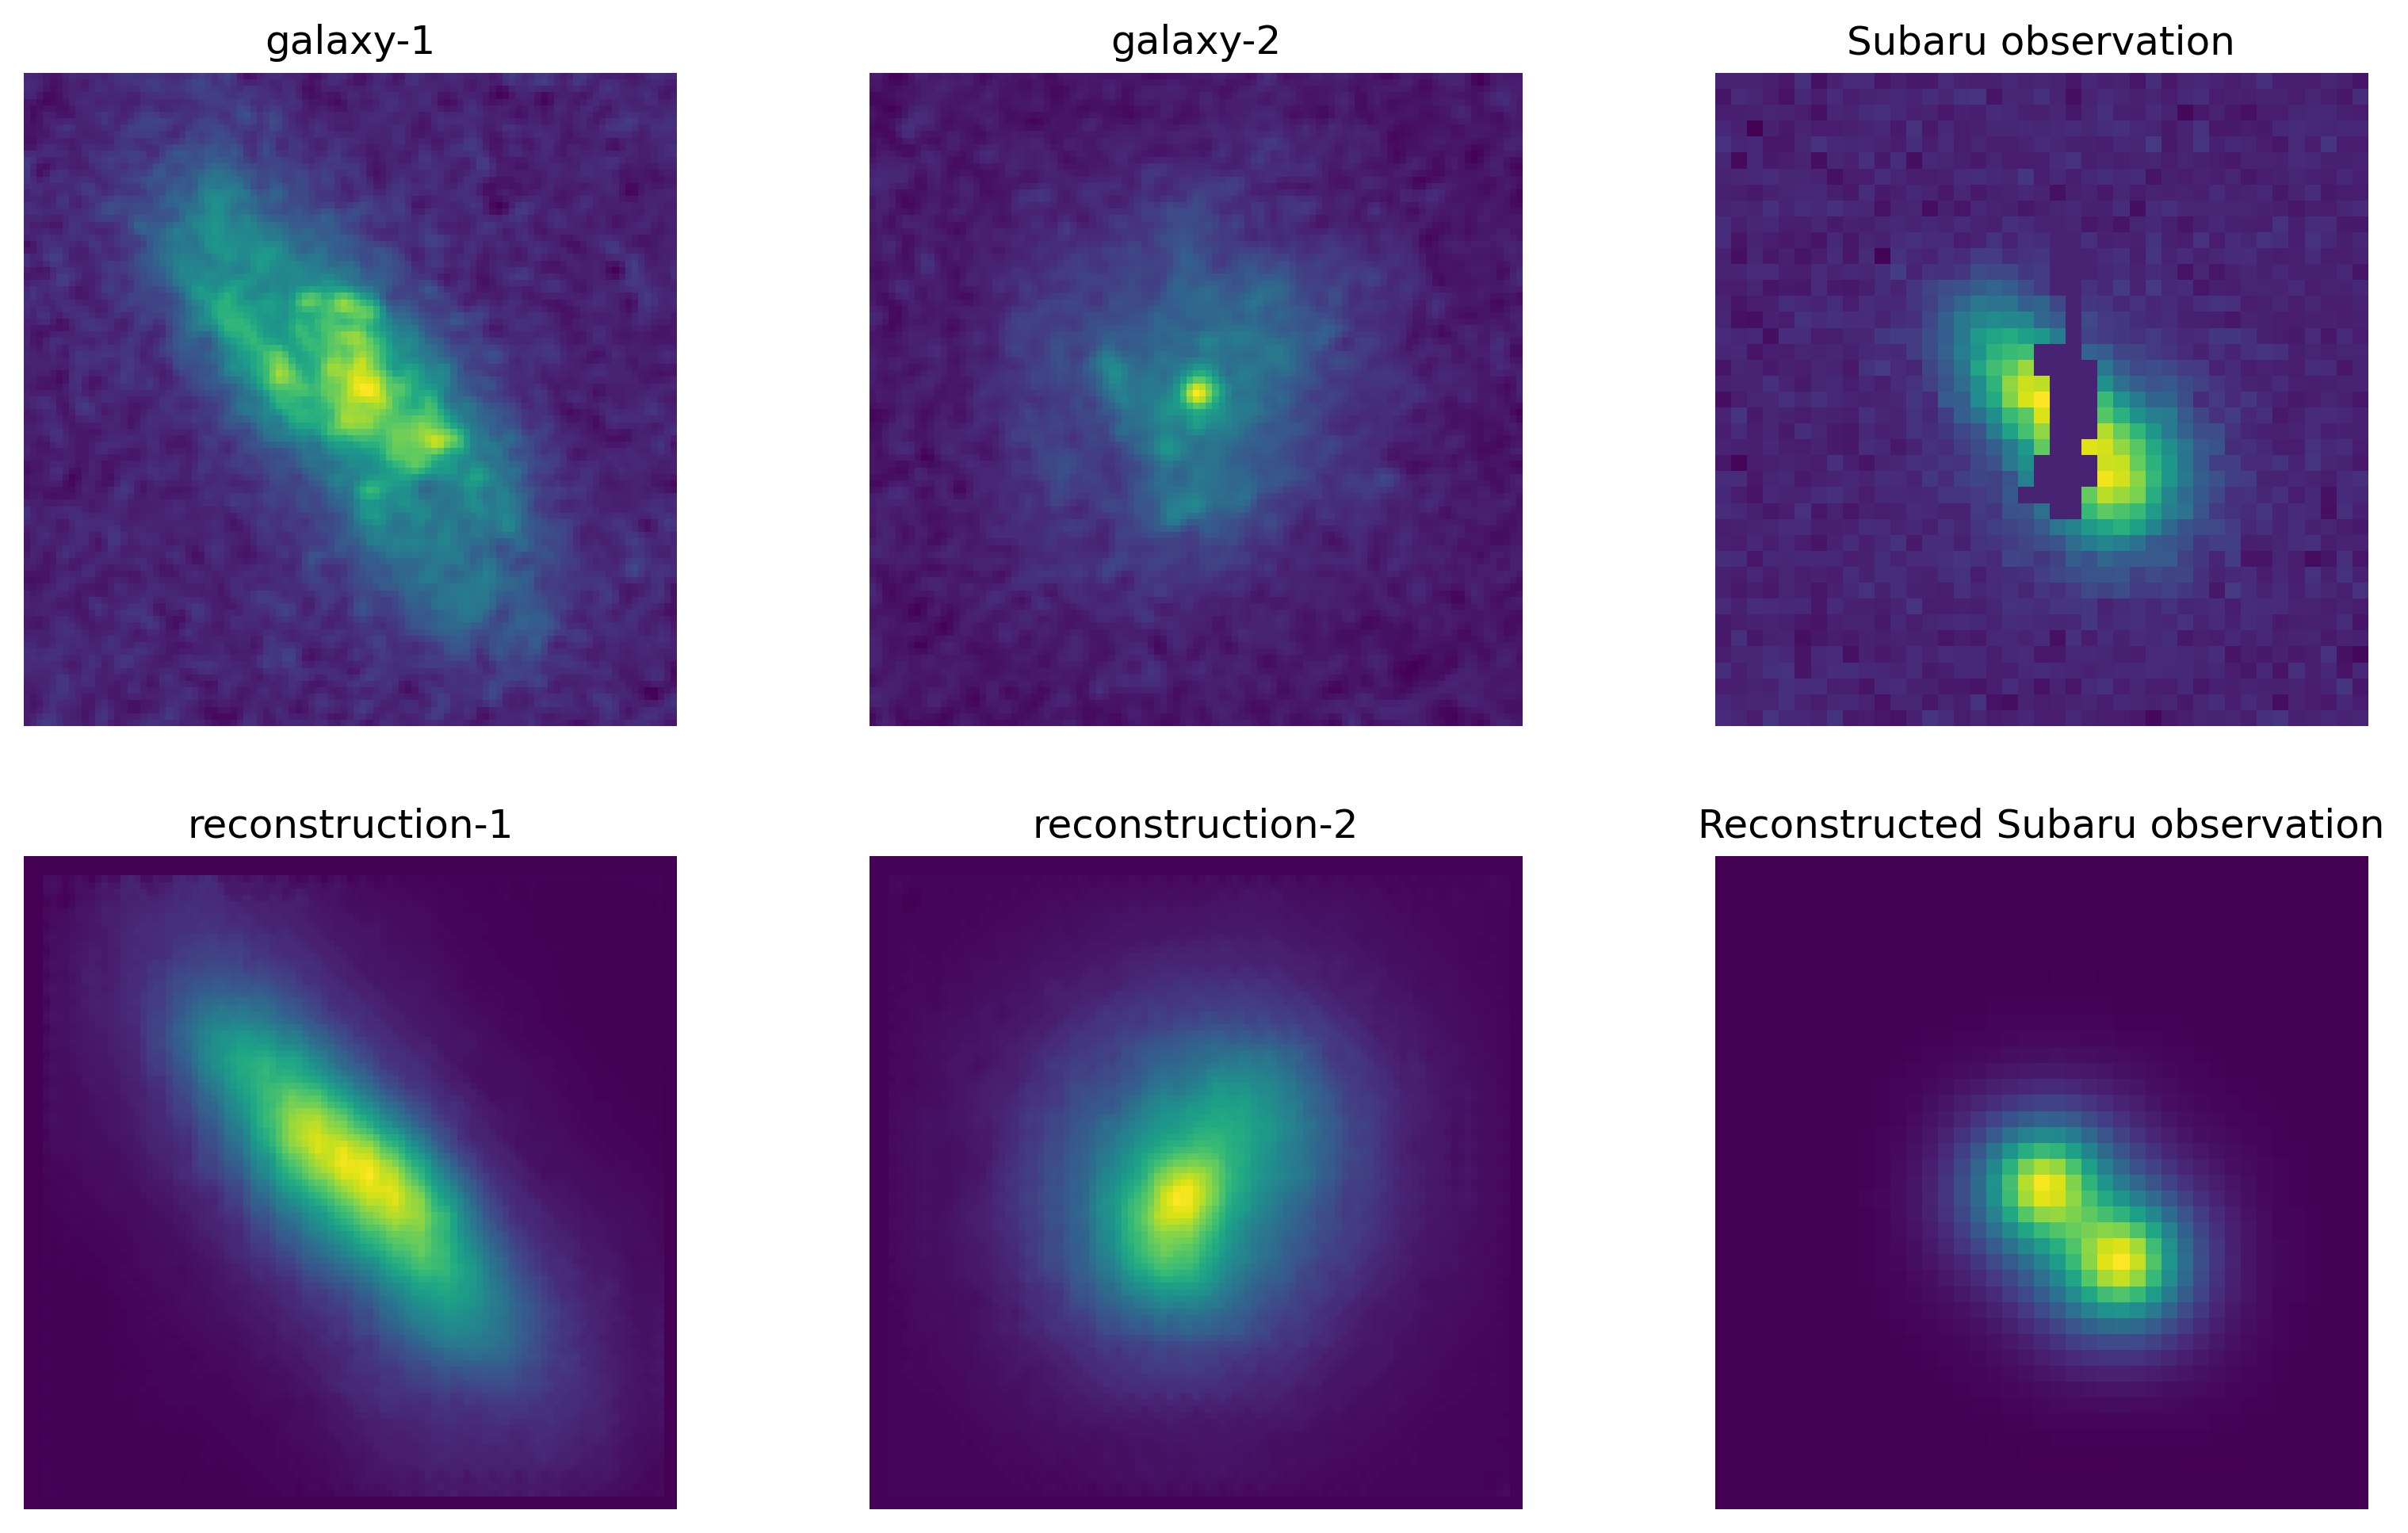

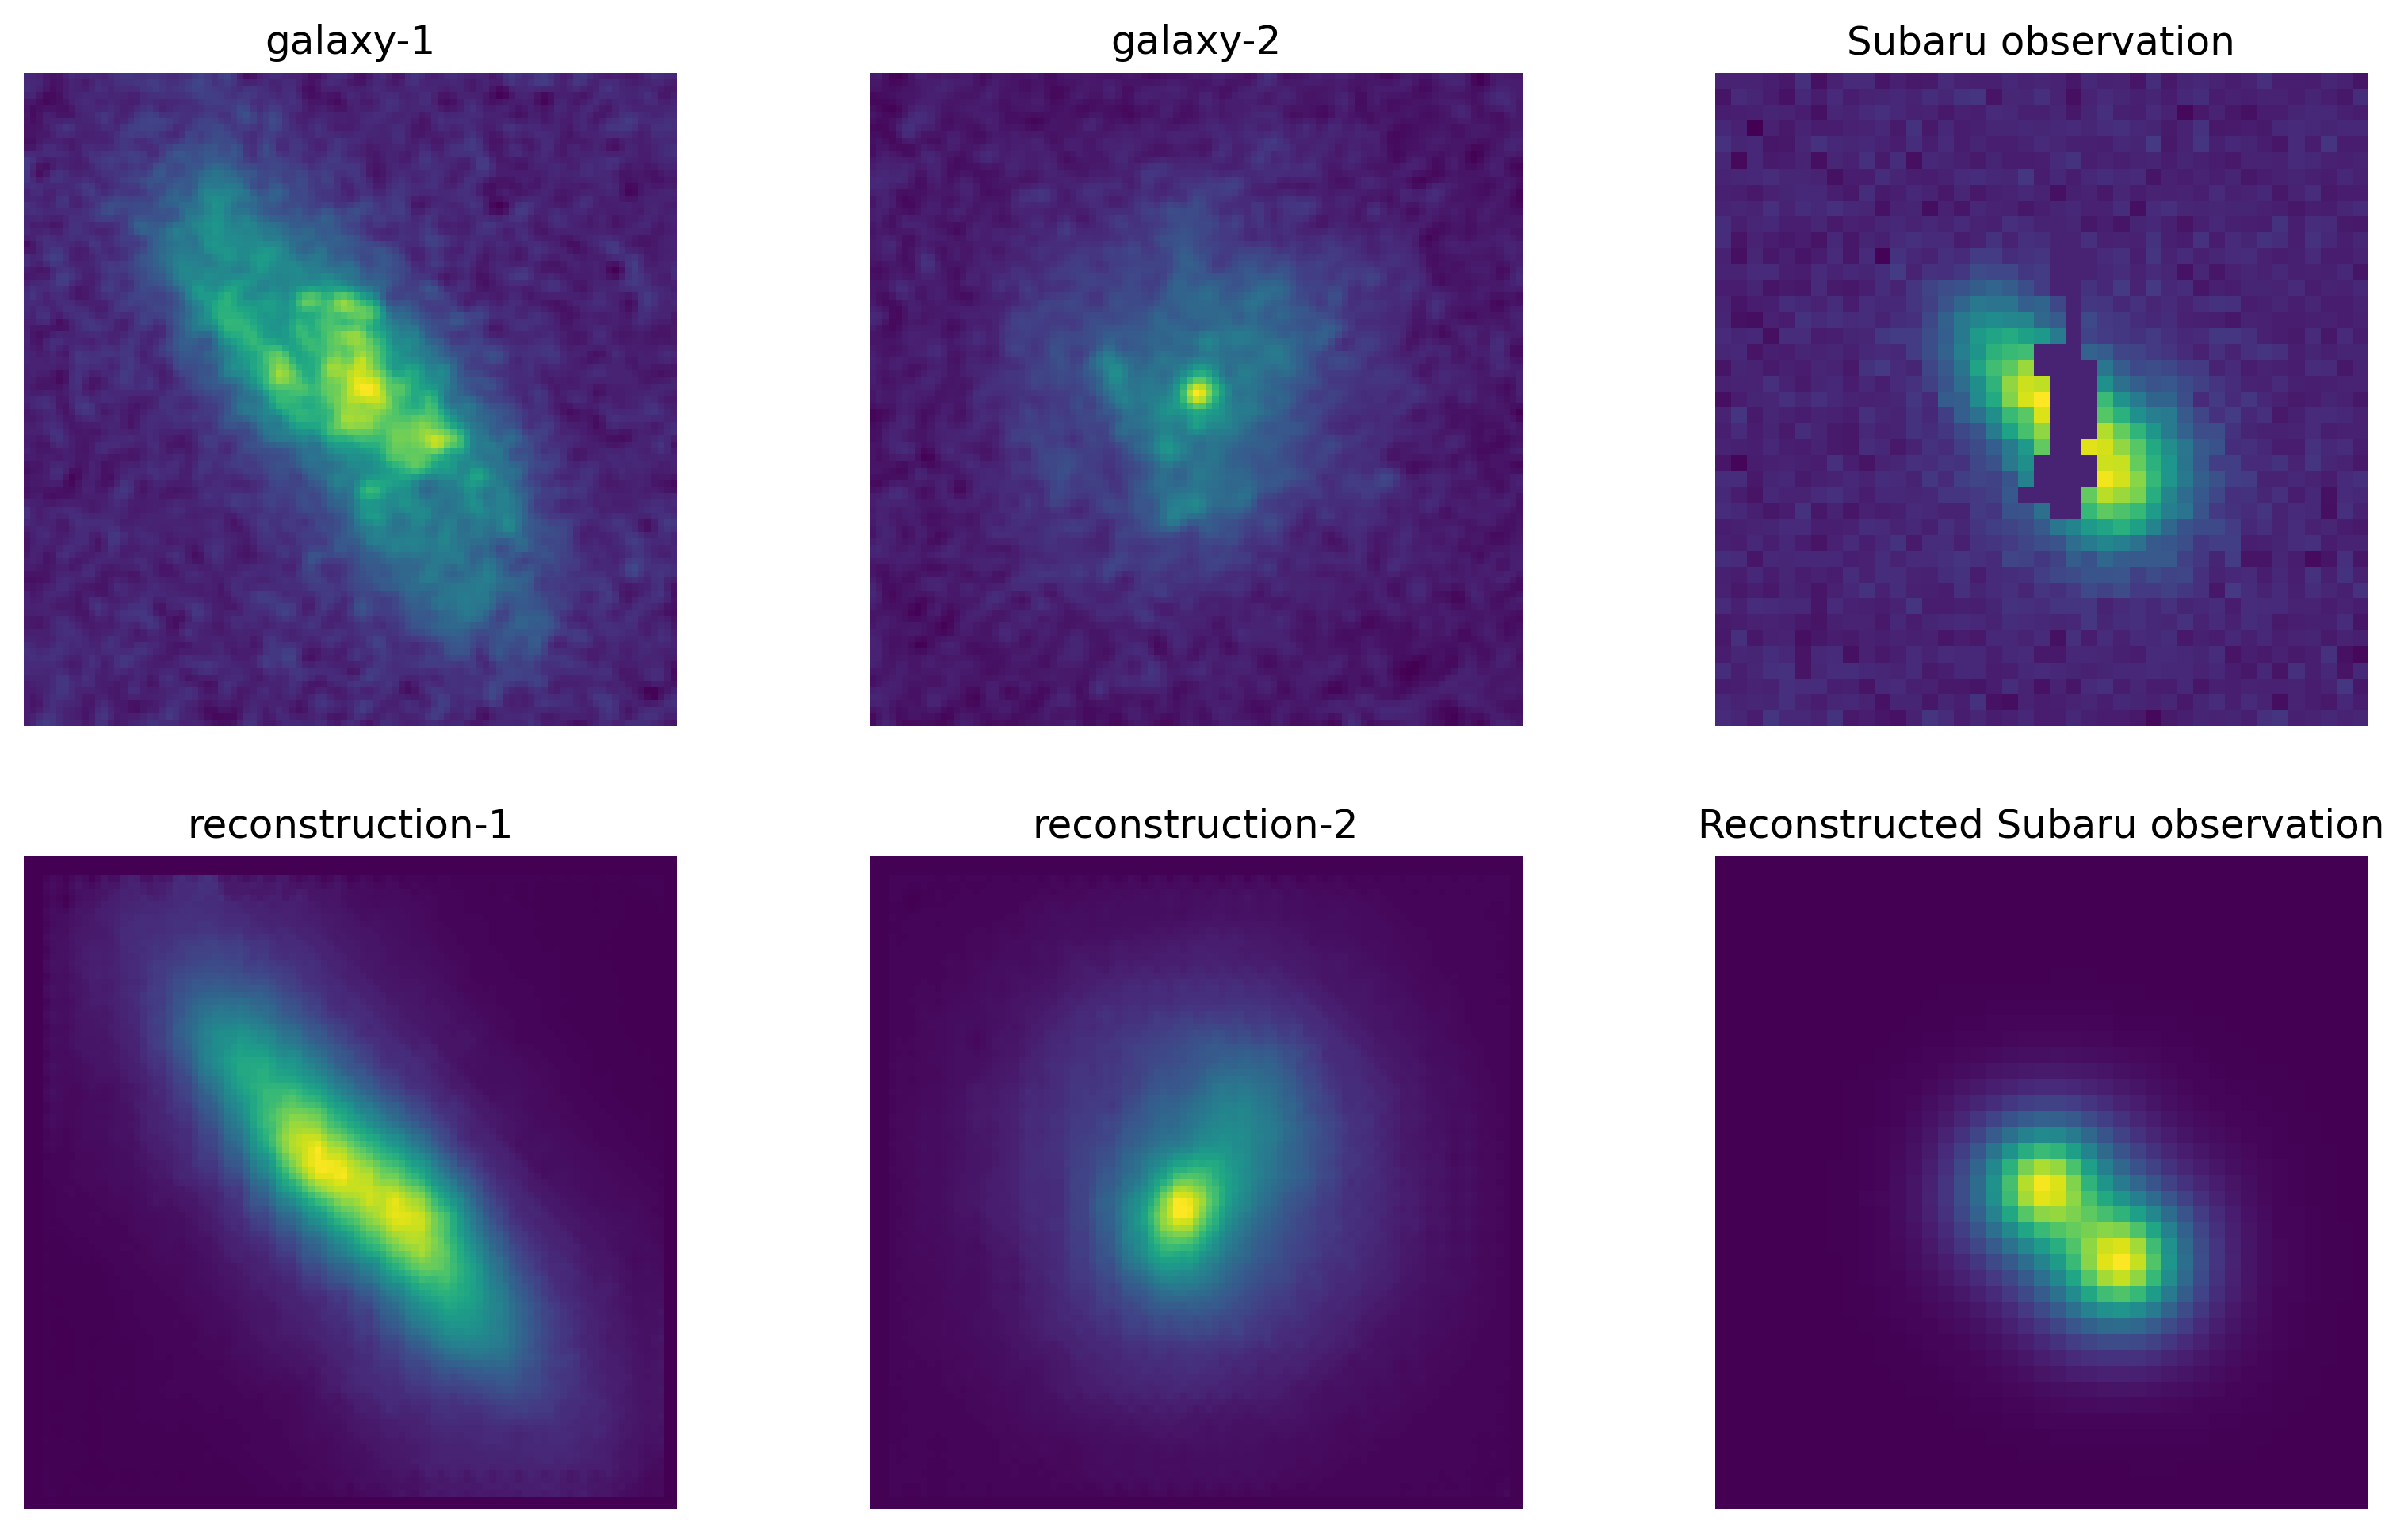

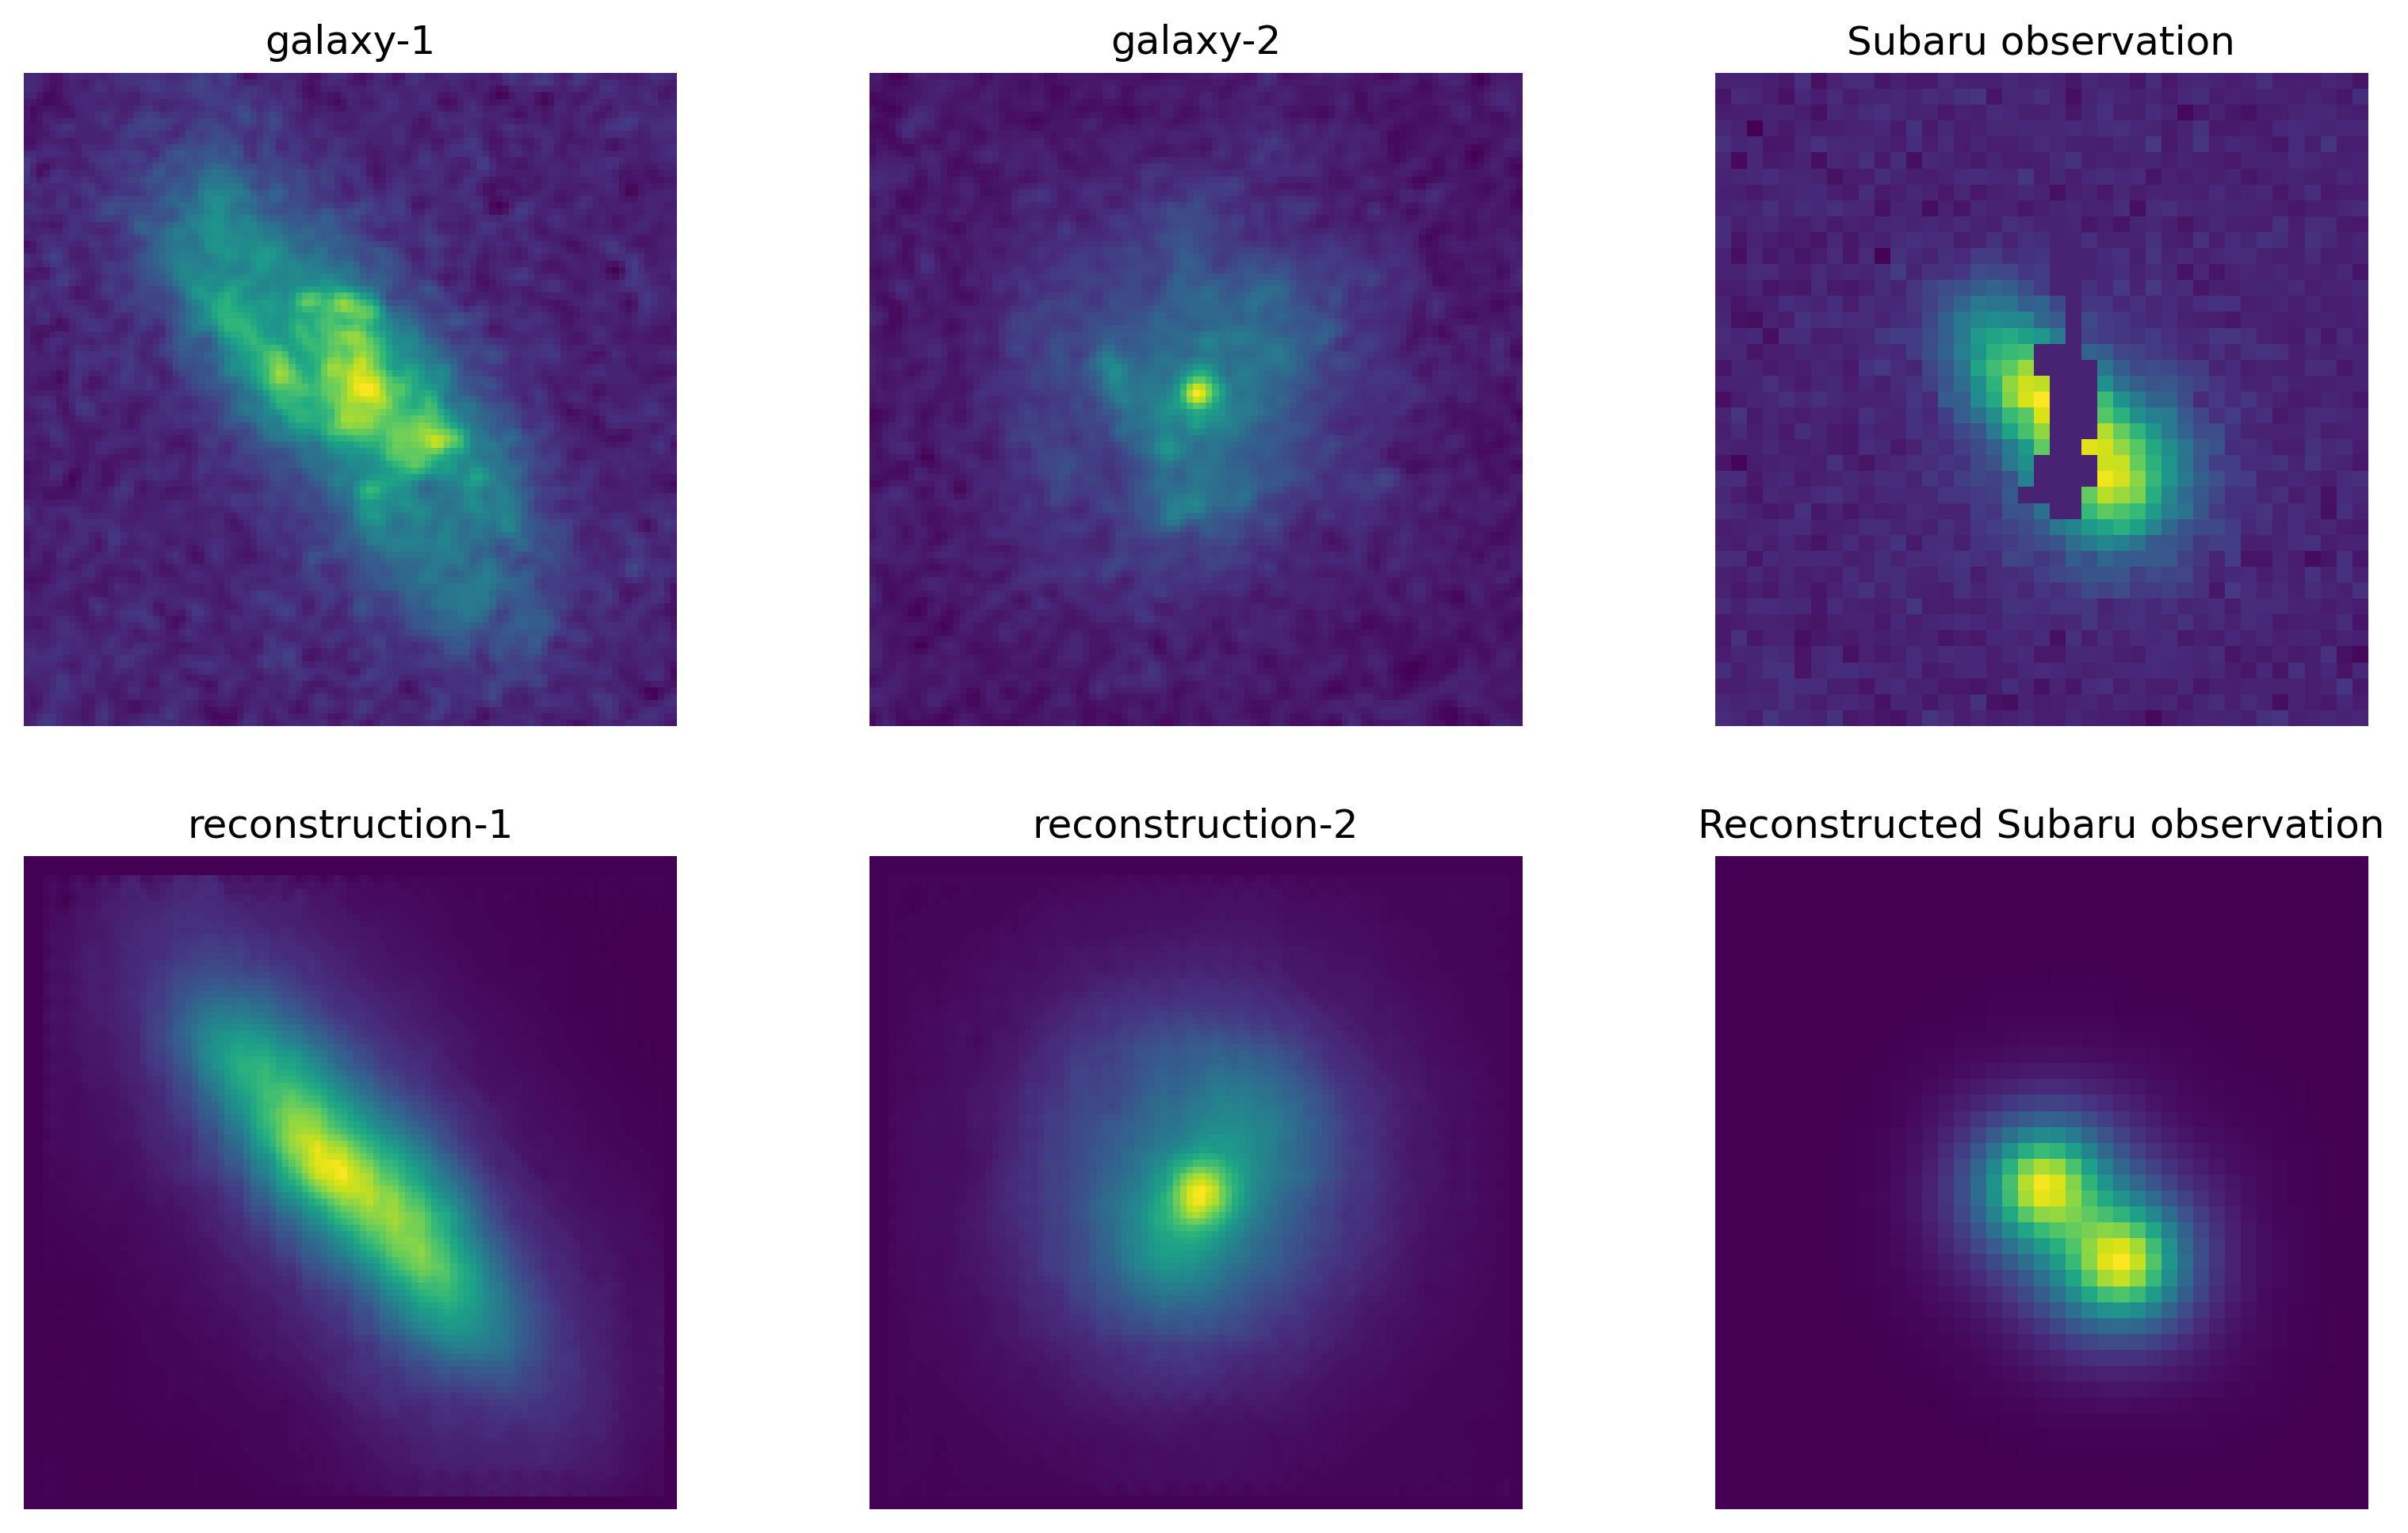

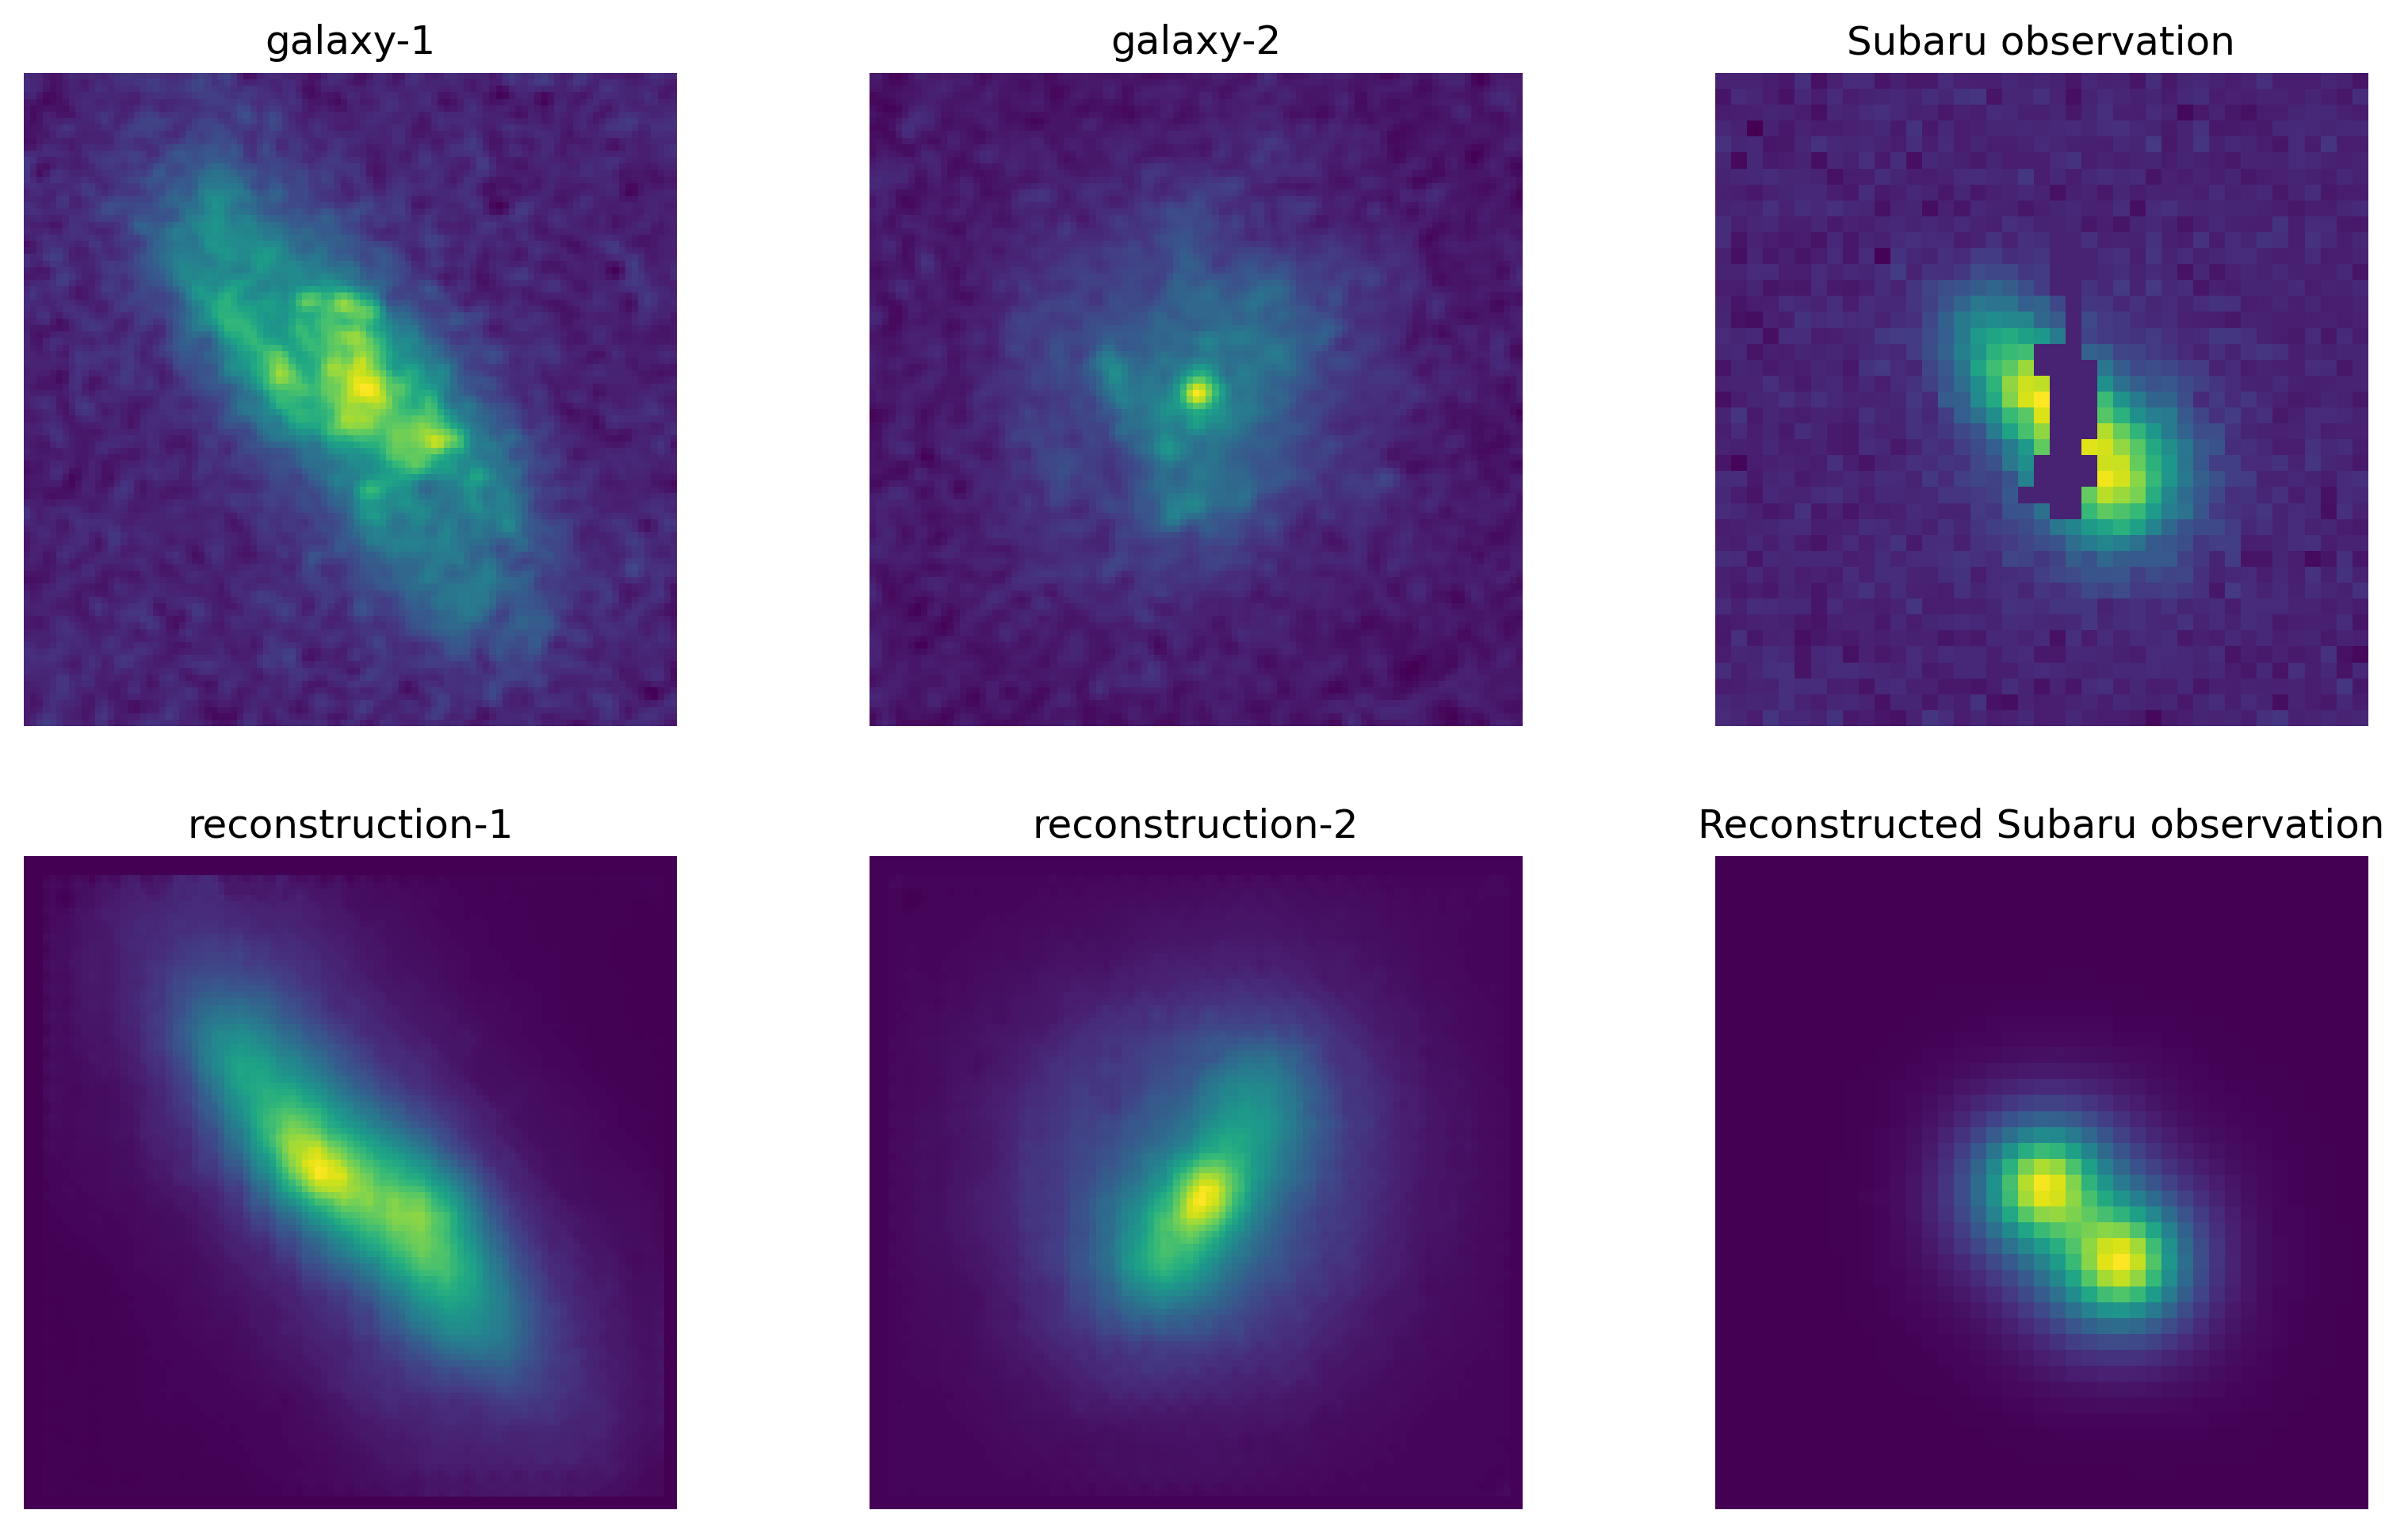

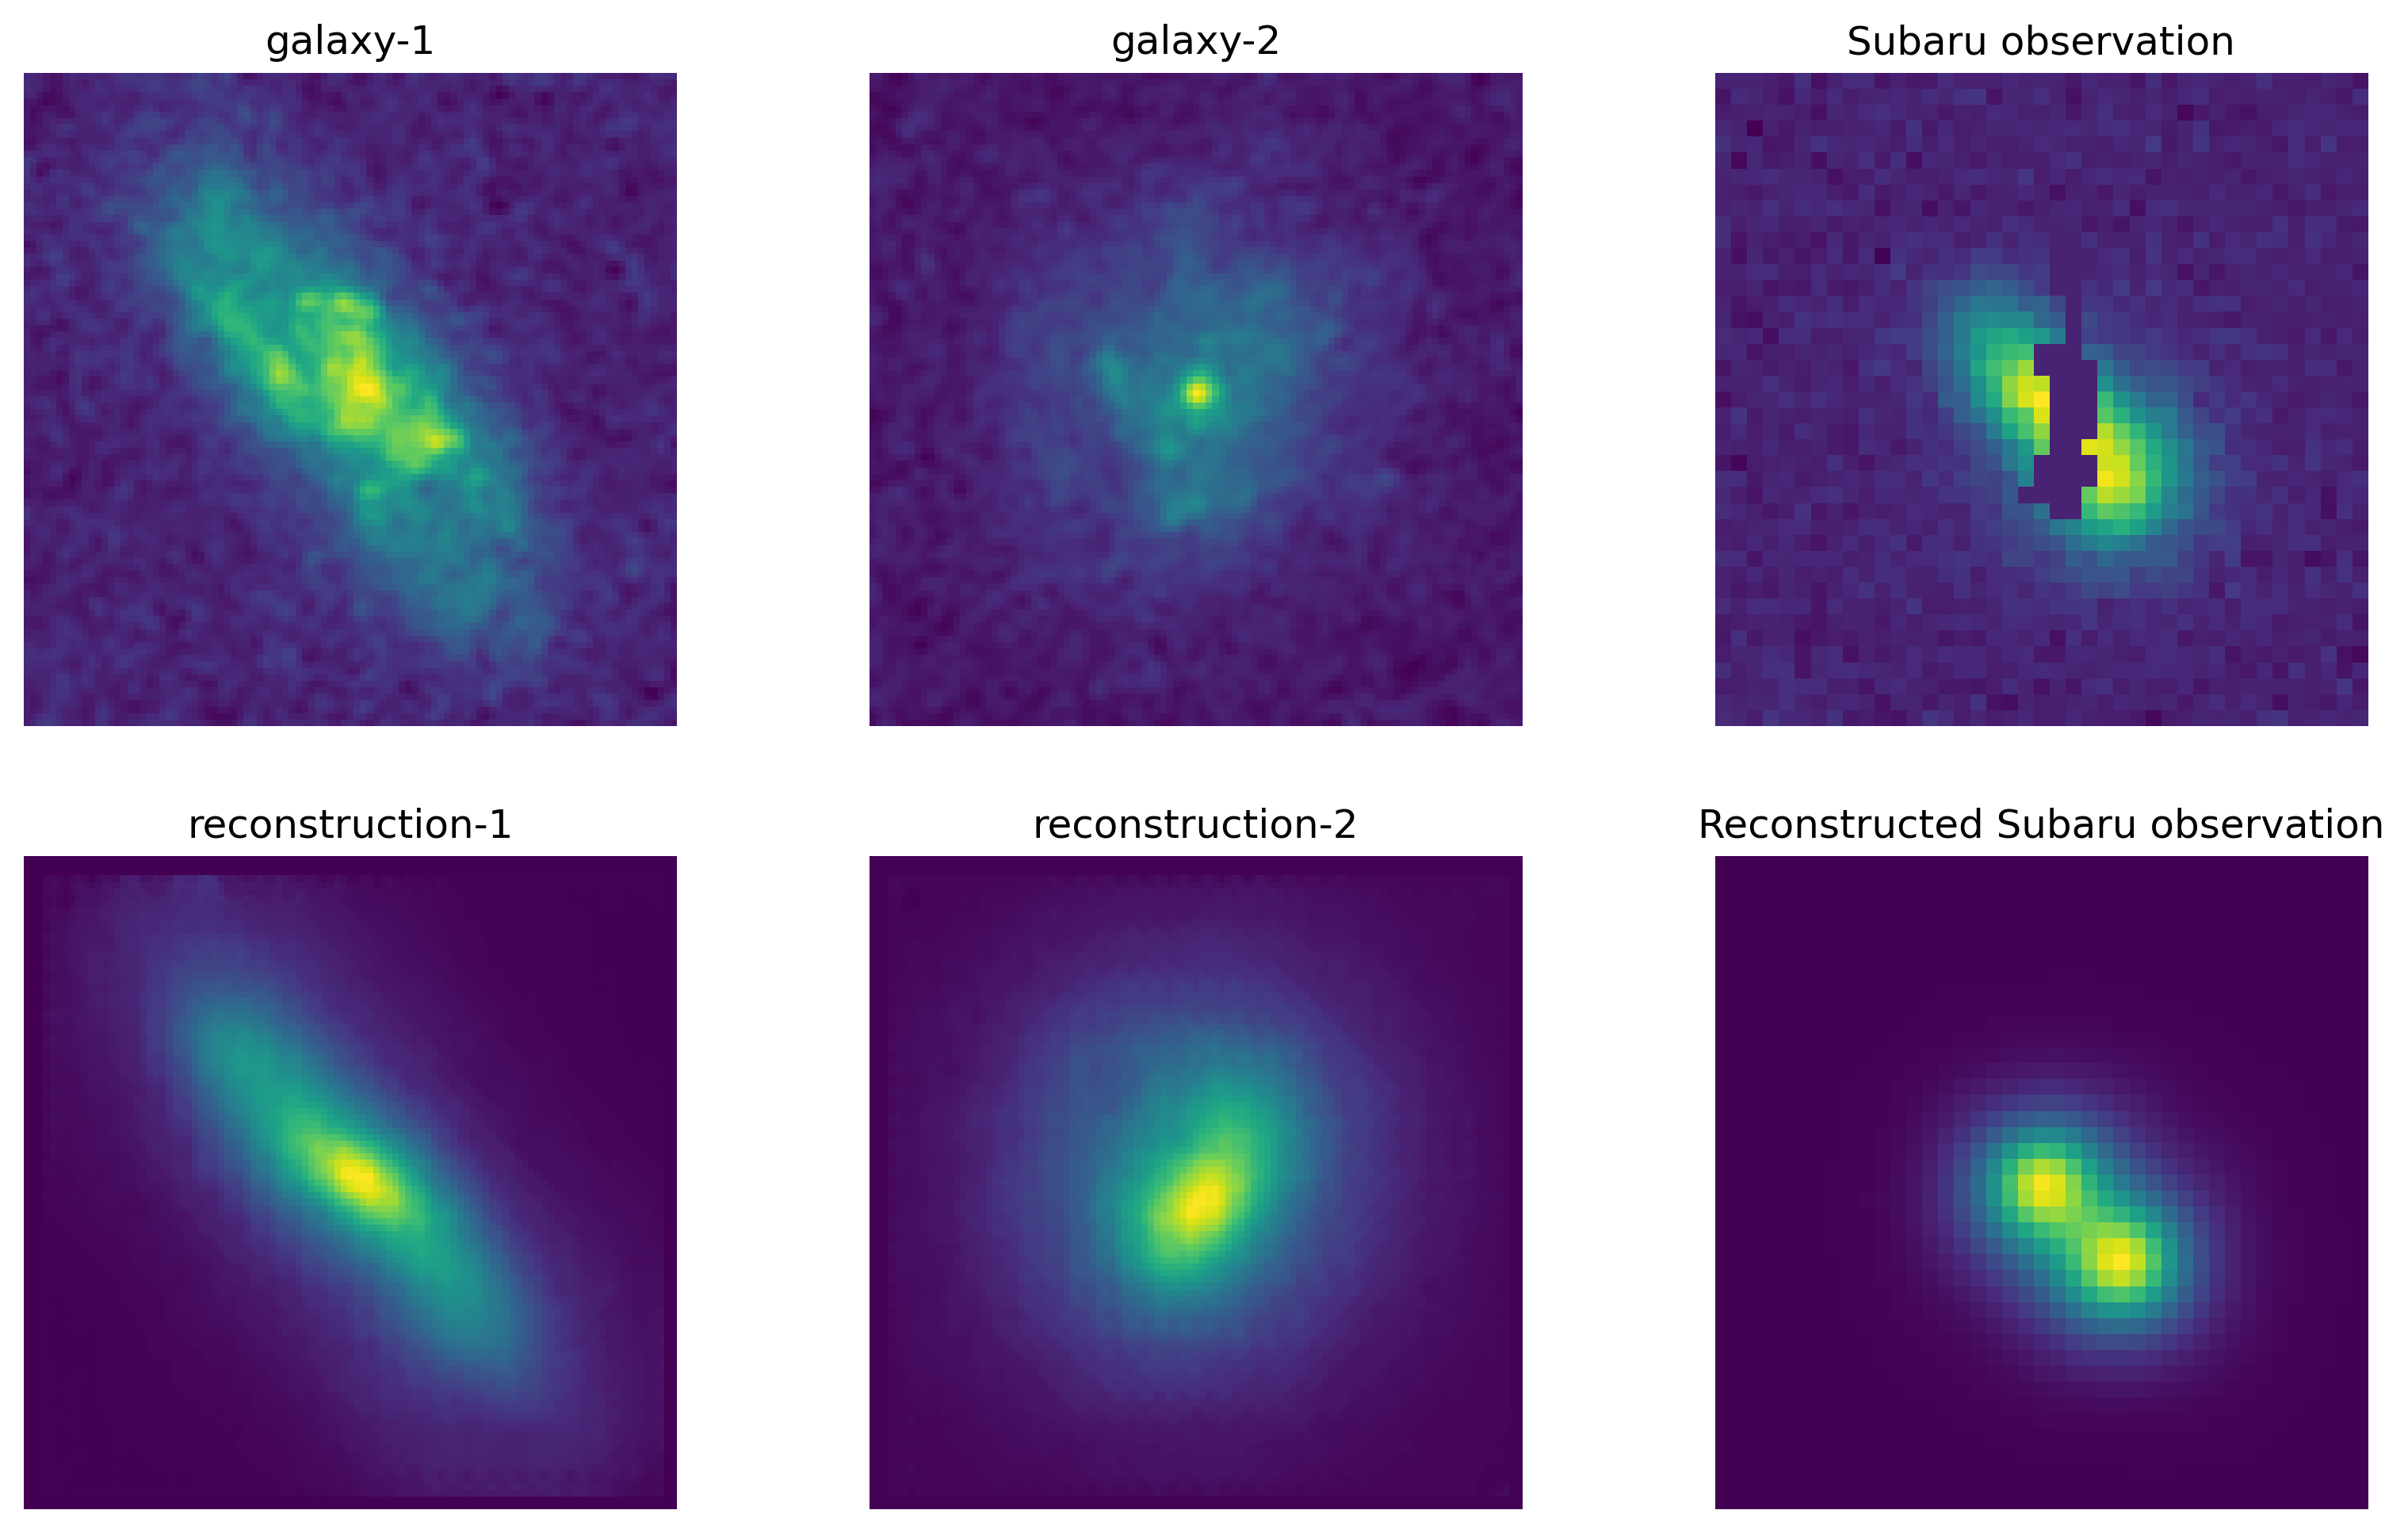

In [124]:
# create 100 samples
z, log_q = q_sample_logp.apply(q_params, next(rng_seq), N=500)
x1,_=generative_model.apply(params_1, state, z[...,0:32])
x2,_=generative_model.apply(params_1, state, z[...,32:64])
im1_ave=jnp.mean(x1,axis=0)
im2_ave=jnp.mean(x2,axis=0)

for i in range(10):
    figure(figsize=[13,8])
    subplot(231)
    imshow(x1_true)
    title('galaxy-1')
    axis('off')
    subplot(232)
    imshow(x2_true)
    title('galaxy-2')
    axis('off')
    subplot(233)
    imshow(y_obs)
    title('Subaru observation')
    axis('off')
    subplot(234)
    imshow(x1[i])
    title('reconstruction-1')
    axis('off')
    subplot(235)
    imshow(x2[i])
    title('reconstruction-2')
    axis('off')
    subplot(236)
    imshow(blending(x1[i],x2[i]))
    title('Reconstructed Subaru observation')
    axis('off')
    #filename='figures/figure1_'+str(i)+'.png'
    #plt.savefig(filename)
#save()

/home/dkn16/.local/lib/python3.7/site-packages/jax/_src/numpy/lax_numpy.py:6576: UserWarning: Explicitly requested dtype int64 requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  lax._check_user_dtype_supported(dtype, "astype")
/home/dkn16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


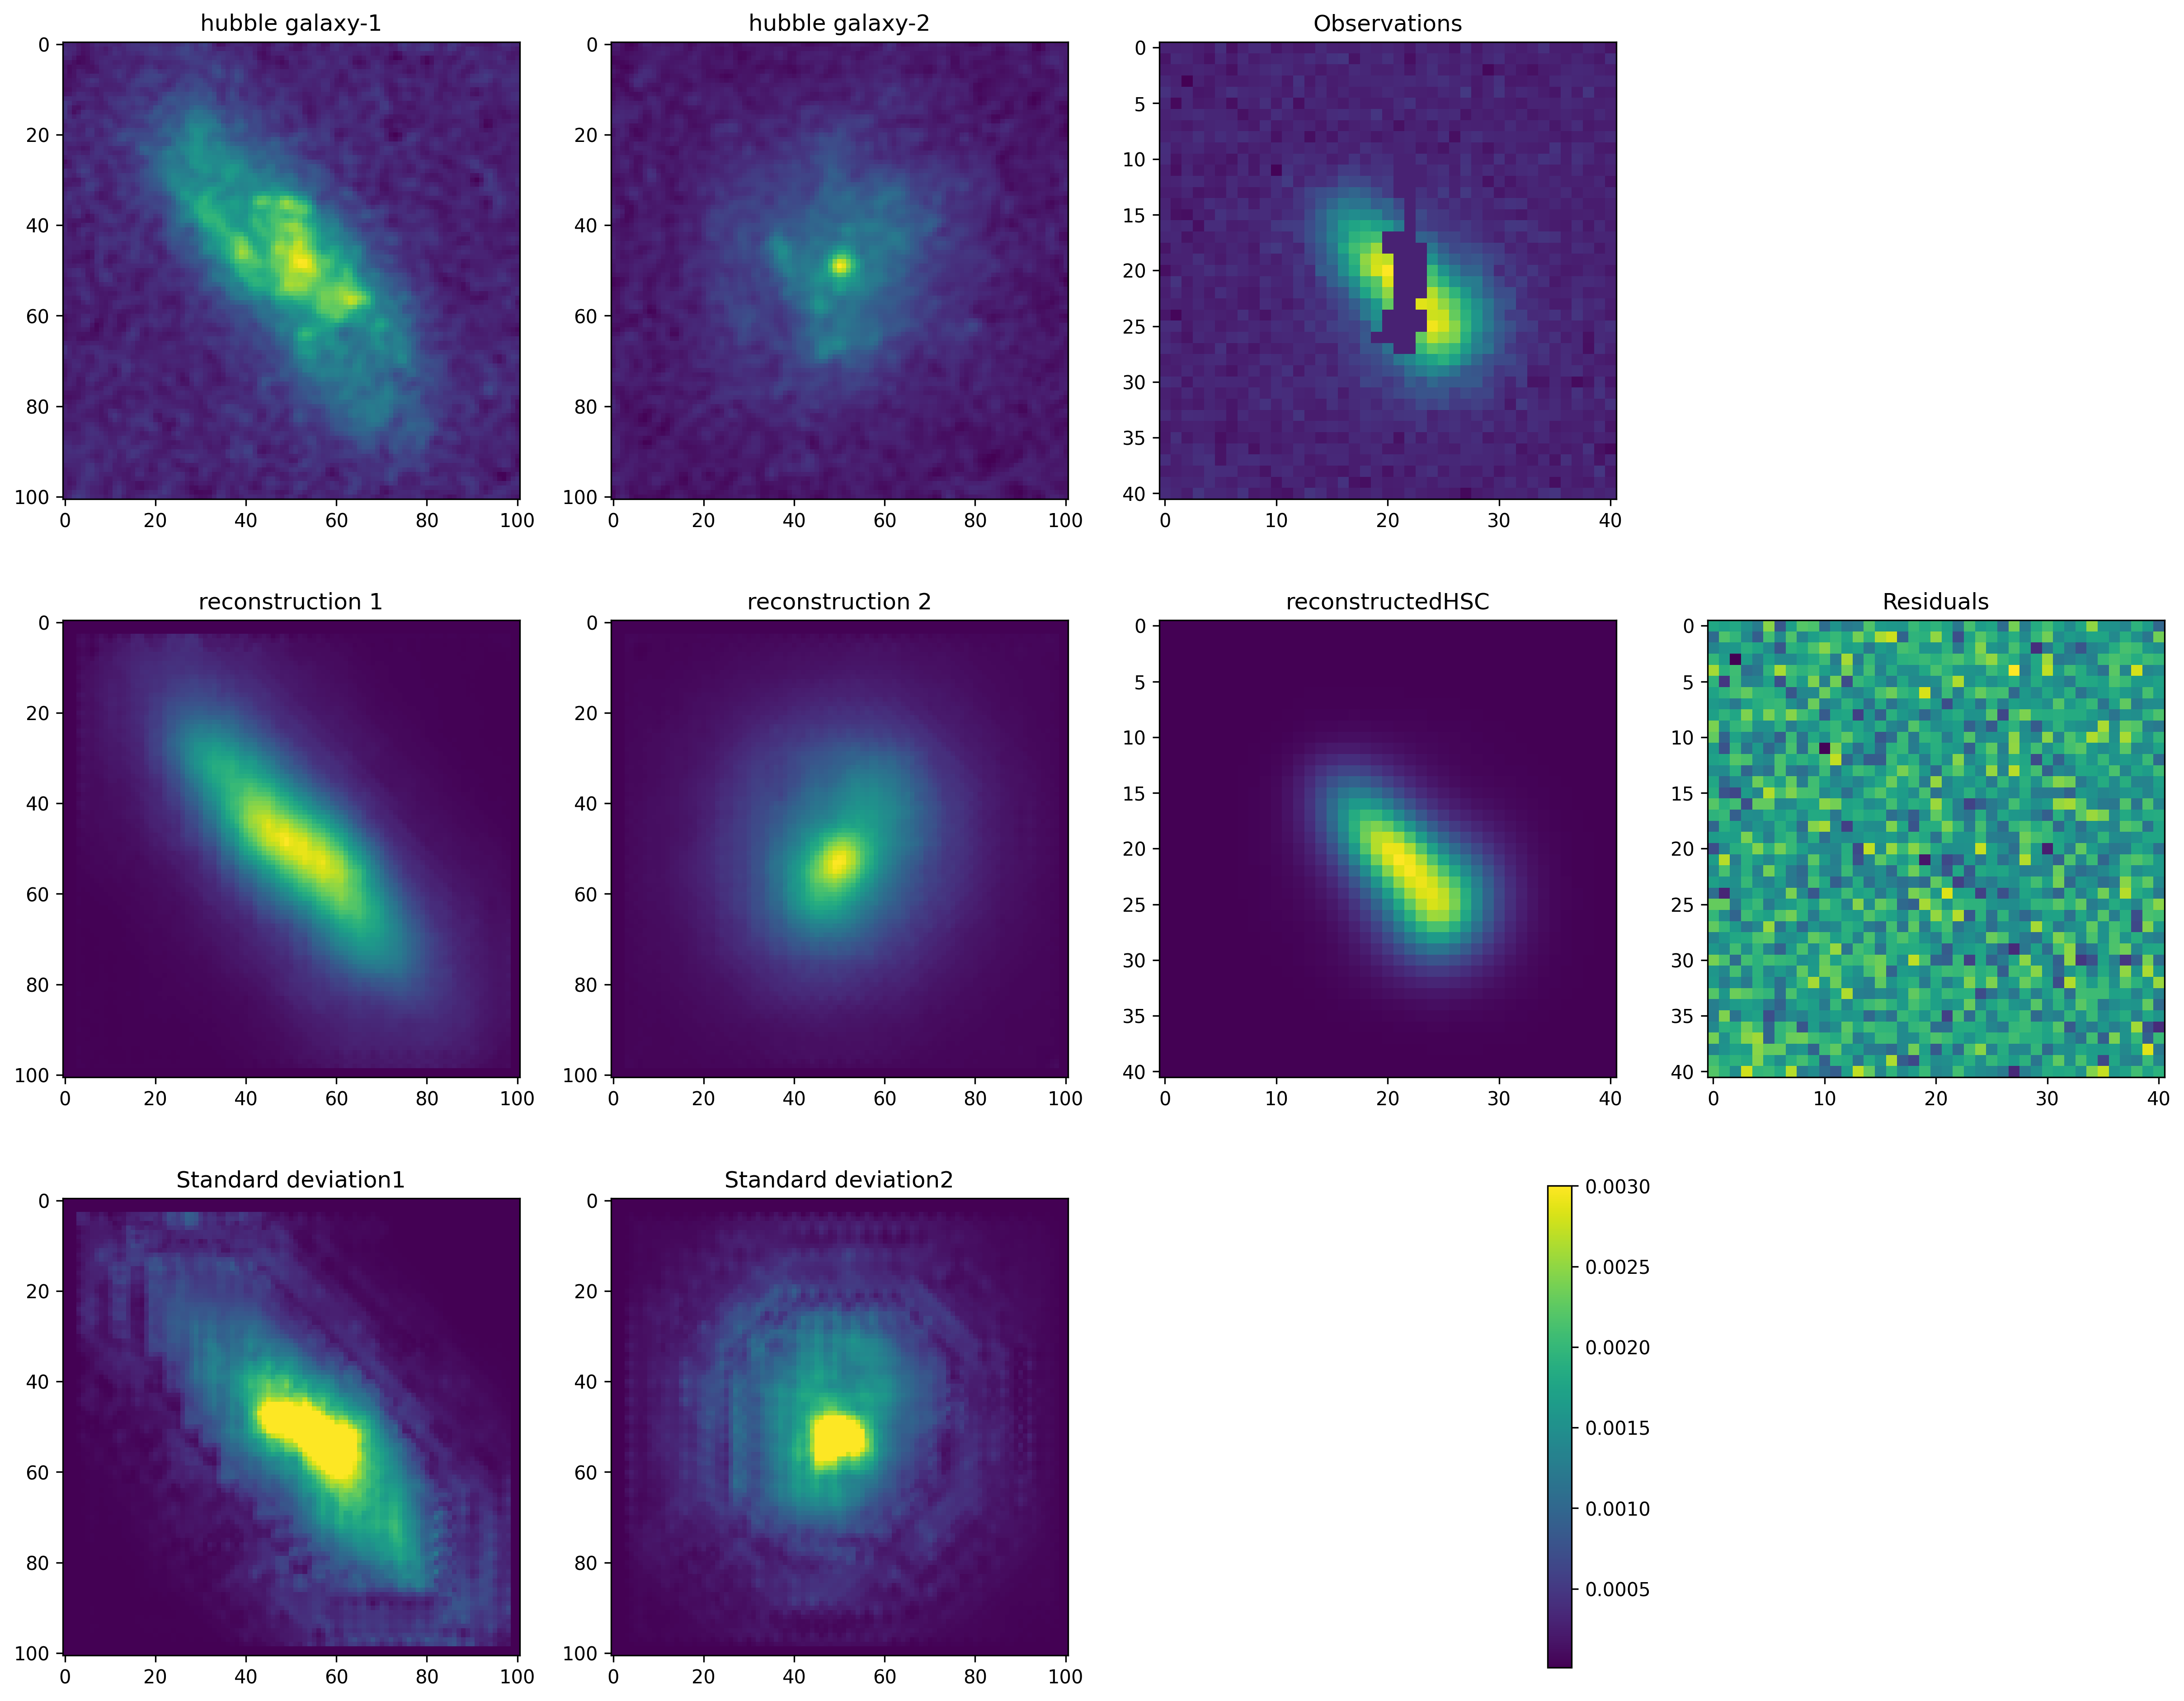

In [133]:
# create 100 samples
z, log_q = q_sample_logp.apply(q_params, next(rng_seq), N=500)
x1,_=generative_model.apply(params_1, state, z[...,0:32])
x2,_=generative_model.apply(params_1, state, z[...,32:64])

from matplotlib import colors
fig=figure(figsize=[20,16])
x1ave=jnp.mean(x1,axis=0)
x2ave=jnp.mean(x2,axis=0)
subplot(341)
imshow(x1_true)
title('hubble galaxy-1')
subplot(342)
imshow(x2_true)
title('hubble galaxy-2')
subplot(343)
imshow(y_obs)
title('Observations')
subplot(345)
imshow(x1ave)
title('reconstruction 1')
subplot(346)
imshow(x2ave)
title('reconstruction 2')
subplot(347)
imshow(blendingHSC(x1ave,x2ave))
title('reconstructedHSC')
subplot(348)
imshow(im_noise-blendingHSC(x1ave,x2ave))
title('Residuals')
subplot(349)
im=imshow(jnp.std(x1,axis=0),vmax=3e-3,vmin=1e-5)
title('Standard deviation1')
subplot(3,4,10)
imshow(jnp.std(x2,axis=0),vmax=3e-3,vmin=1e-5)
title('Standard deviation2')
subplot(3,4,11)
axis('off')
colorbar(im)





In [31]:
# code to make a mp4 file
import cv2,os
image_folder = 'figures/'
video_name = 'compare_deblending.mp4'

images = [f'figure1_{i}_vi.png' for i in range(100)]
frame = cv2.imread(os.path.join(image_folder, images[0]))
height, width, layers = frame.shape

video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'MP4V'), 10, (width,height))

for image in images:
    video.write(cv2.imread(os.path.join(image_folder, image)))

cv2.destroyAllWindows()
video.release()

In [84]:
# decide to build a MCMC
#First we import some dependencies
from tensorflow_probability.substrates import jax as tfp
@jax.jit
def blending(z1, z2):
    im1, _ = generative_model.apply(params, state, z1)
    im2, _ = generative_model.apply(params, state, z2)
    im_hsc1 = simulate_hsc(im1[0], cosmos1['psf'], hsc['psf'])
    im_hsc2 = simulate_hsc(im2[0], cosmos2['psf'], hsc['psf'])
    im_hsc2 = jnp.roll(jnp.roll(im_hsc2, 5, axis=1), 5, axis=0)
    im_blended = im_hsc1 + im_hsc2
    likelihood = tfd.Independent(tfd.Normal(loc=im_blended,
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) 
    return likelihood.mean()

@jax.jit
def log_probz(z):
    x=blending(z[0:32],z[32:64])
    prior=tfd.Independent(tfd.Normal(jnp.zeros(64), jnp.zeros(64)+1), # We add a high noise component in mask
                             reinterpreted_batch_ndims=1)
    likelihood = tfd.Independent(tfd.Normal(x,
                                            jnp.sqrt(hsc['variance'] + cr_mask*1e3)), # We add a high noise component in mask
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)+prior.log_prob(z)



#The log probability function we use is still the one we use before
num_results = int(2*1e3)
num_burnin_steps = int(1e4)
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_probz,
    num_leapfrog_steps=2,
    step_size=5*1e-4)
kernel = tfp.mcmc.SimpleStepSizeAdaptation(
    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [85]:
#define a initial state
z_mc = tfd.MultivariateNormalDiag(jnp.zeros(64), scale_identity_multiplier=1).sample(4, seed=next(rng_seq))
print(type(z_mc))

#define function running

def run_chain():
  # Run the chain (with burn-in).
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=z_mc[0],
      kernel=kernel,
      trace_fn=lambda _,results: results.inner_results.accepted_results.target_log_prob,seed=random.PRNGKey(0))

 


<class 'jaxlib.xla_extension.DeviceArray'>


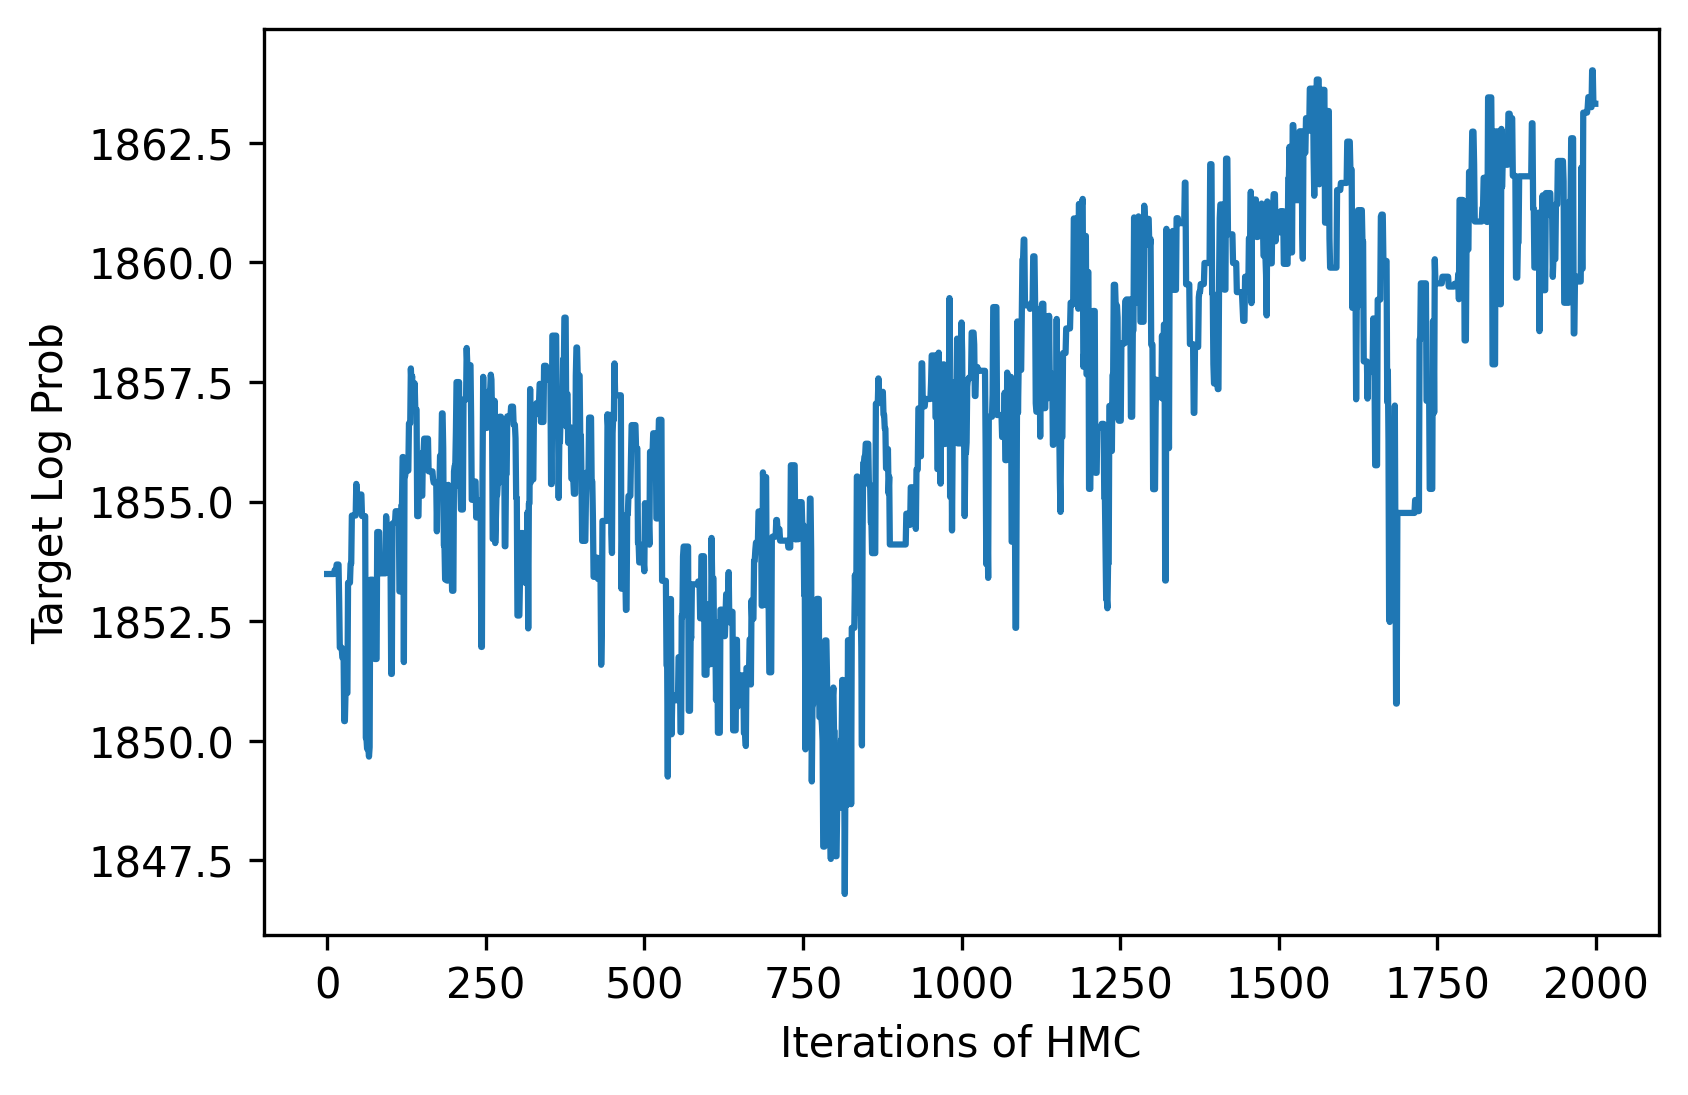

CPU times: user 2min, sys: 985 ms, total: 2min 1s
Wall time: 1min 38s


In [86]:
%%time
states, log_probs= run_chain()

plt.figure()
plt.plot(log_probs)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of HMC')
plt.show()

In [35]:
log_probs.inner_results.accepted_results.target_log_prob

MetropolisHastingsKernelResults(
  accepted_results=UncalibratedHamiltonianMonteCarloKernelResults(
      log_acceptance_correction=DeviceArray([-6.10041046e+00, -1.64596939e+00, -8.15818787e-01,
                      5.95676422e-01, -5.82703972e+00, -1.96449280e-01,
                     -1.97119141e+00, -4.20931625e+00, -3.35035706e+00,
                     -7.35054016e-02, -1.93696022e+00, -1.22500610e+00,
                     -1.95031357e+00, -1.19681358e+00, -3.14897537e-01,
                     -3.55423737e+00, -4.60995865e+00,  3.09616089e-01,
                     -3.28906059e+00, -5.18316269e+00, -3.56333542e+00,
                      5.39665222e-01, -3.30930138e+00, -1.69203949e+00,
                      7.43663788e-01, -9.91790771e-01, -5.35501862e+00,
                      8.98017883e-01, -2.50791550e-01, -4.97131348e-01,
                     -6.32209778e-02, -2.12207413e+00, -3.32279015e+00,
                     -1.38275146e+00,  1.94976807e-01, -2.52546310e-01,
            

In [41]:
states[100]


DeviceArray([-0.9024898 , -0.39645118,  0.40206647,  1.0550215 ,
             -1.5445597 ,  1.5212328 ,  0.12210163, -0.6574543 ,
              0.55065244,  1.4238782 ,  0.5306439 ,  1.6303589 ,
              0.05293818, -0.38749033,  0.66514844, -0.5162685 ,
             -0.28246006,  1.6512738 ,  0.32551566,  0.5188928 ,
              1.5569401 , -2.4650028 , -0.5422394 ,  0.03444269,
             -0.63159263,  1.0006858 ,  0.08782329,  1.4420577 ,
             -0.21179307,  0.09891612,  0.10718516, -0.3726352 ,
             -0.5524732 ,  0.69872457, -0.25502023, -1.1791751 ,
             -0.2706468 ,  2.005402  ,  1.4496692 , -0.46107057,
              1.7415549 , -1.1786197 ,  0.02096067,  0.9437805 ,
             -0.5743017 ,  0.7027832 , -0.19524825,  1.7924137 ,
             -1.4891343 , -0.26774997,  0.6519246 , -1.2225467 ,
              0.95909506,  1.9486843 ,  1.4237221 ,  2.5059817 ,
              0.40298146, -0.83463776,  0.08307628,  0.7368297 ,
              1.3218764 ,

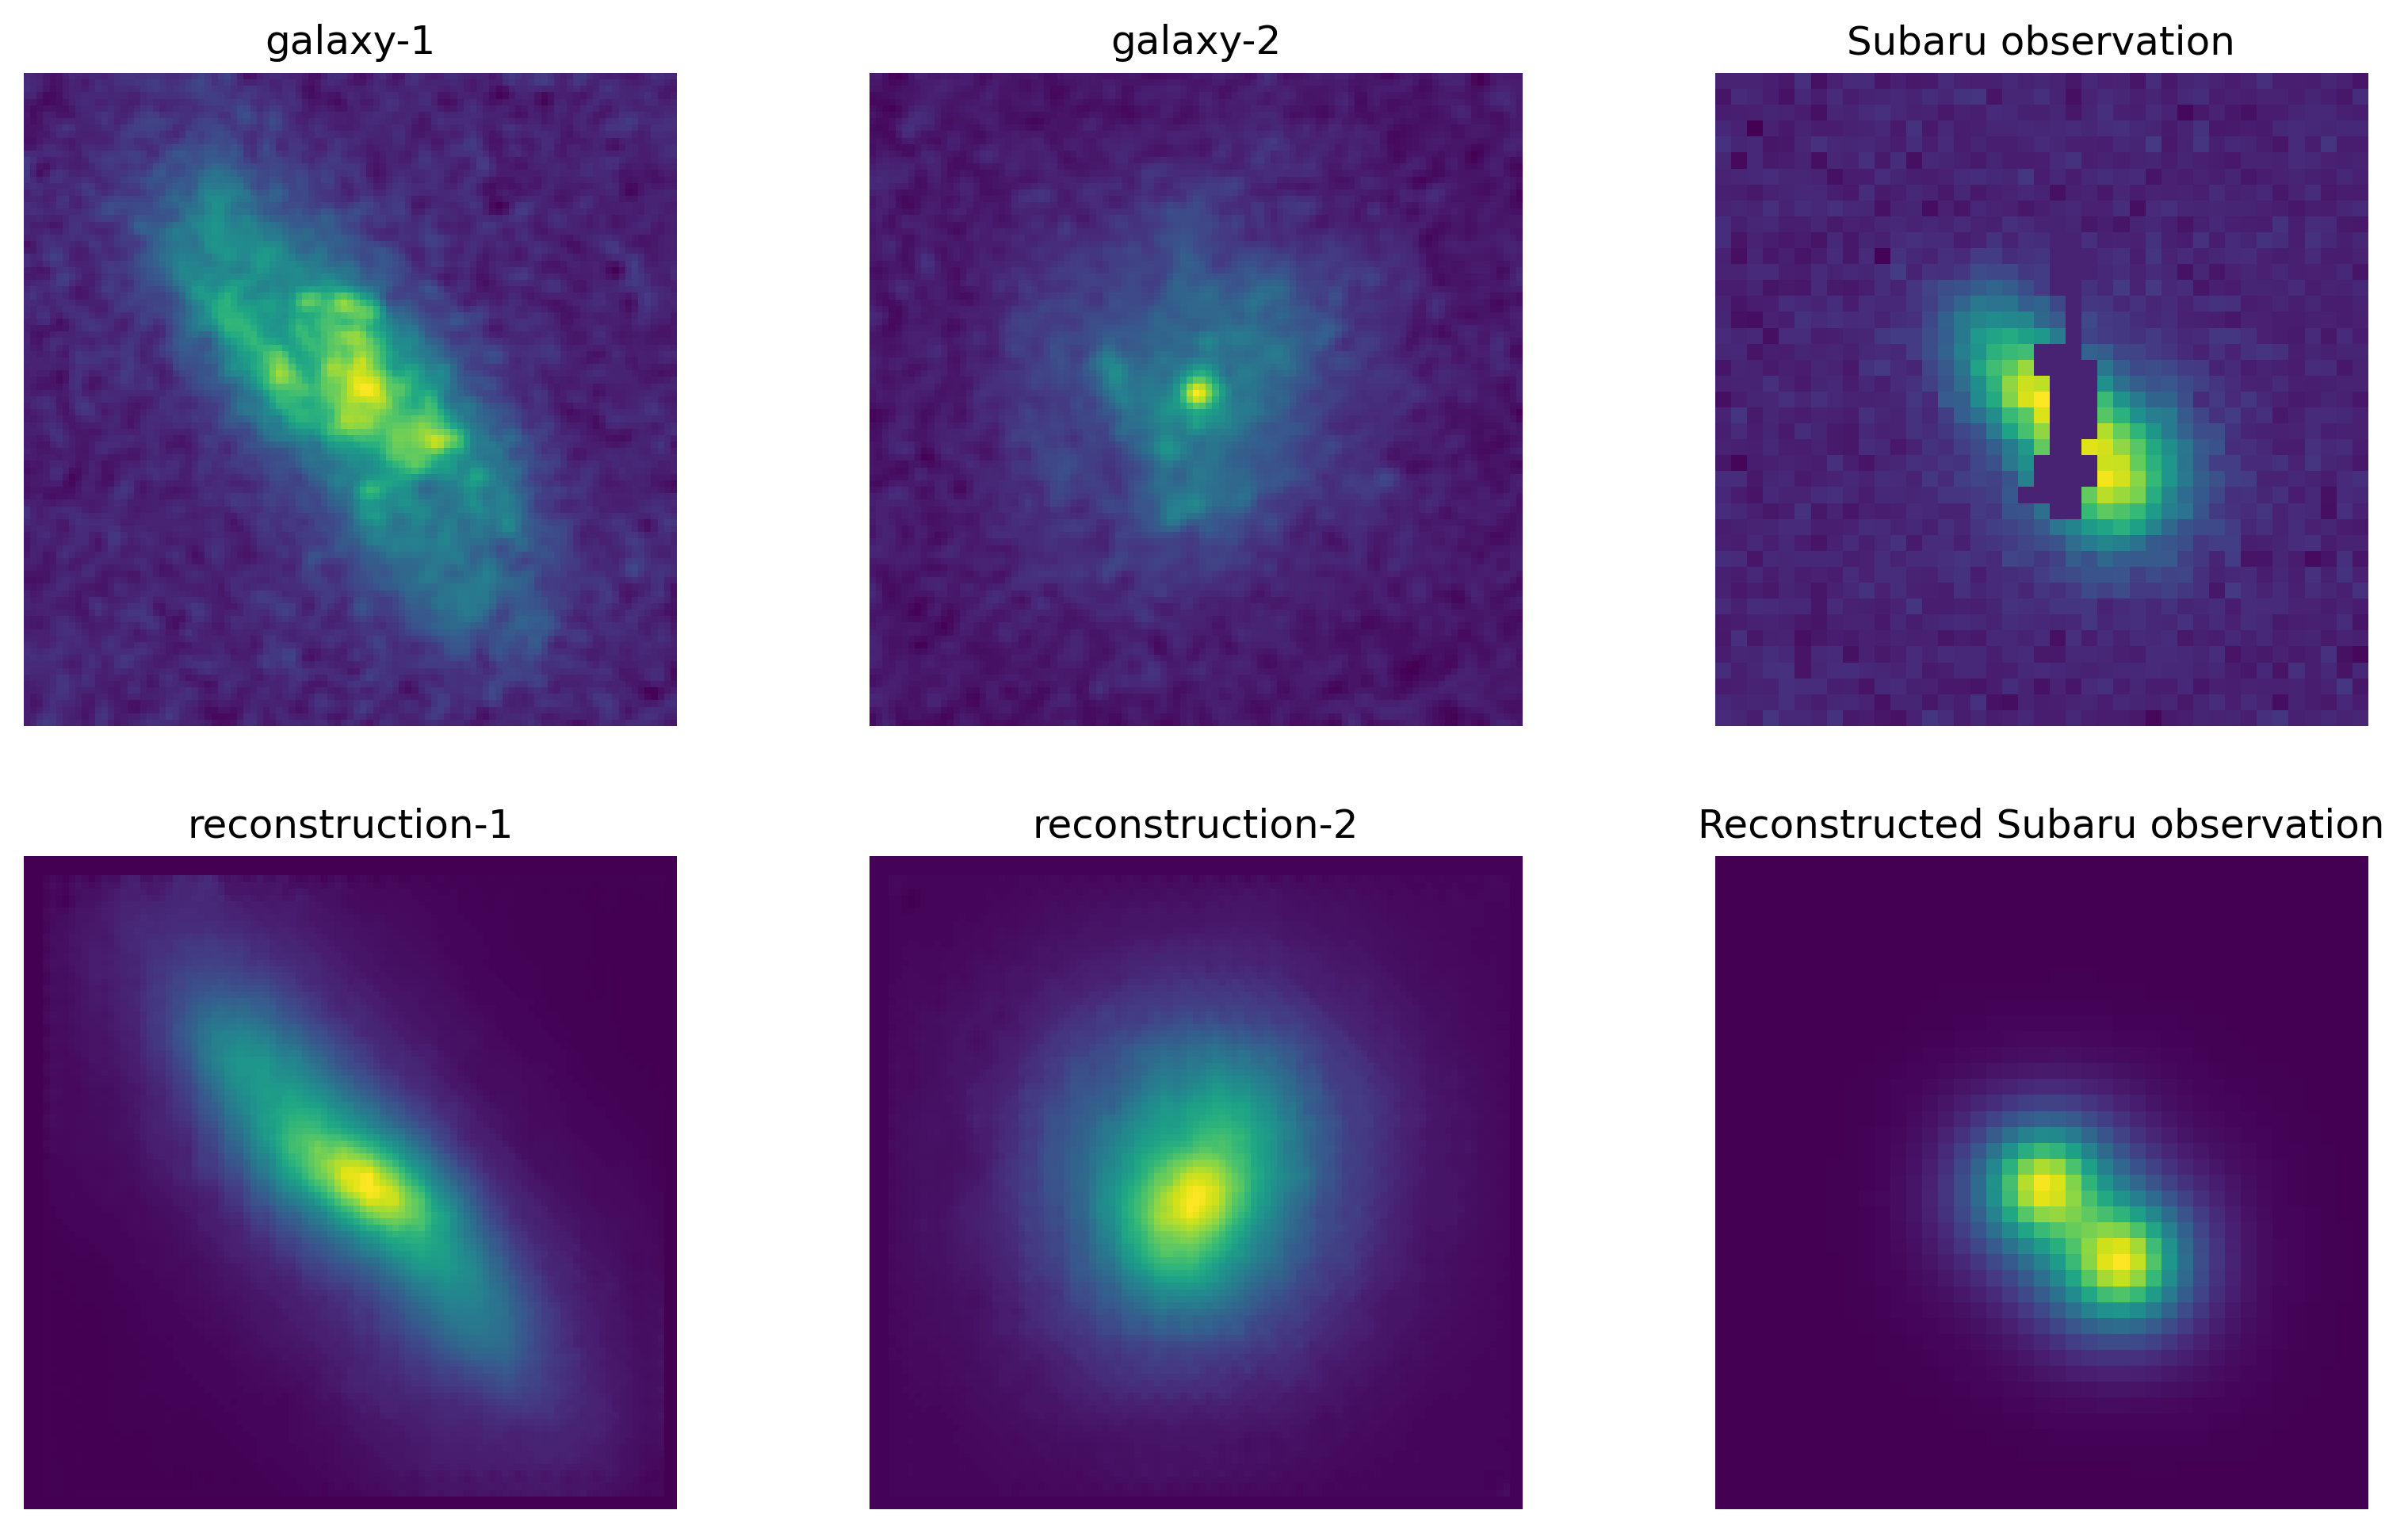

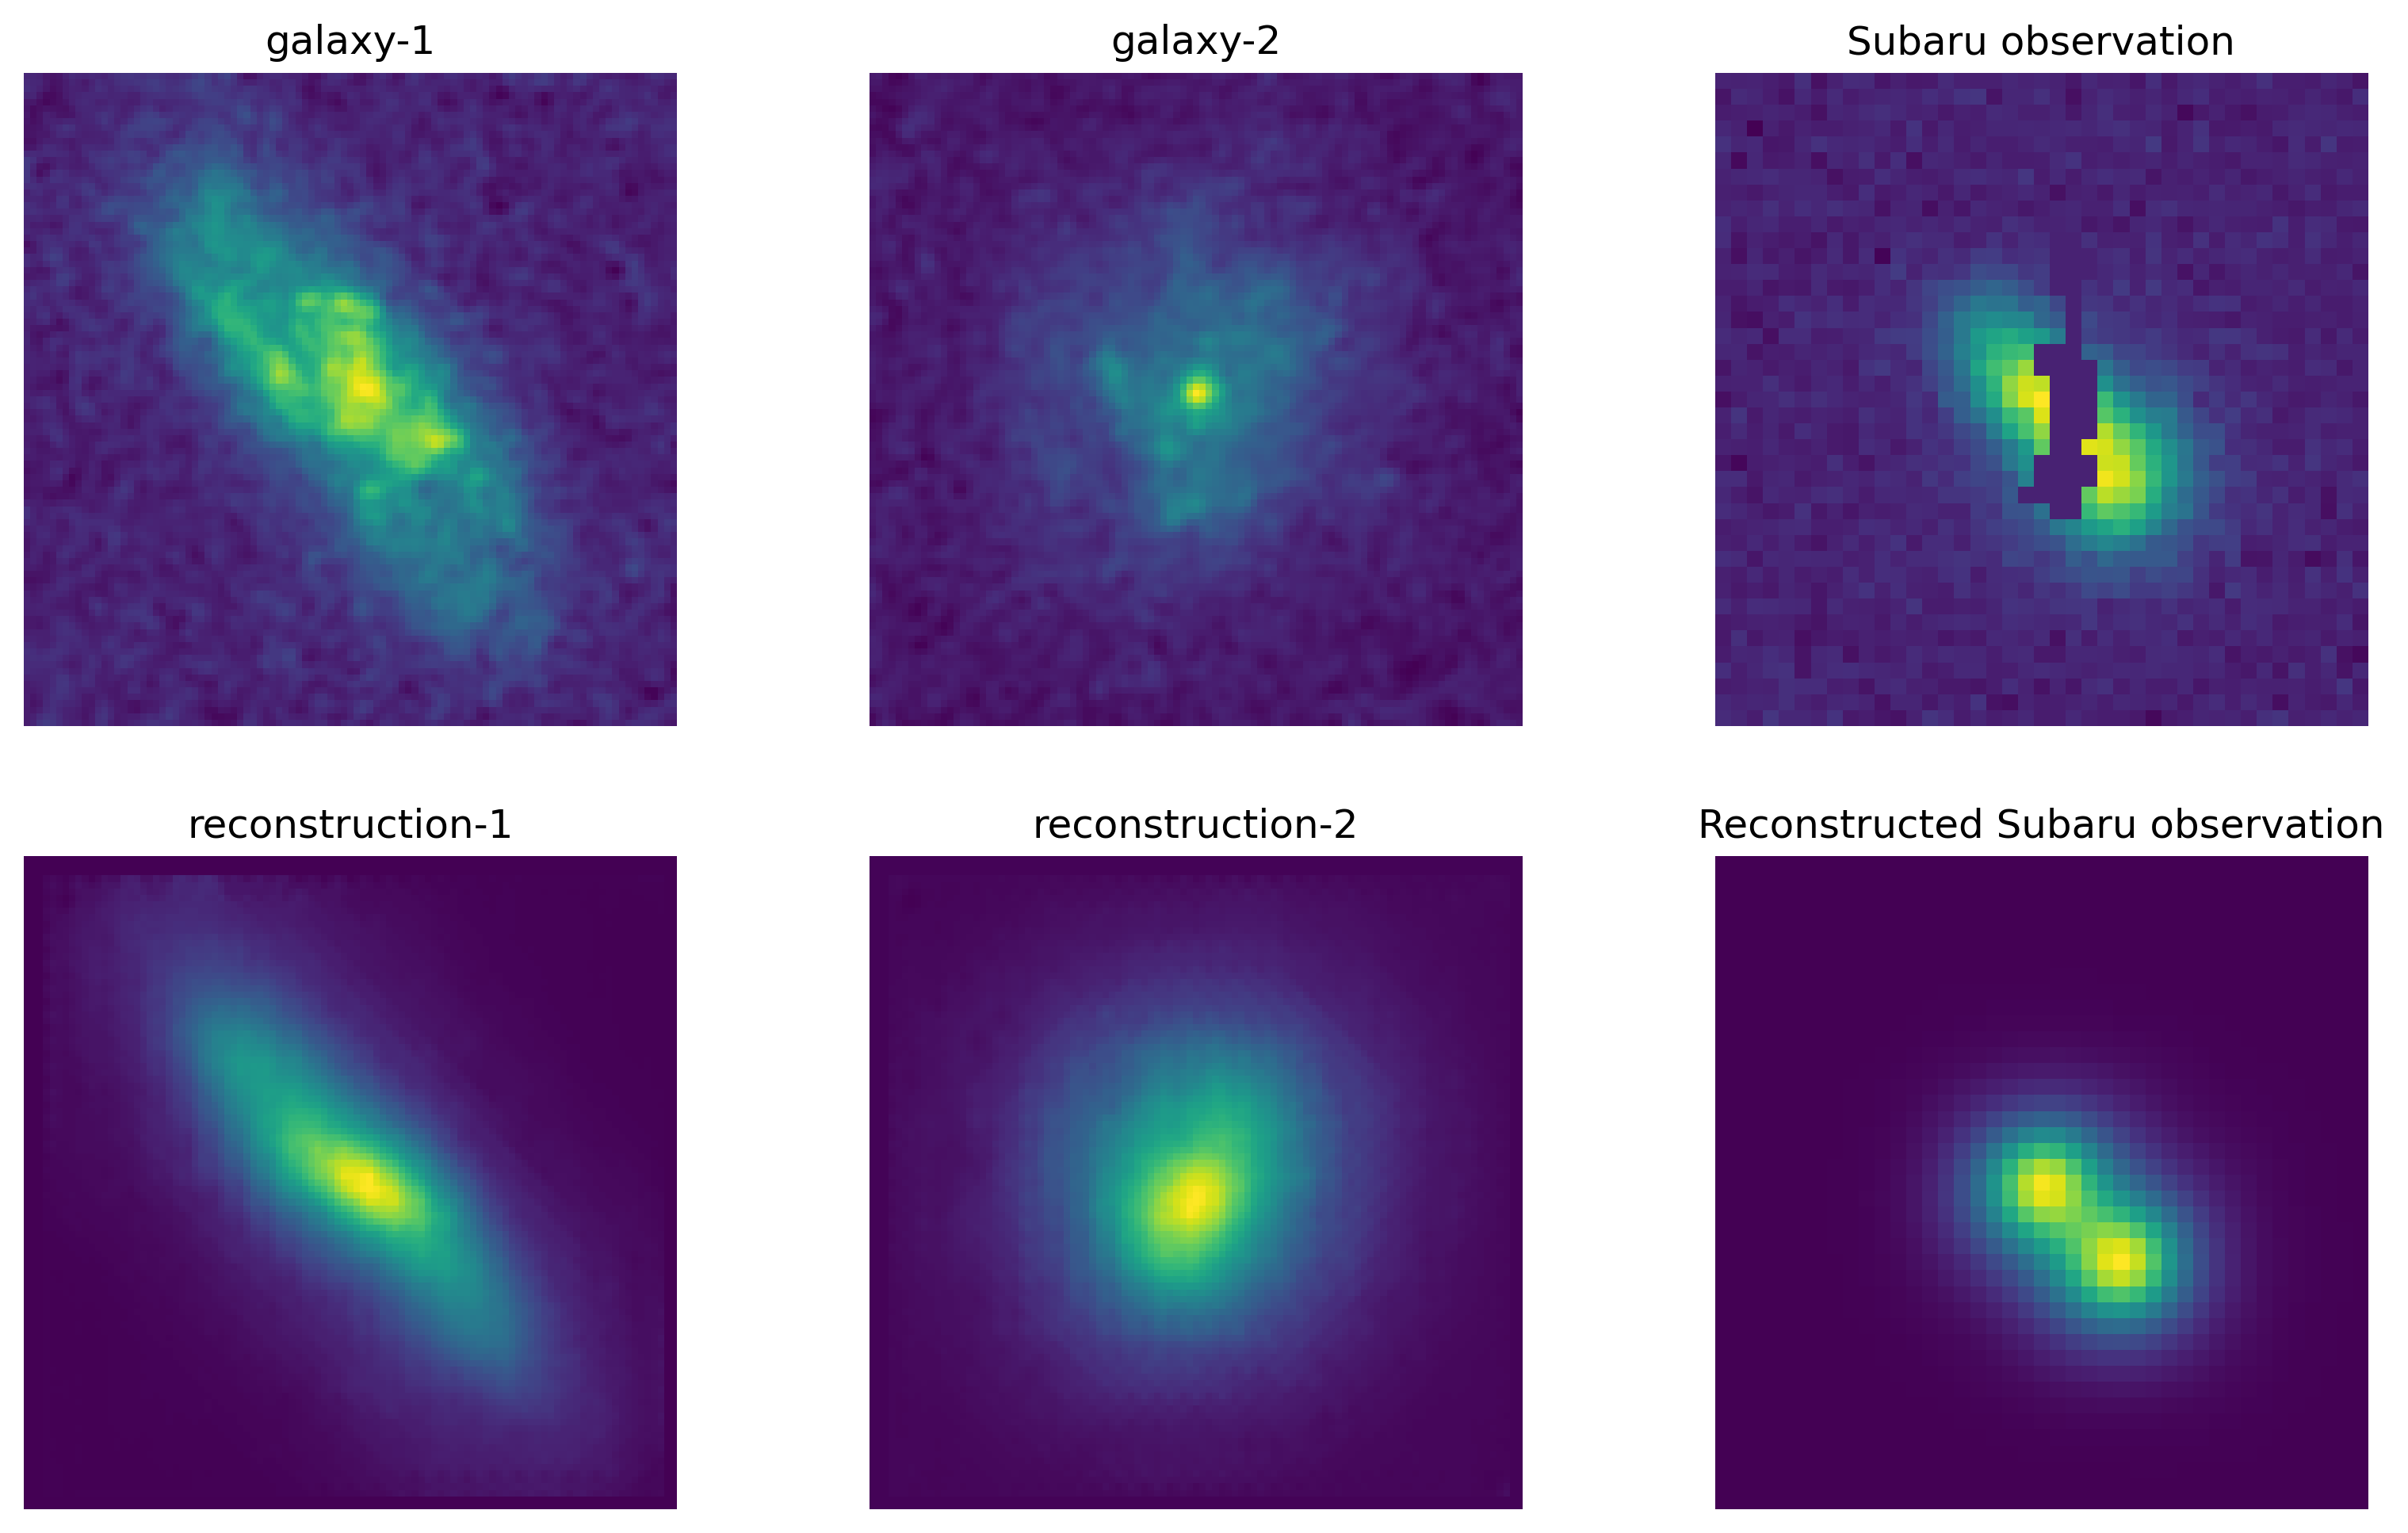

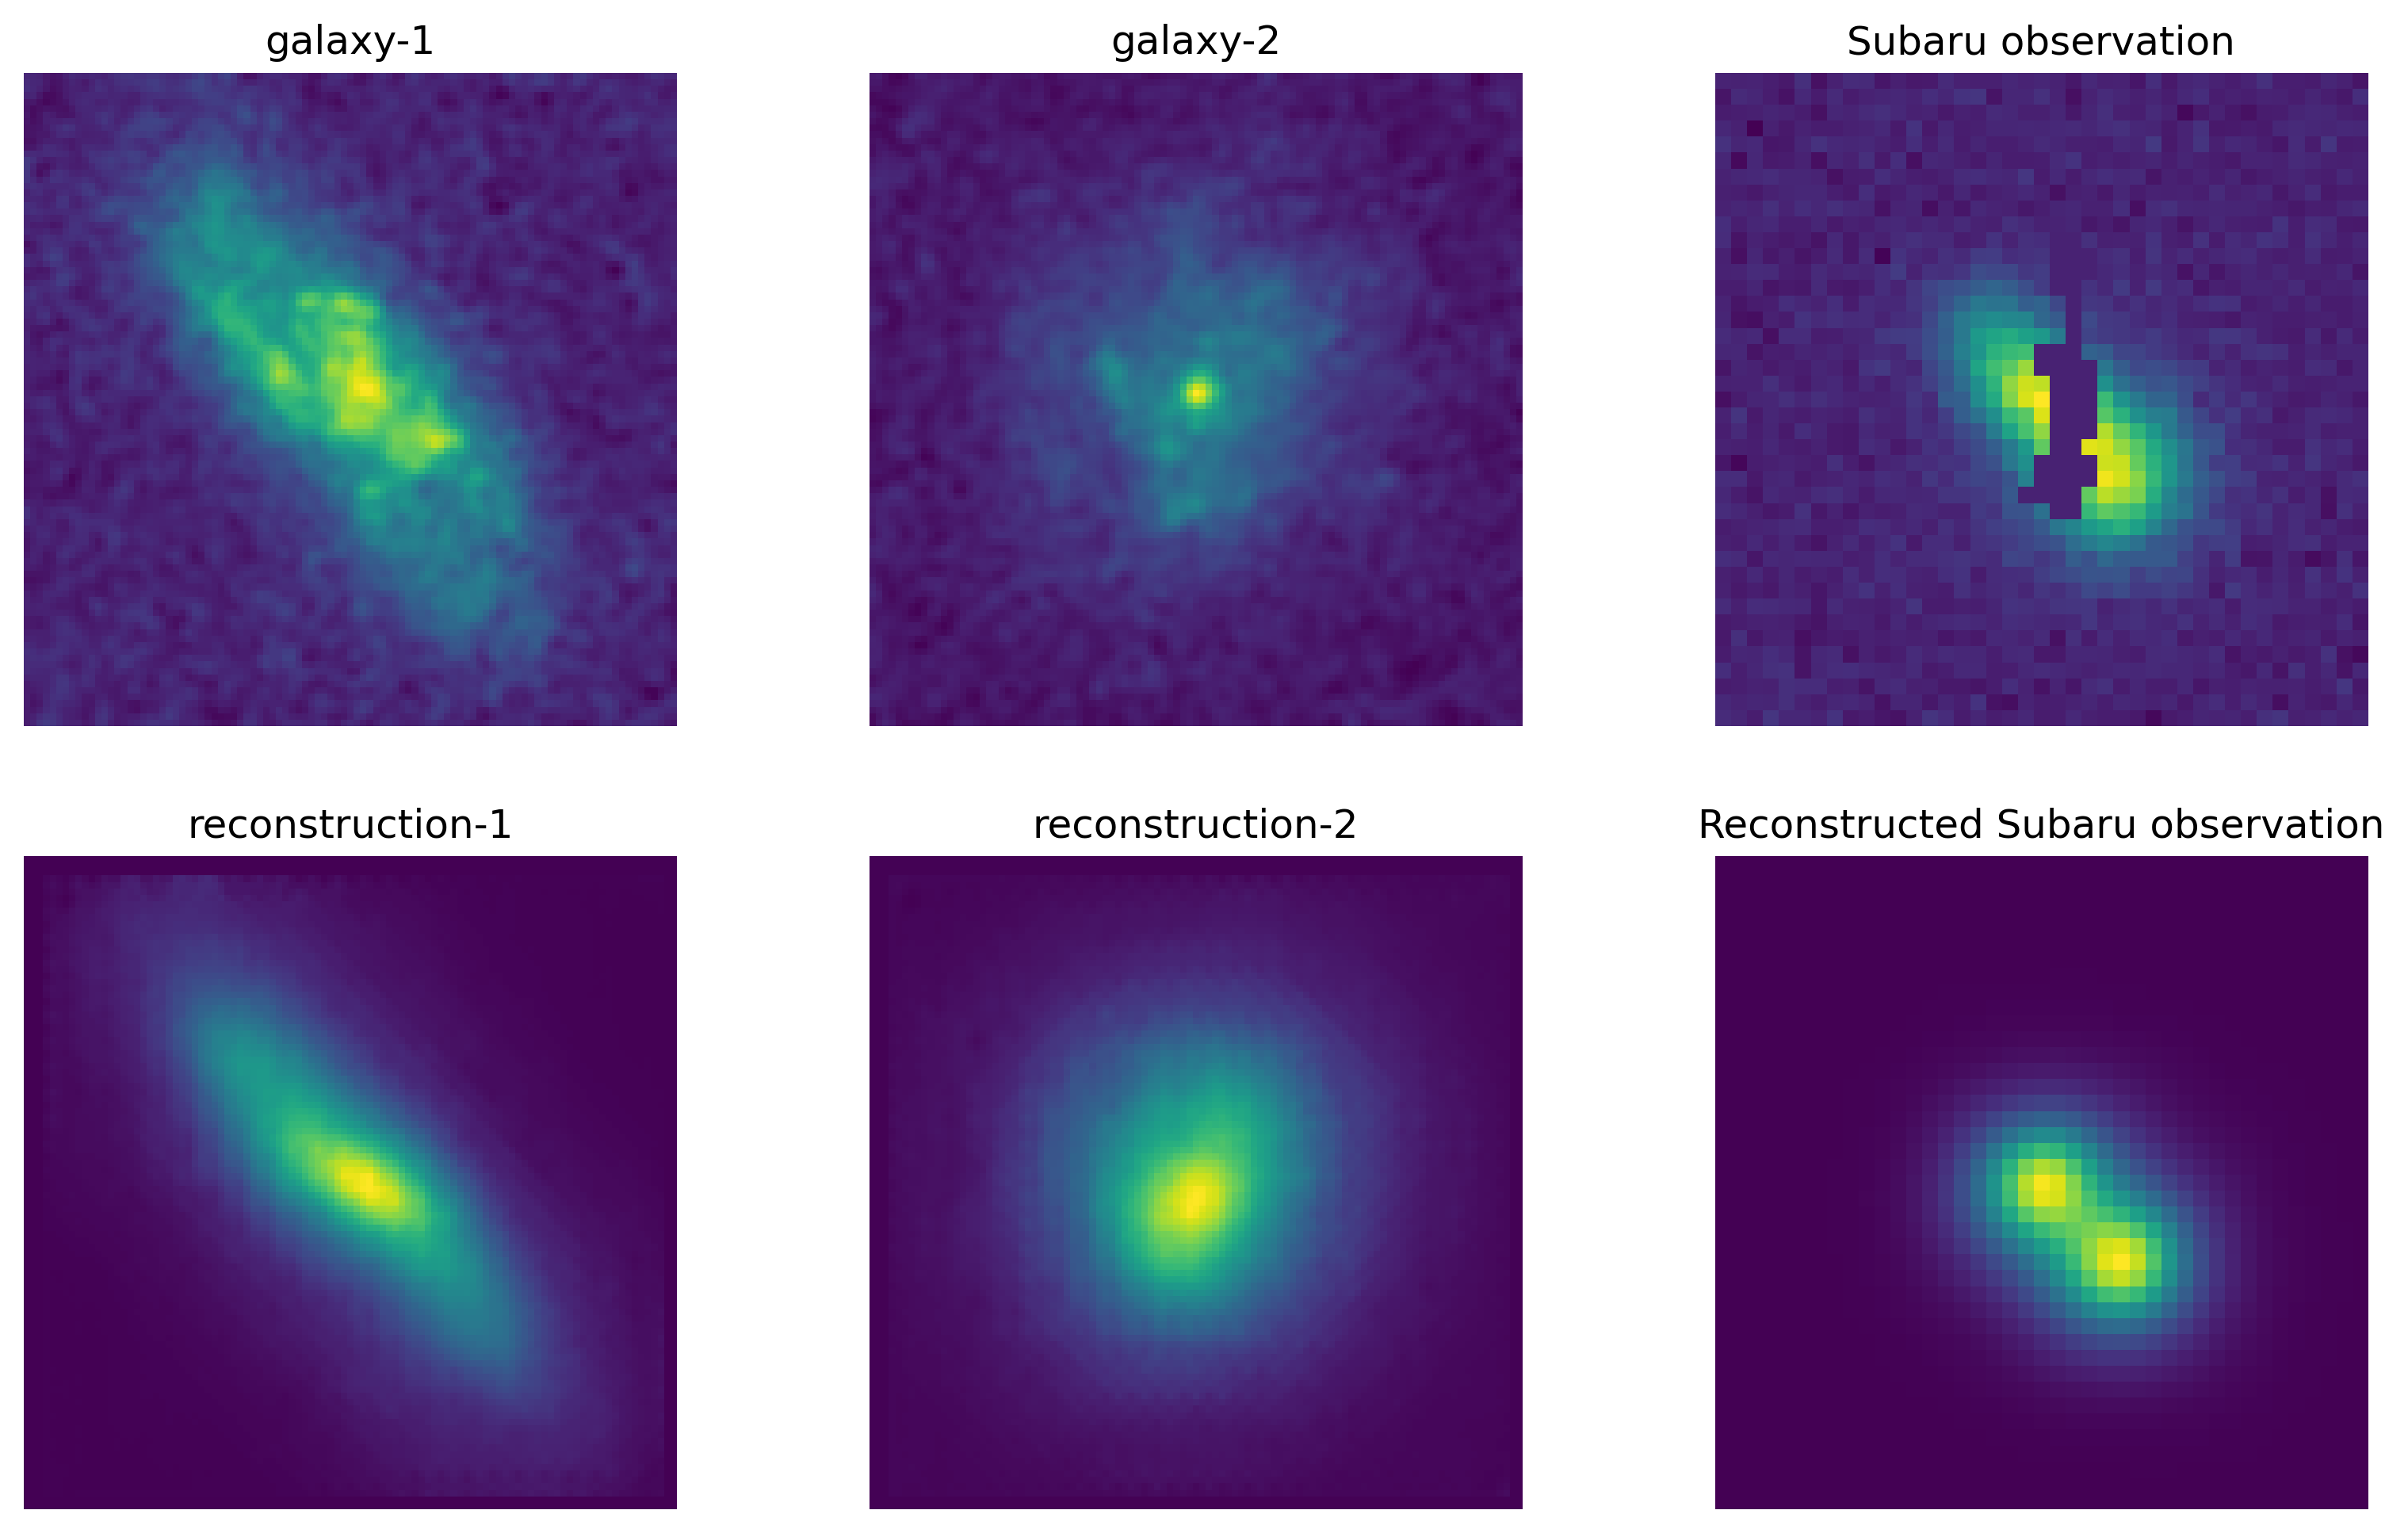

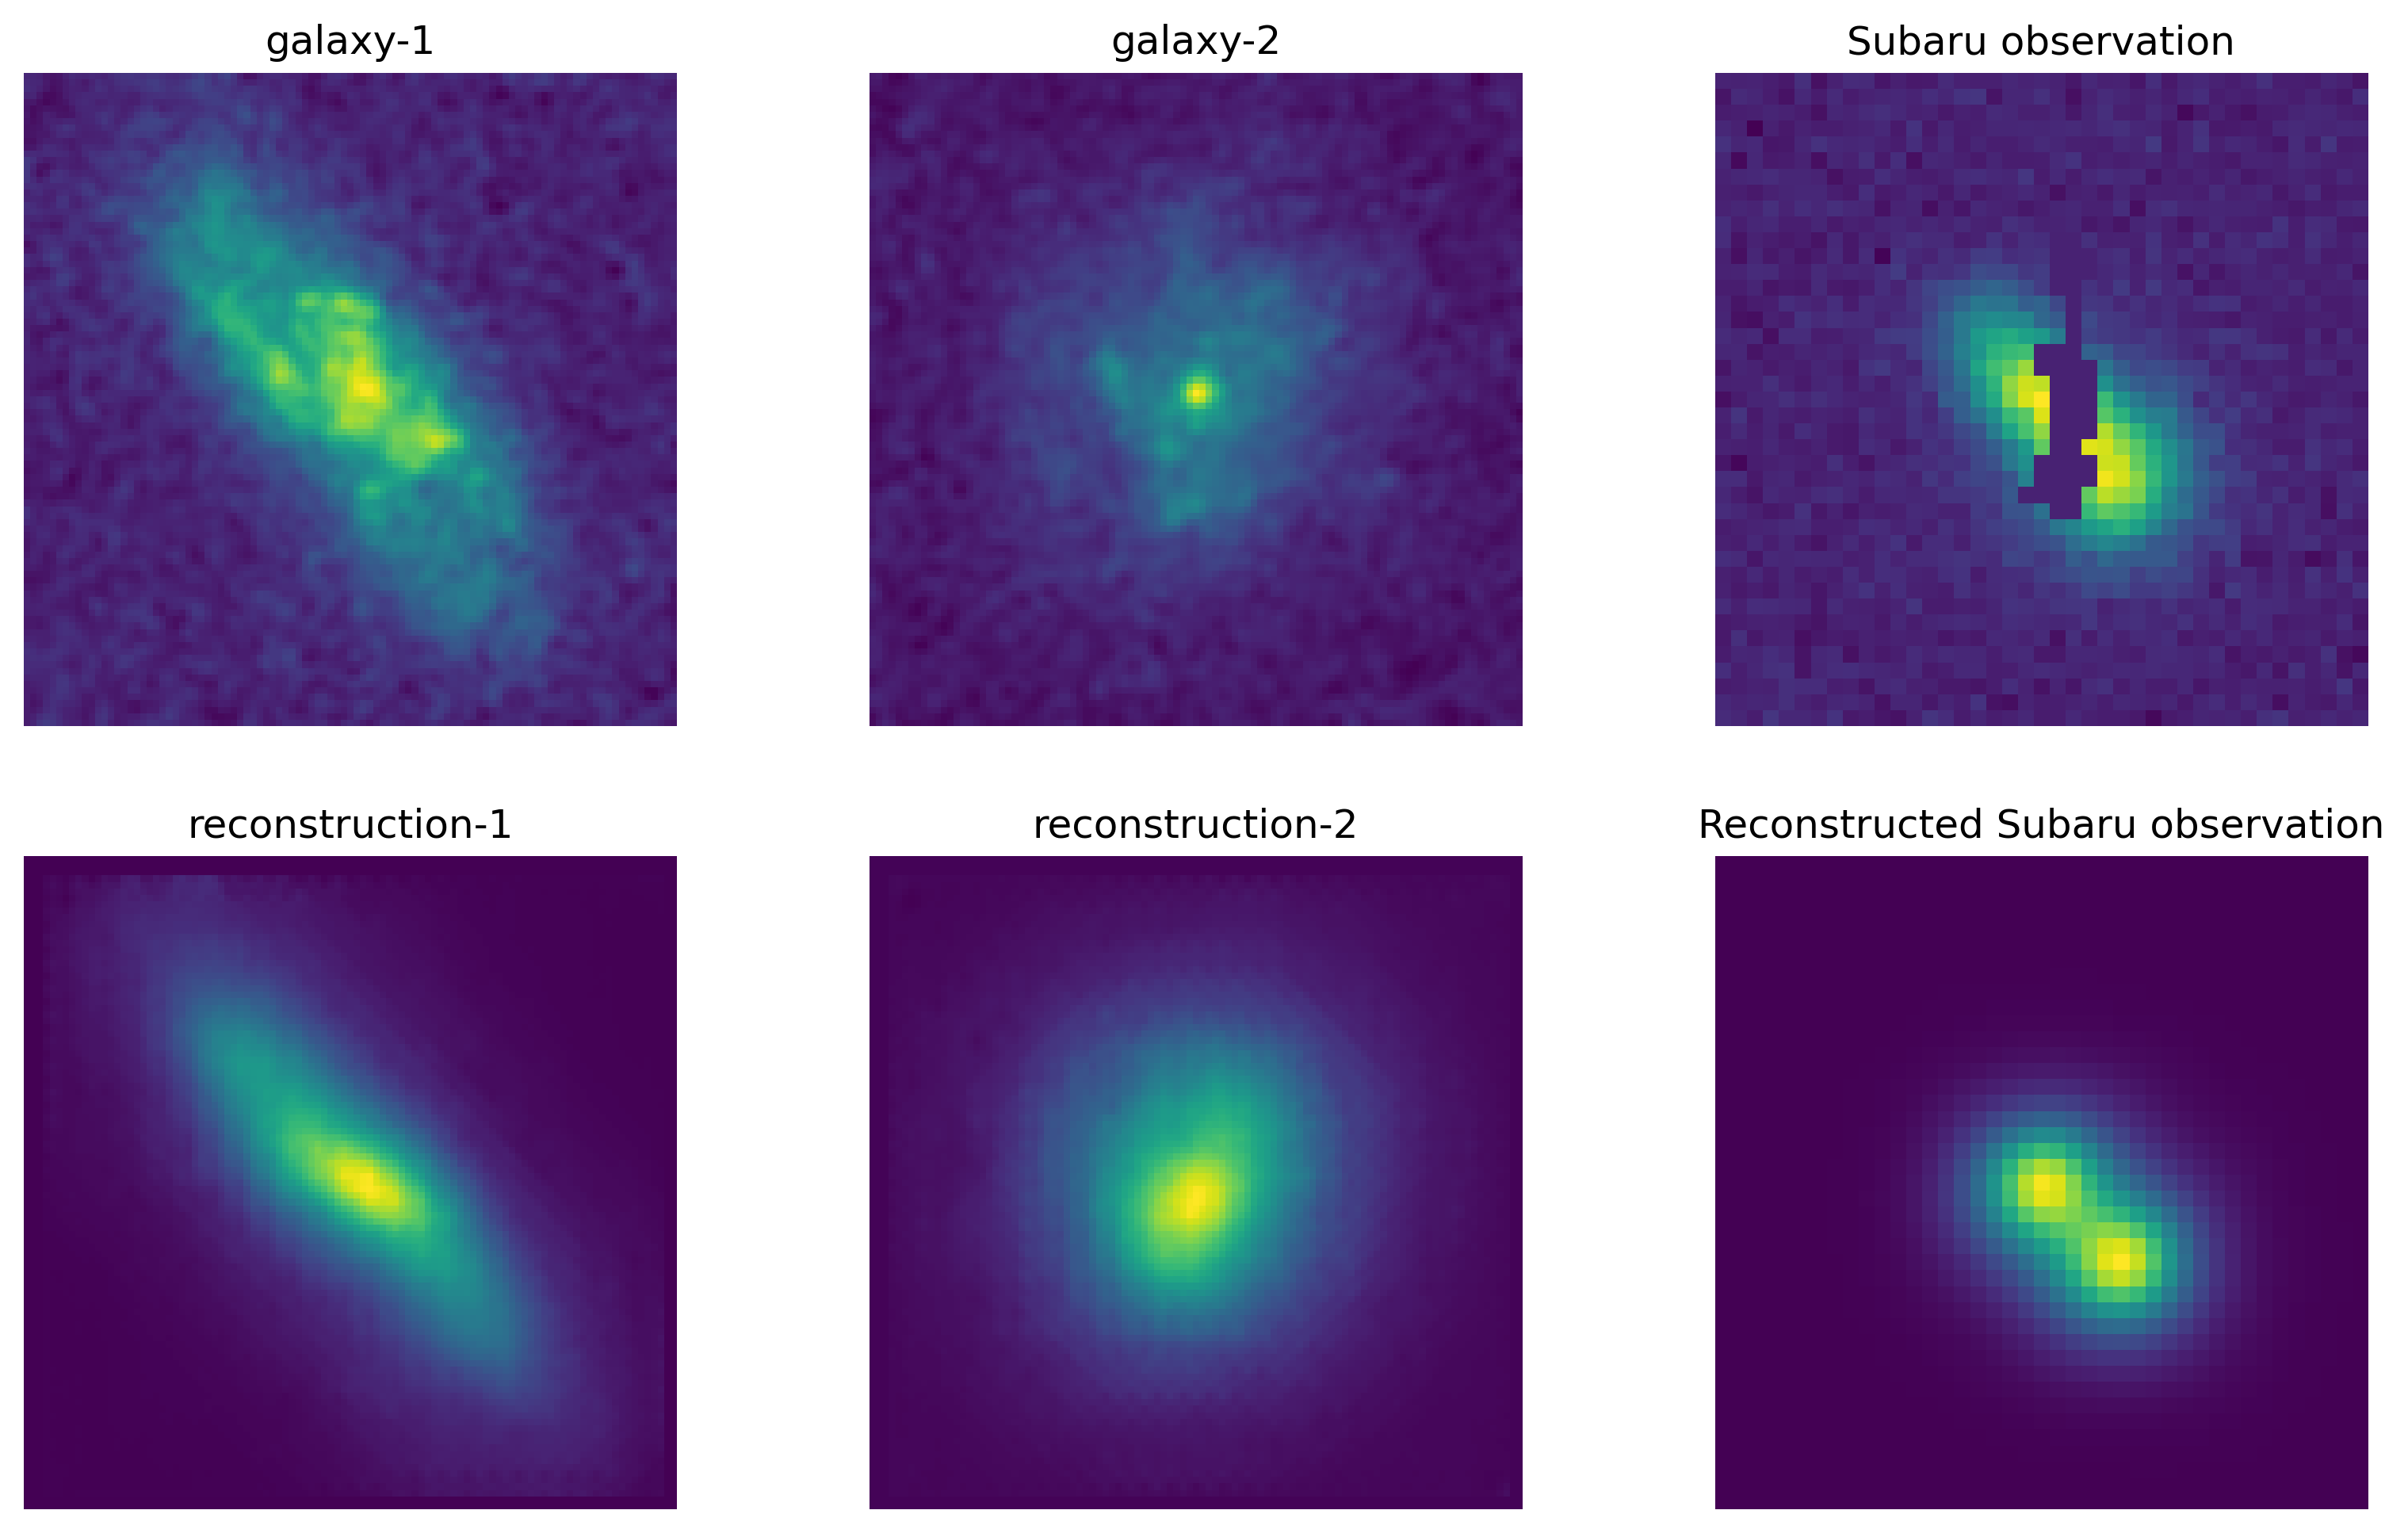

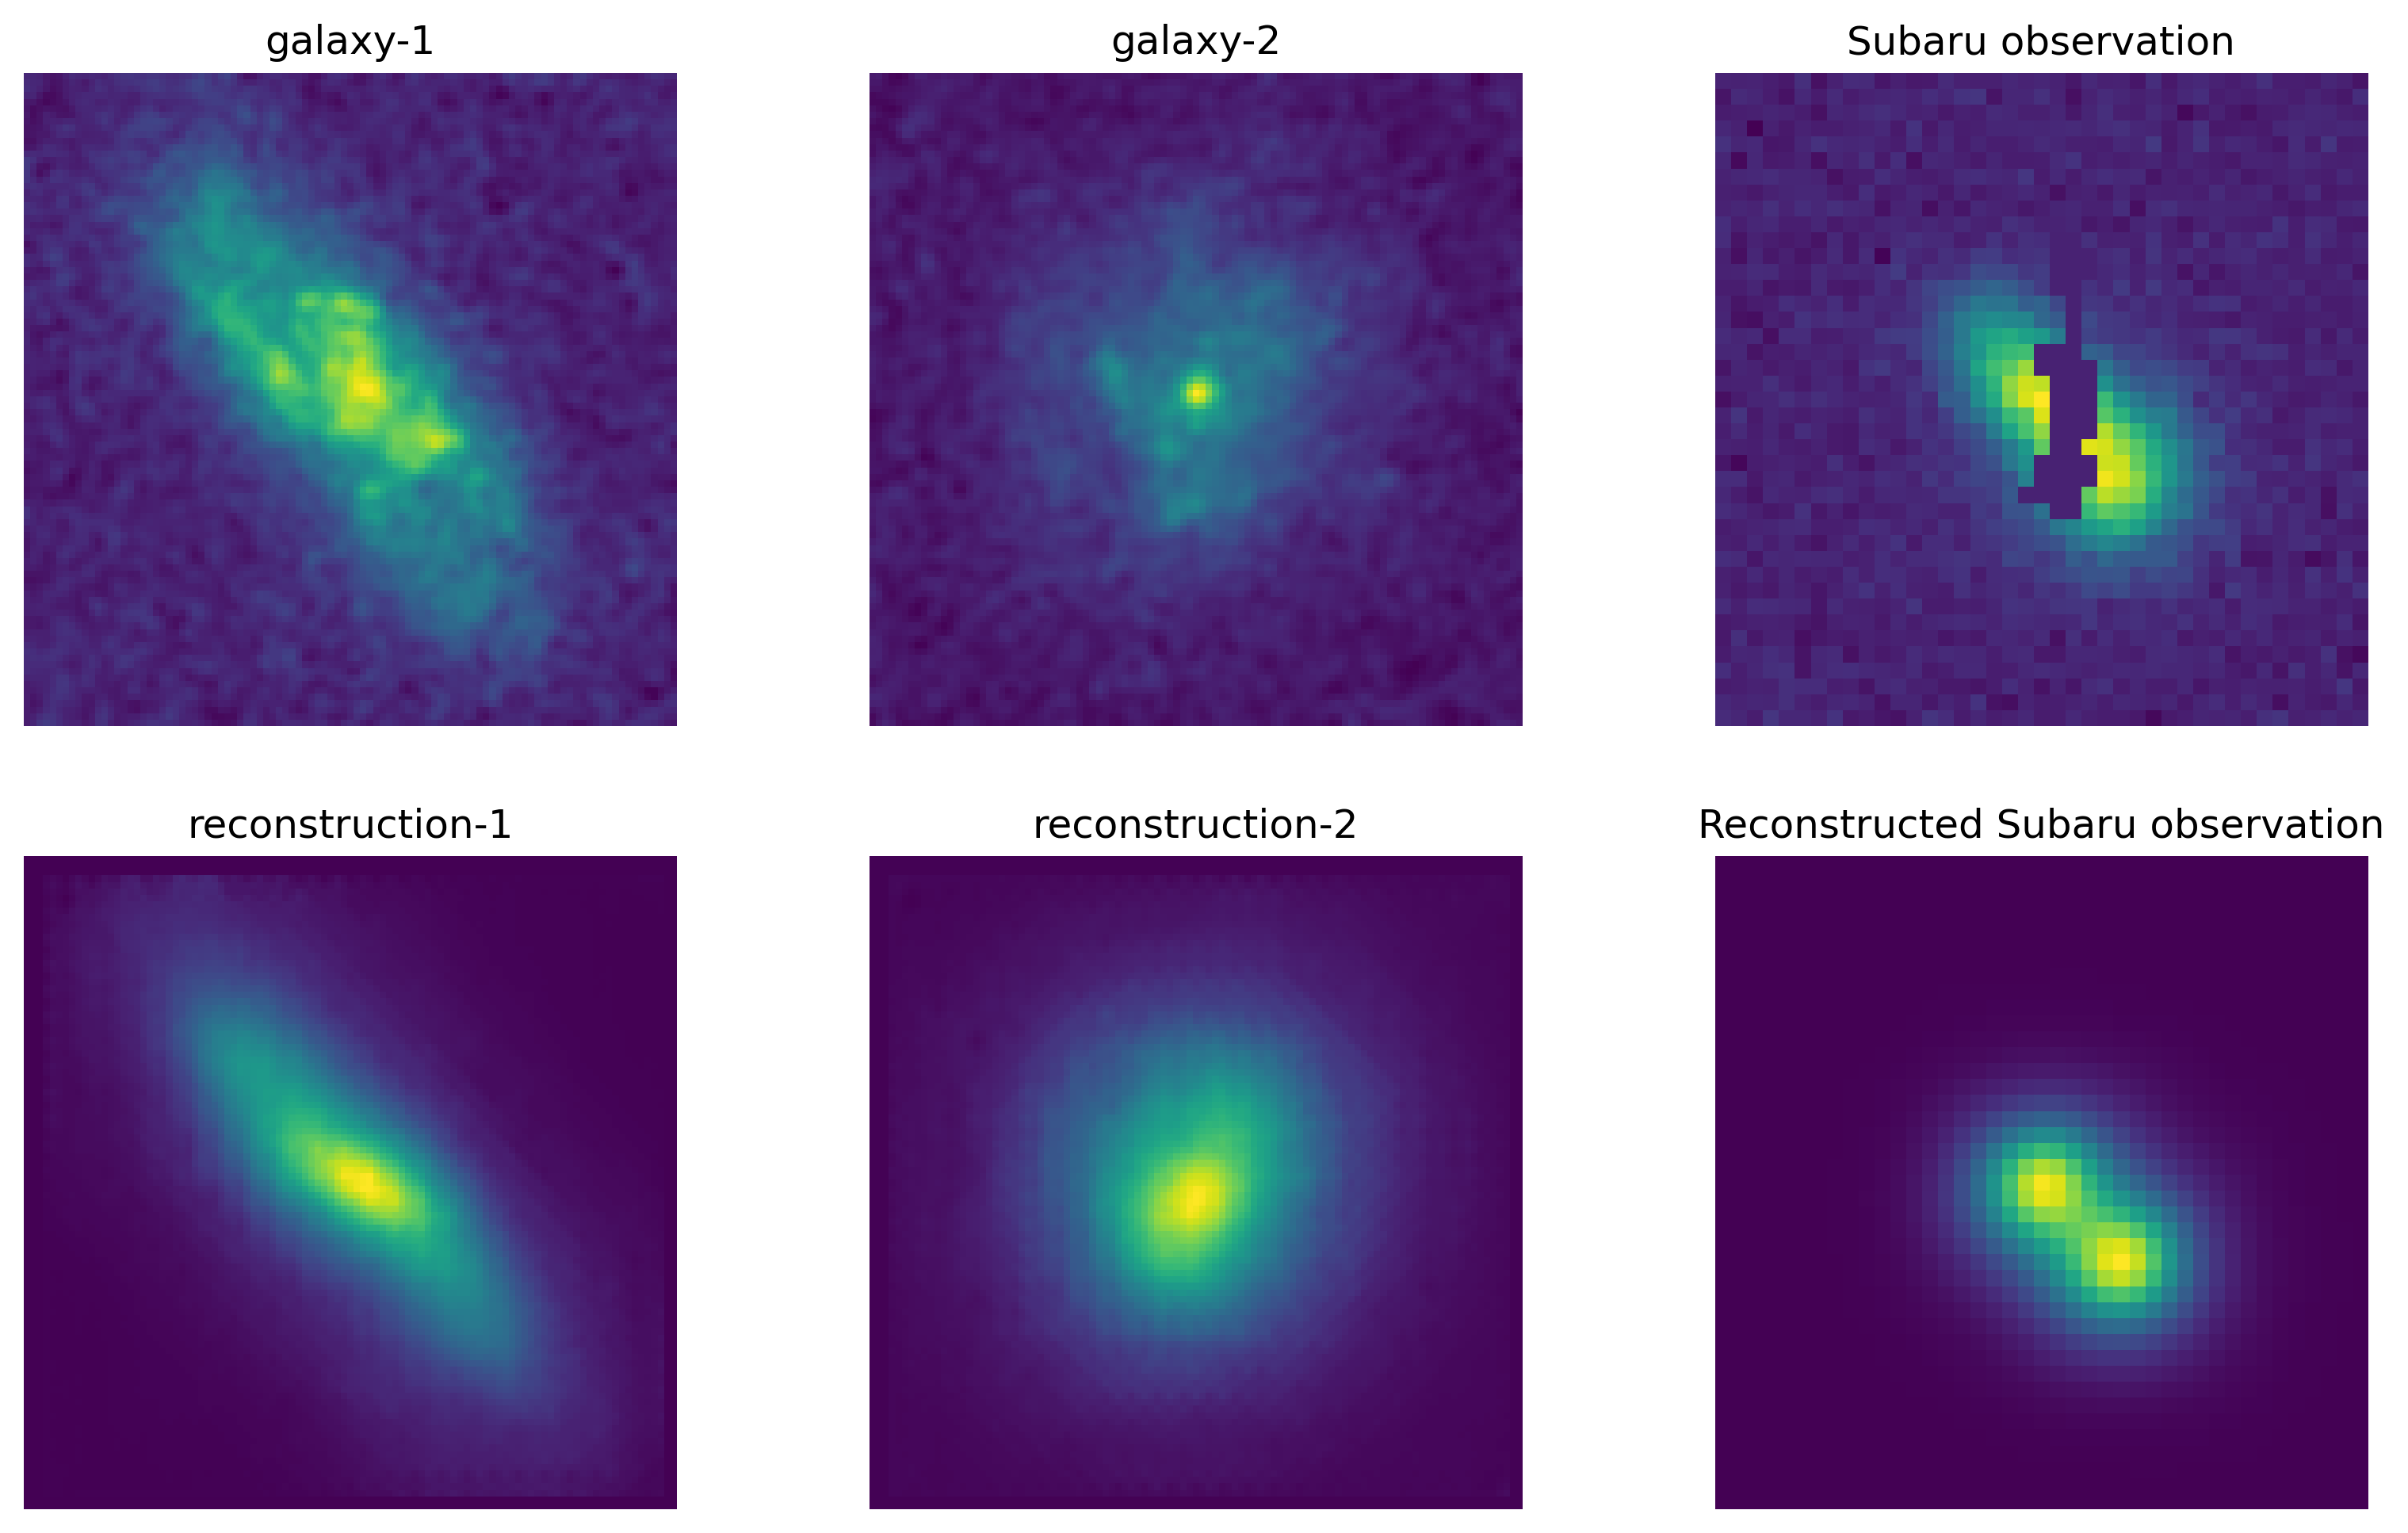

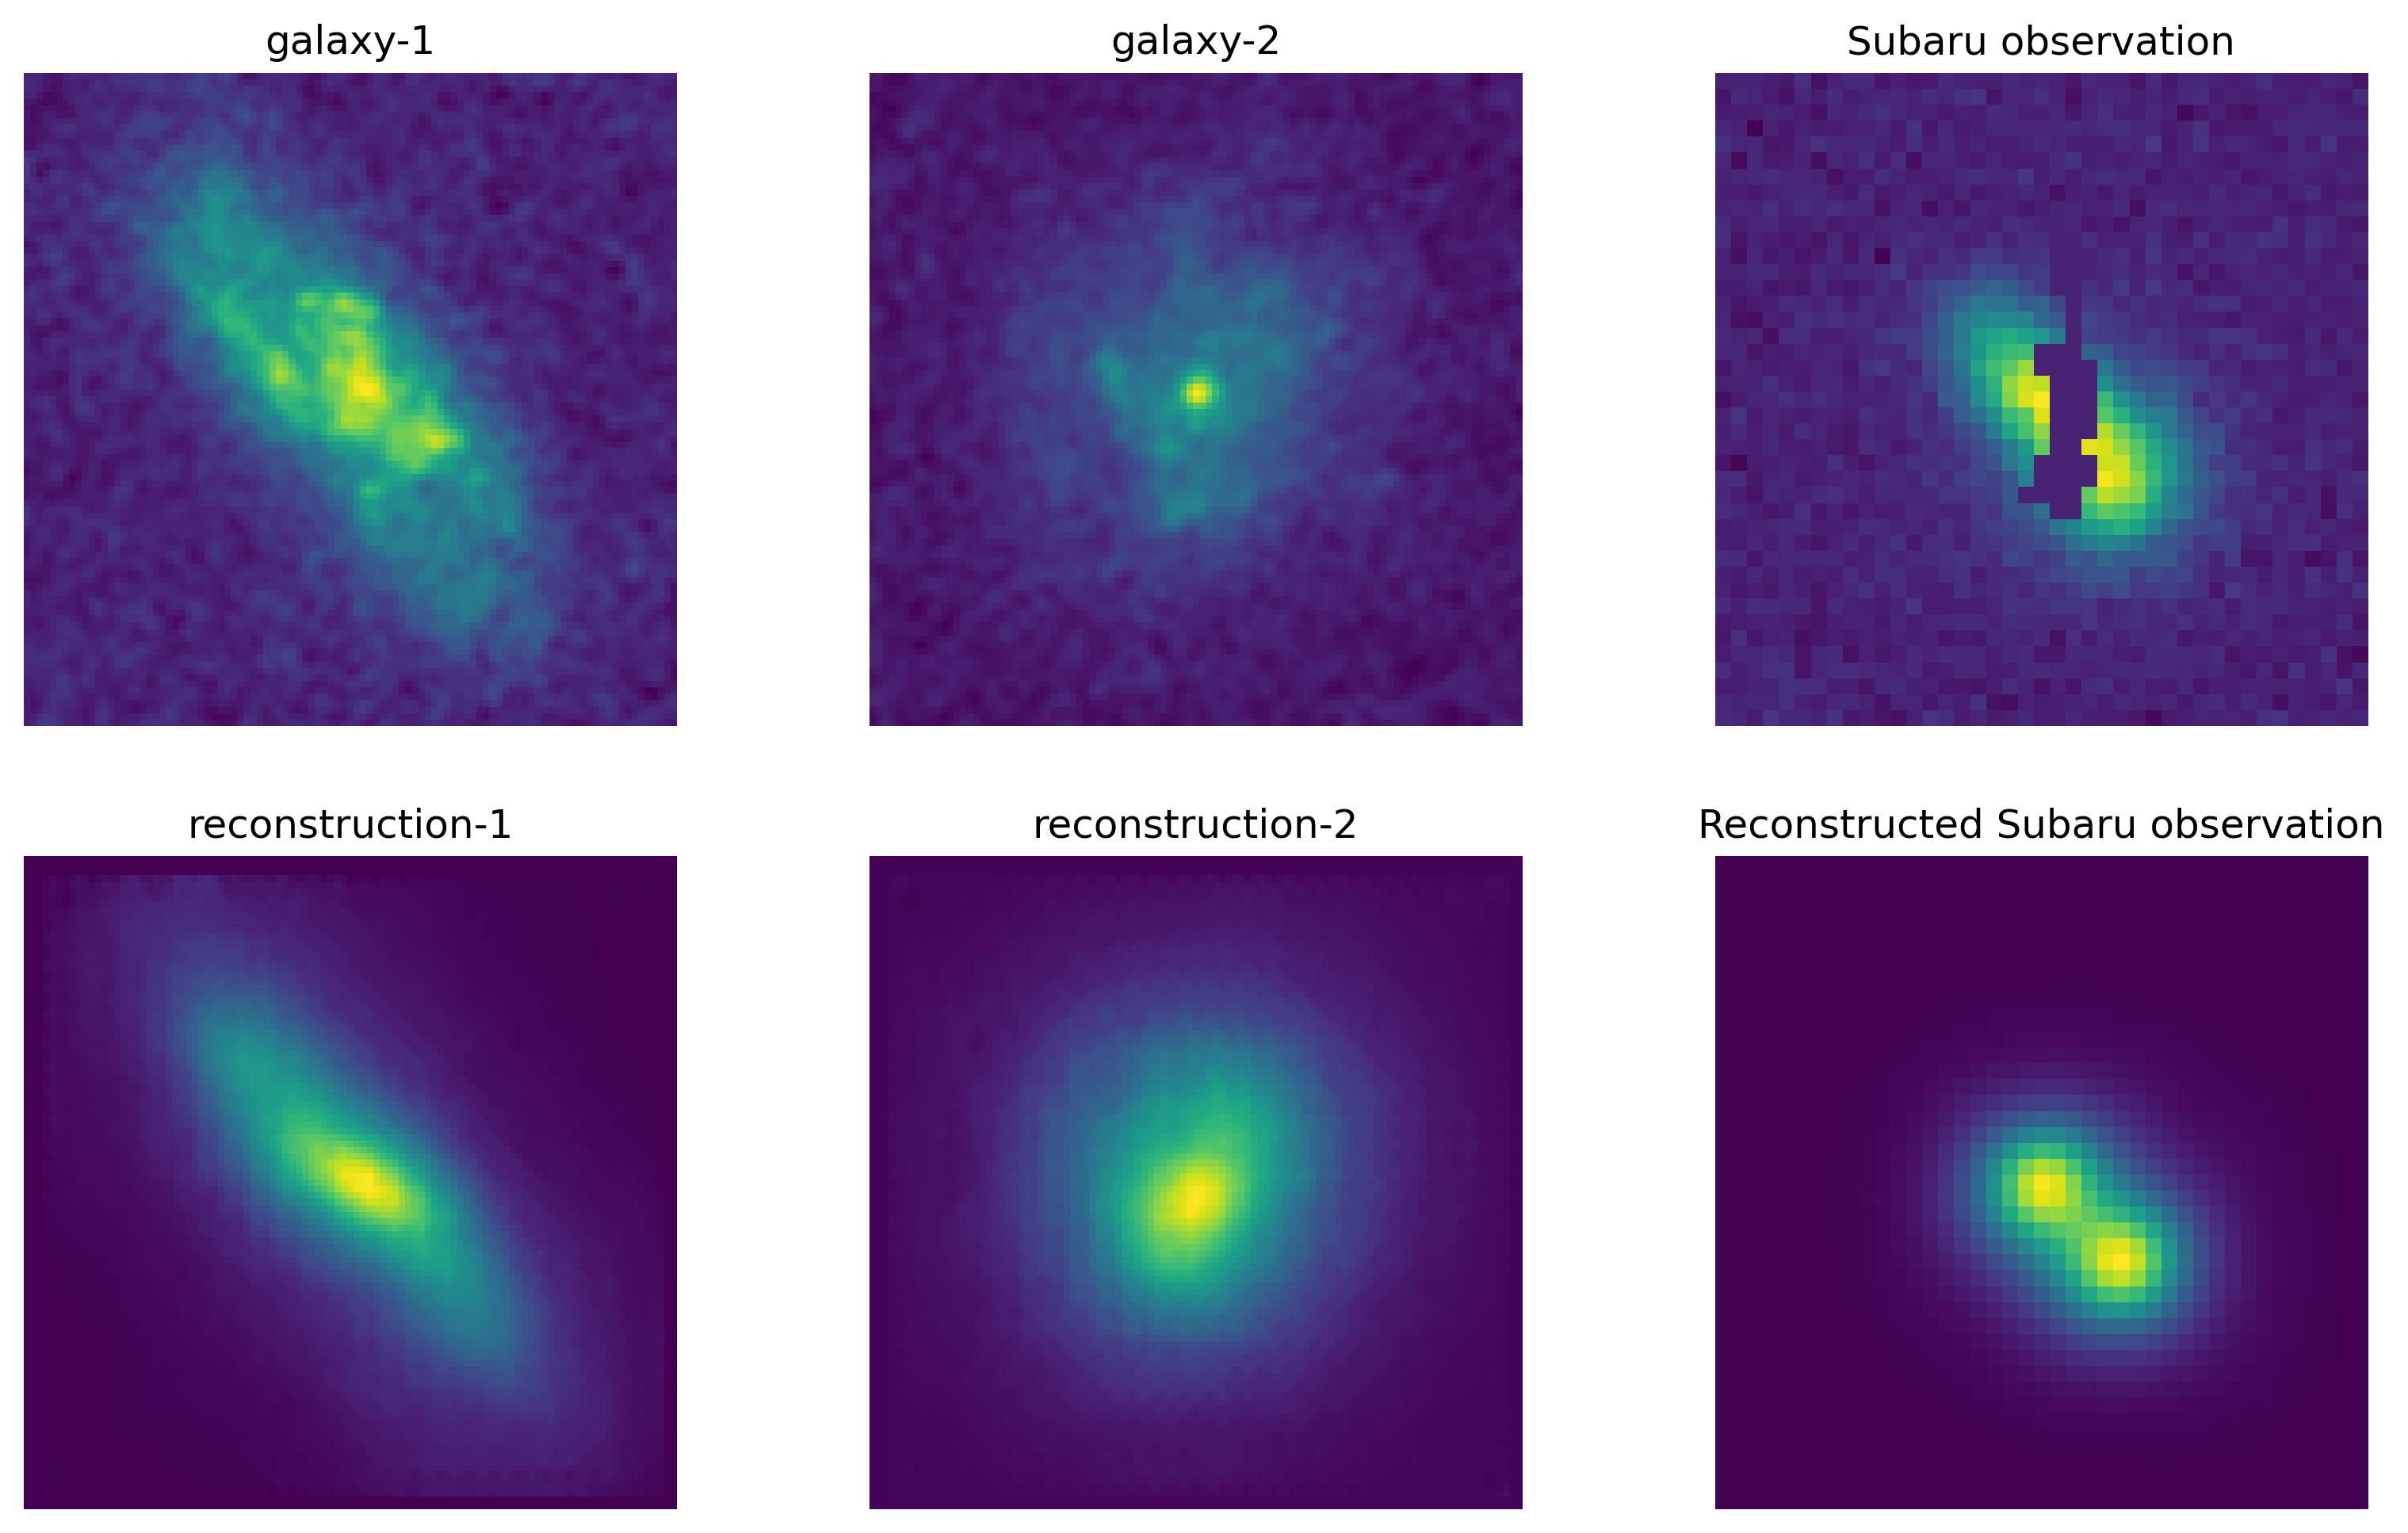

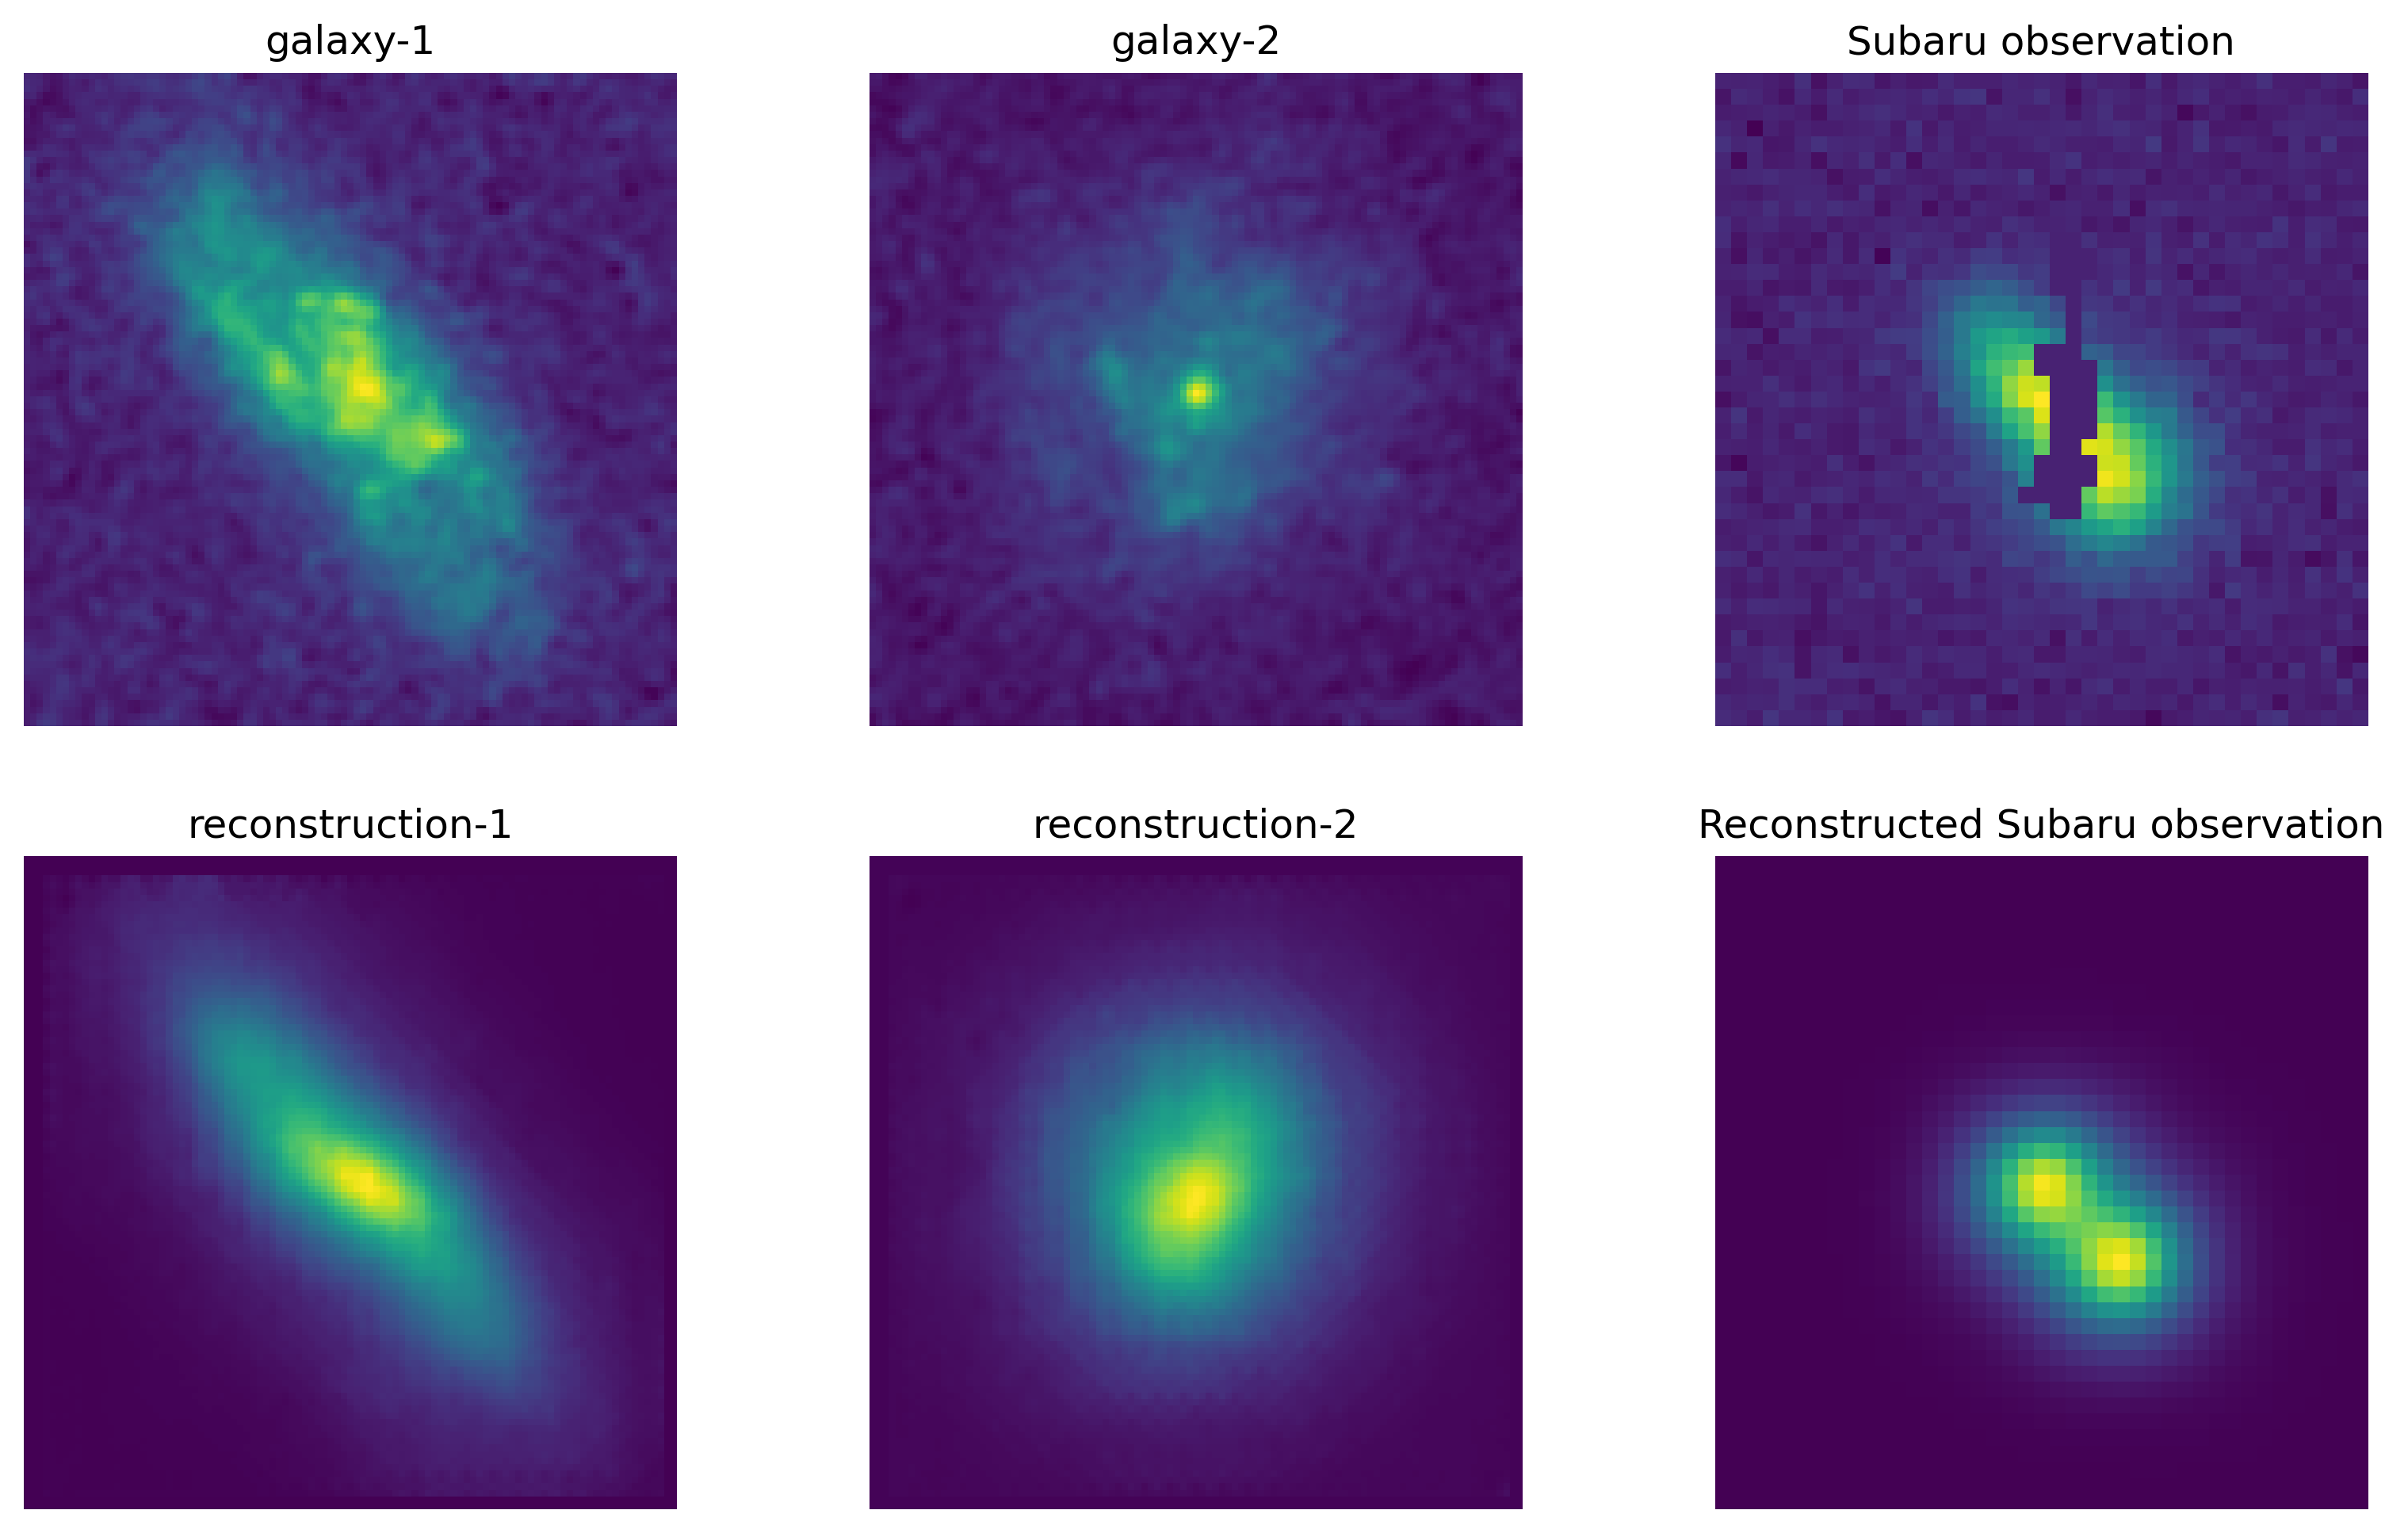

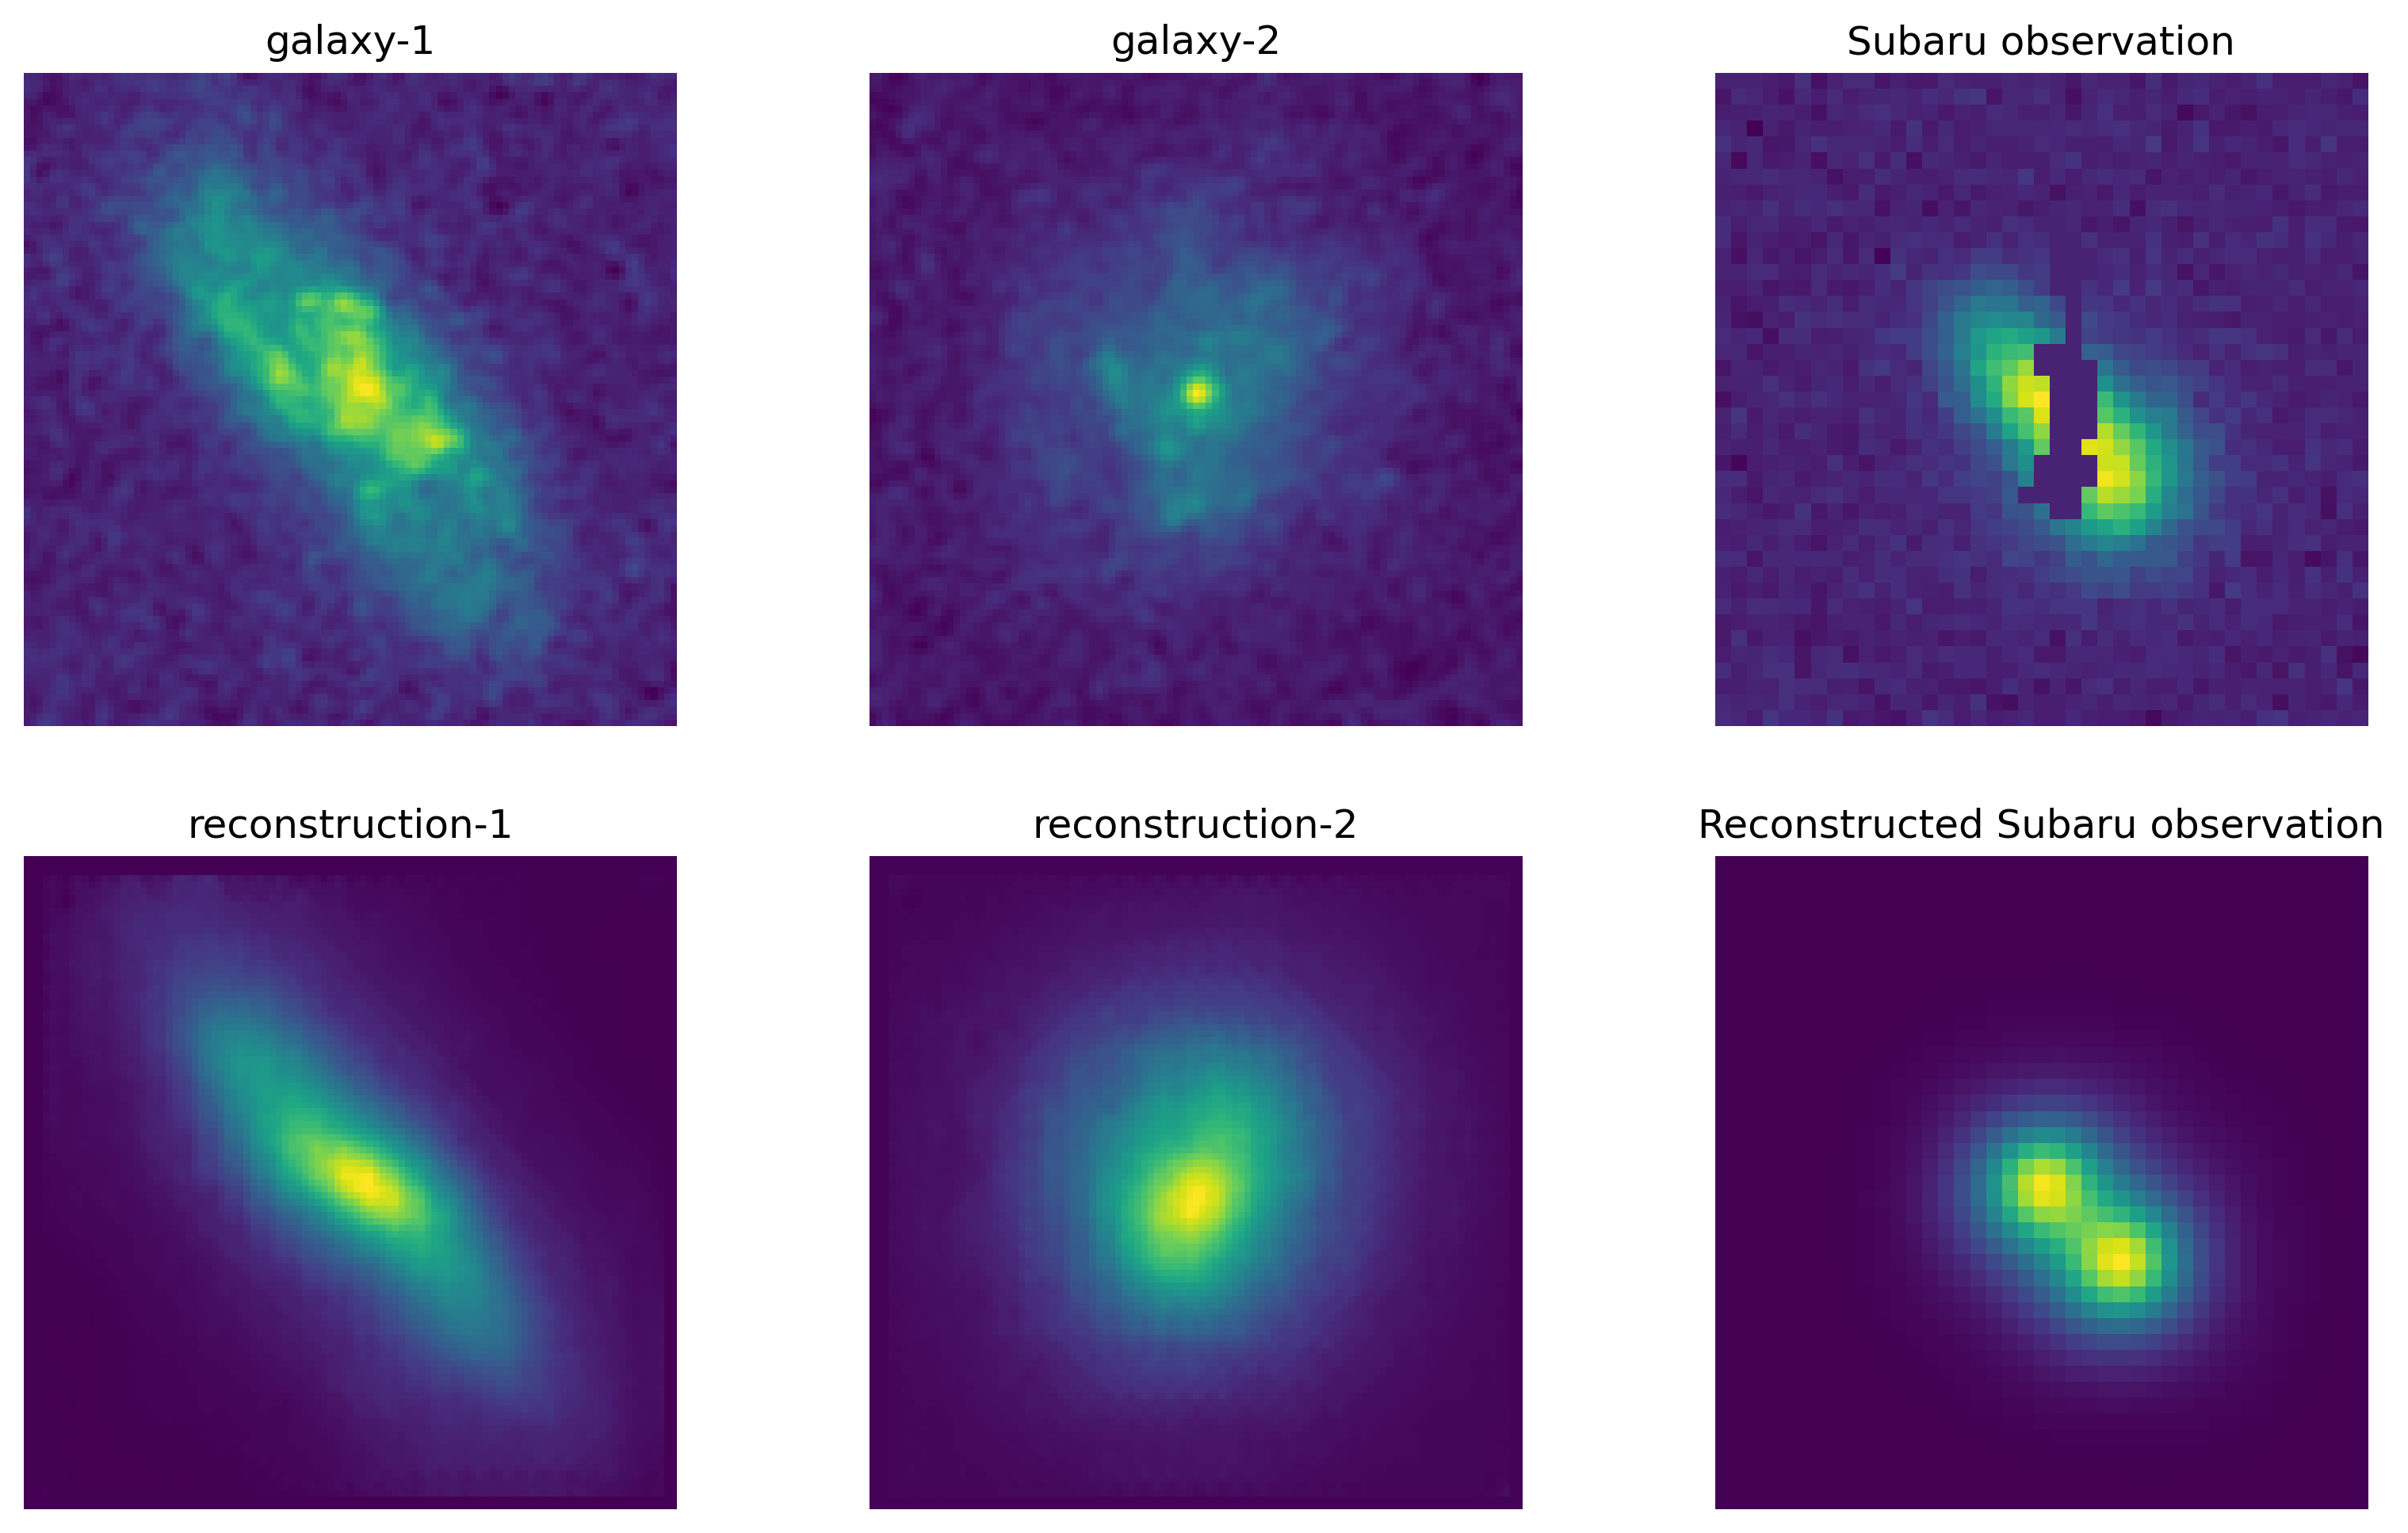

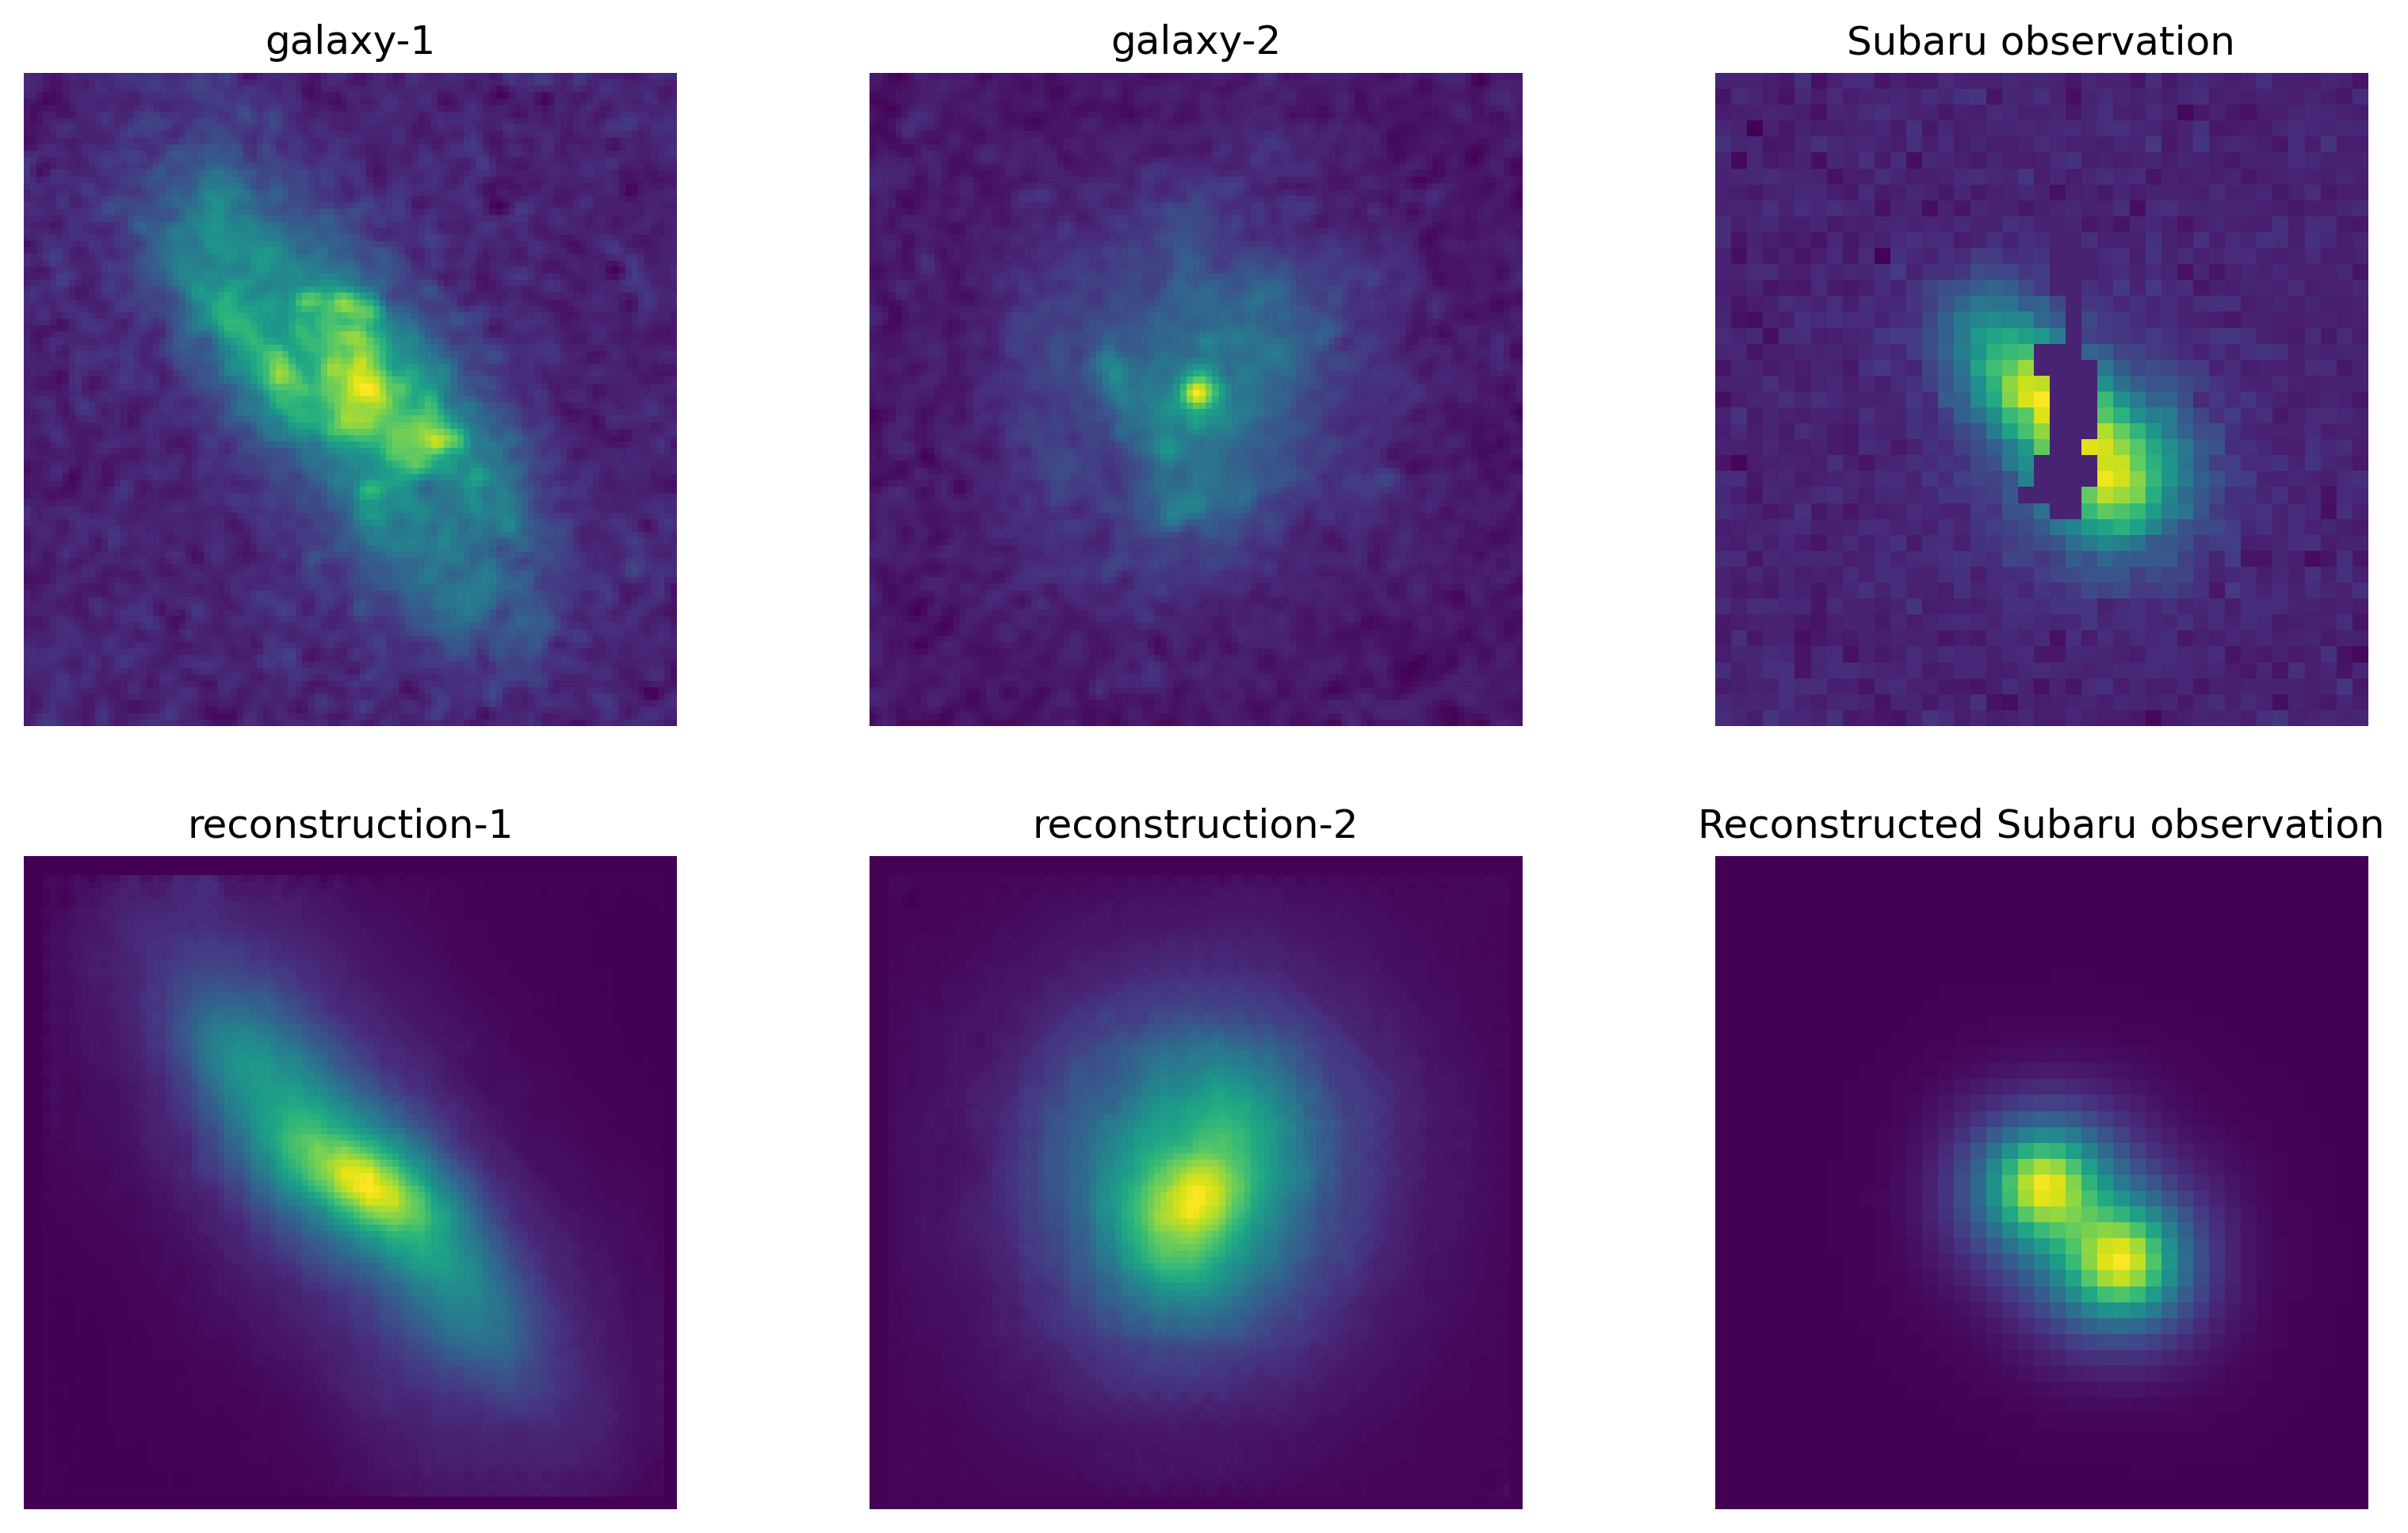

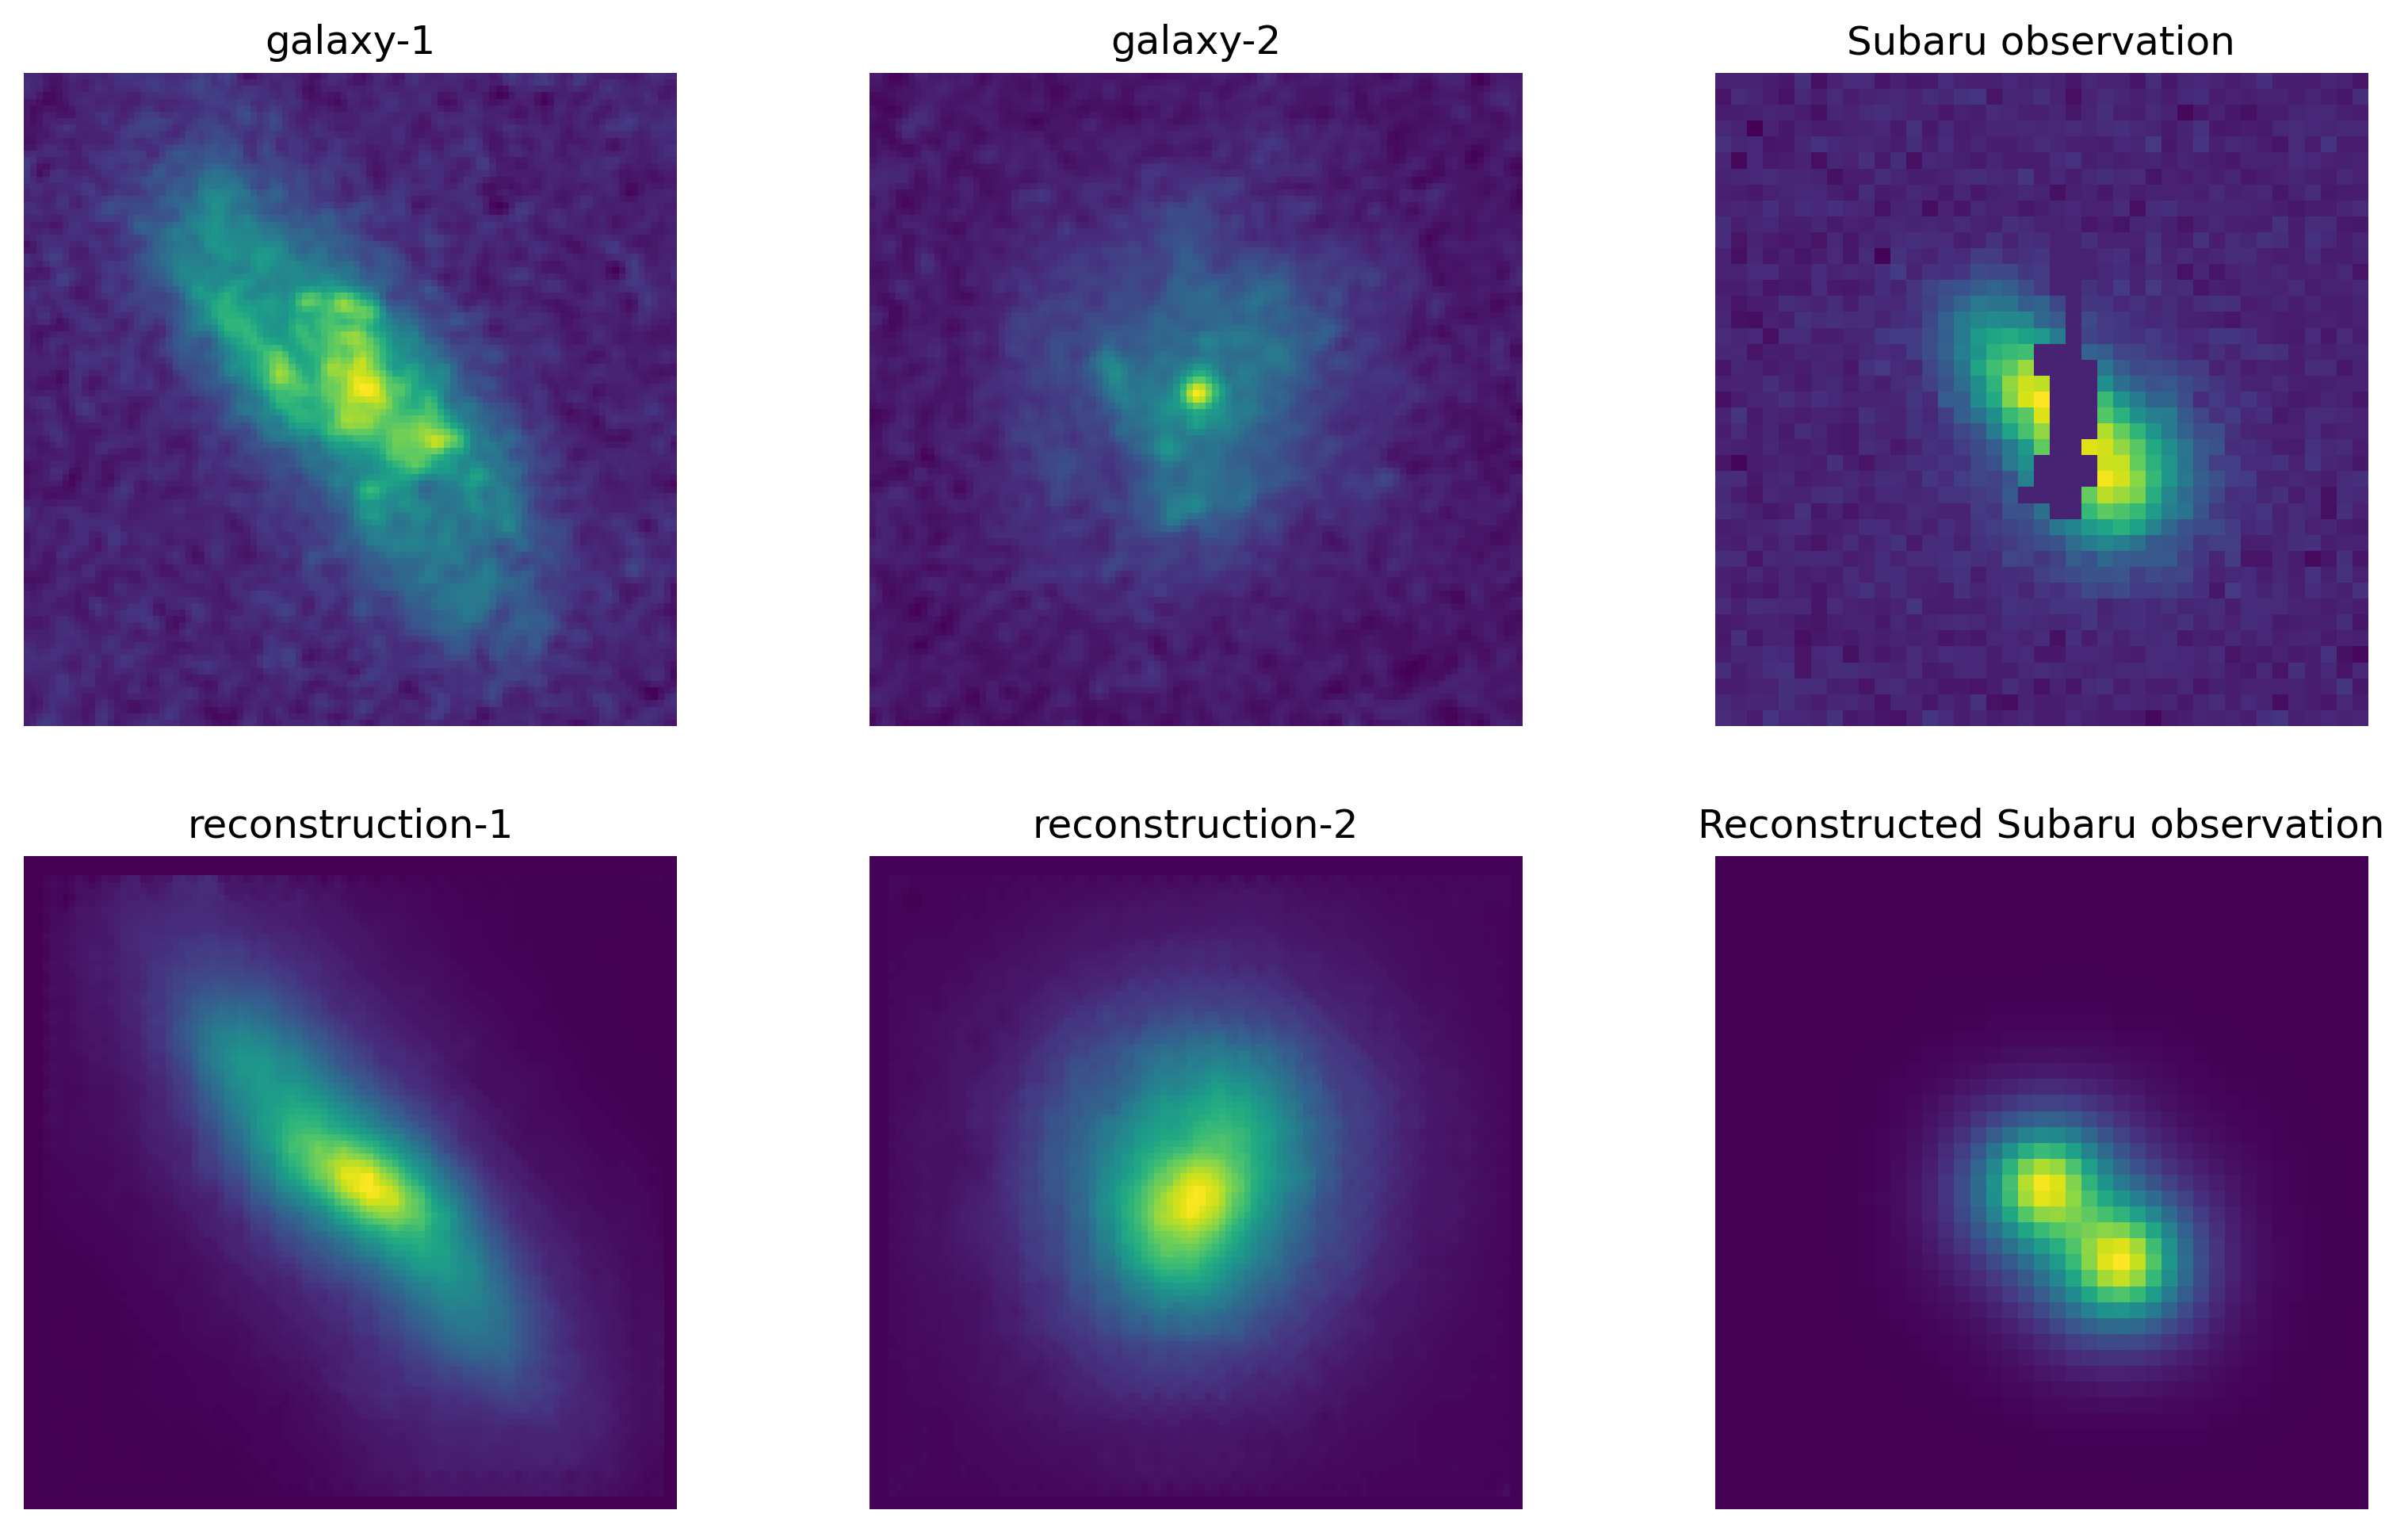

In [96]:
x1,_=generative_model.apply(params_1, state, states[1500:2000,0:32])
x2,_=generative_model.apply(params_1, state, states[1500:2000,32:64])

for i in range(10):
    figure(figsize=[13,8])
    subplot(231)
    imshow(x1_true)
    title('galaxy-1')
    axis('off')
    subplot(232)
    imshow(x2_true)
    title('galaxy-2')
    axis('off')
    subplot(233)
    imshow(y_obs)
    title('Subaru observation')
    axis('off')
    subplot(234)
    imshow(x1[i*5])
    title('reconstruction-1')
    axis('off')
    subplot(235)
    imshow(x2[i*5])
    title('reconstruction-2')
    axis('off')
    subplot(236)
    imshow(blending(x1[i],x2[i]))
    title('Reconstructed Subaru observation')
    axis('off')

Text(0.5, 1.0, 'Residuals')

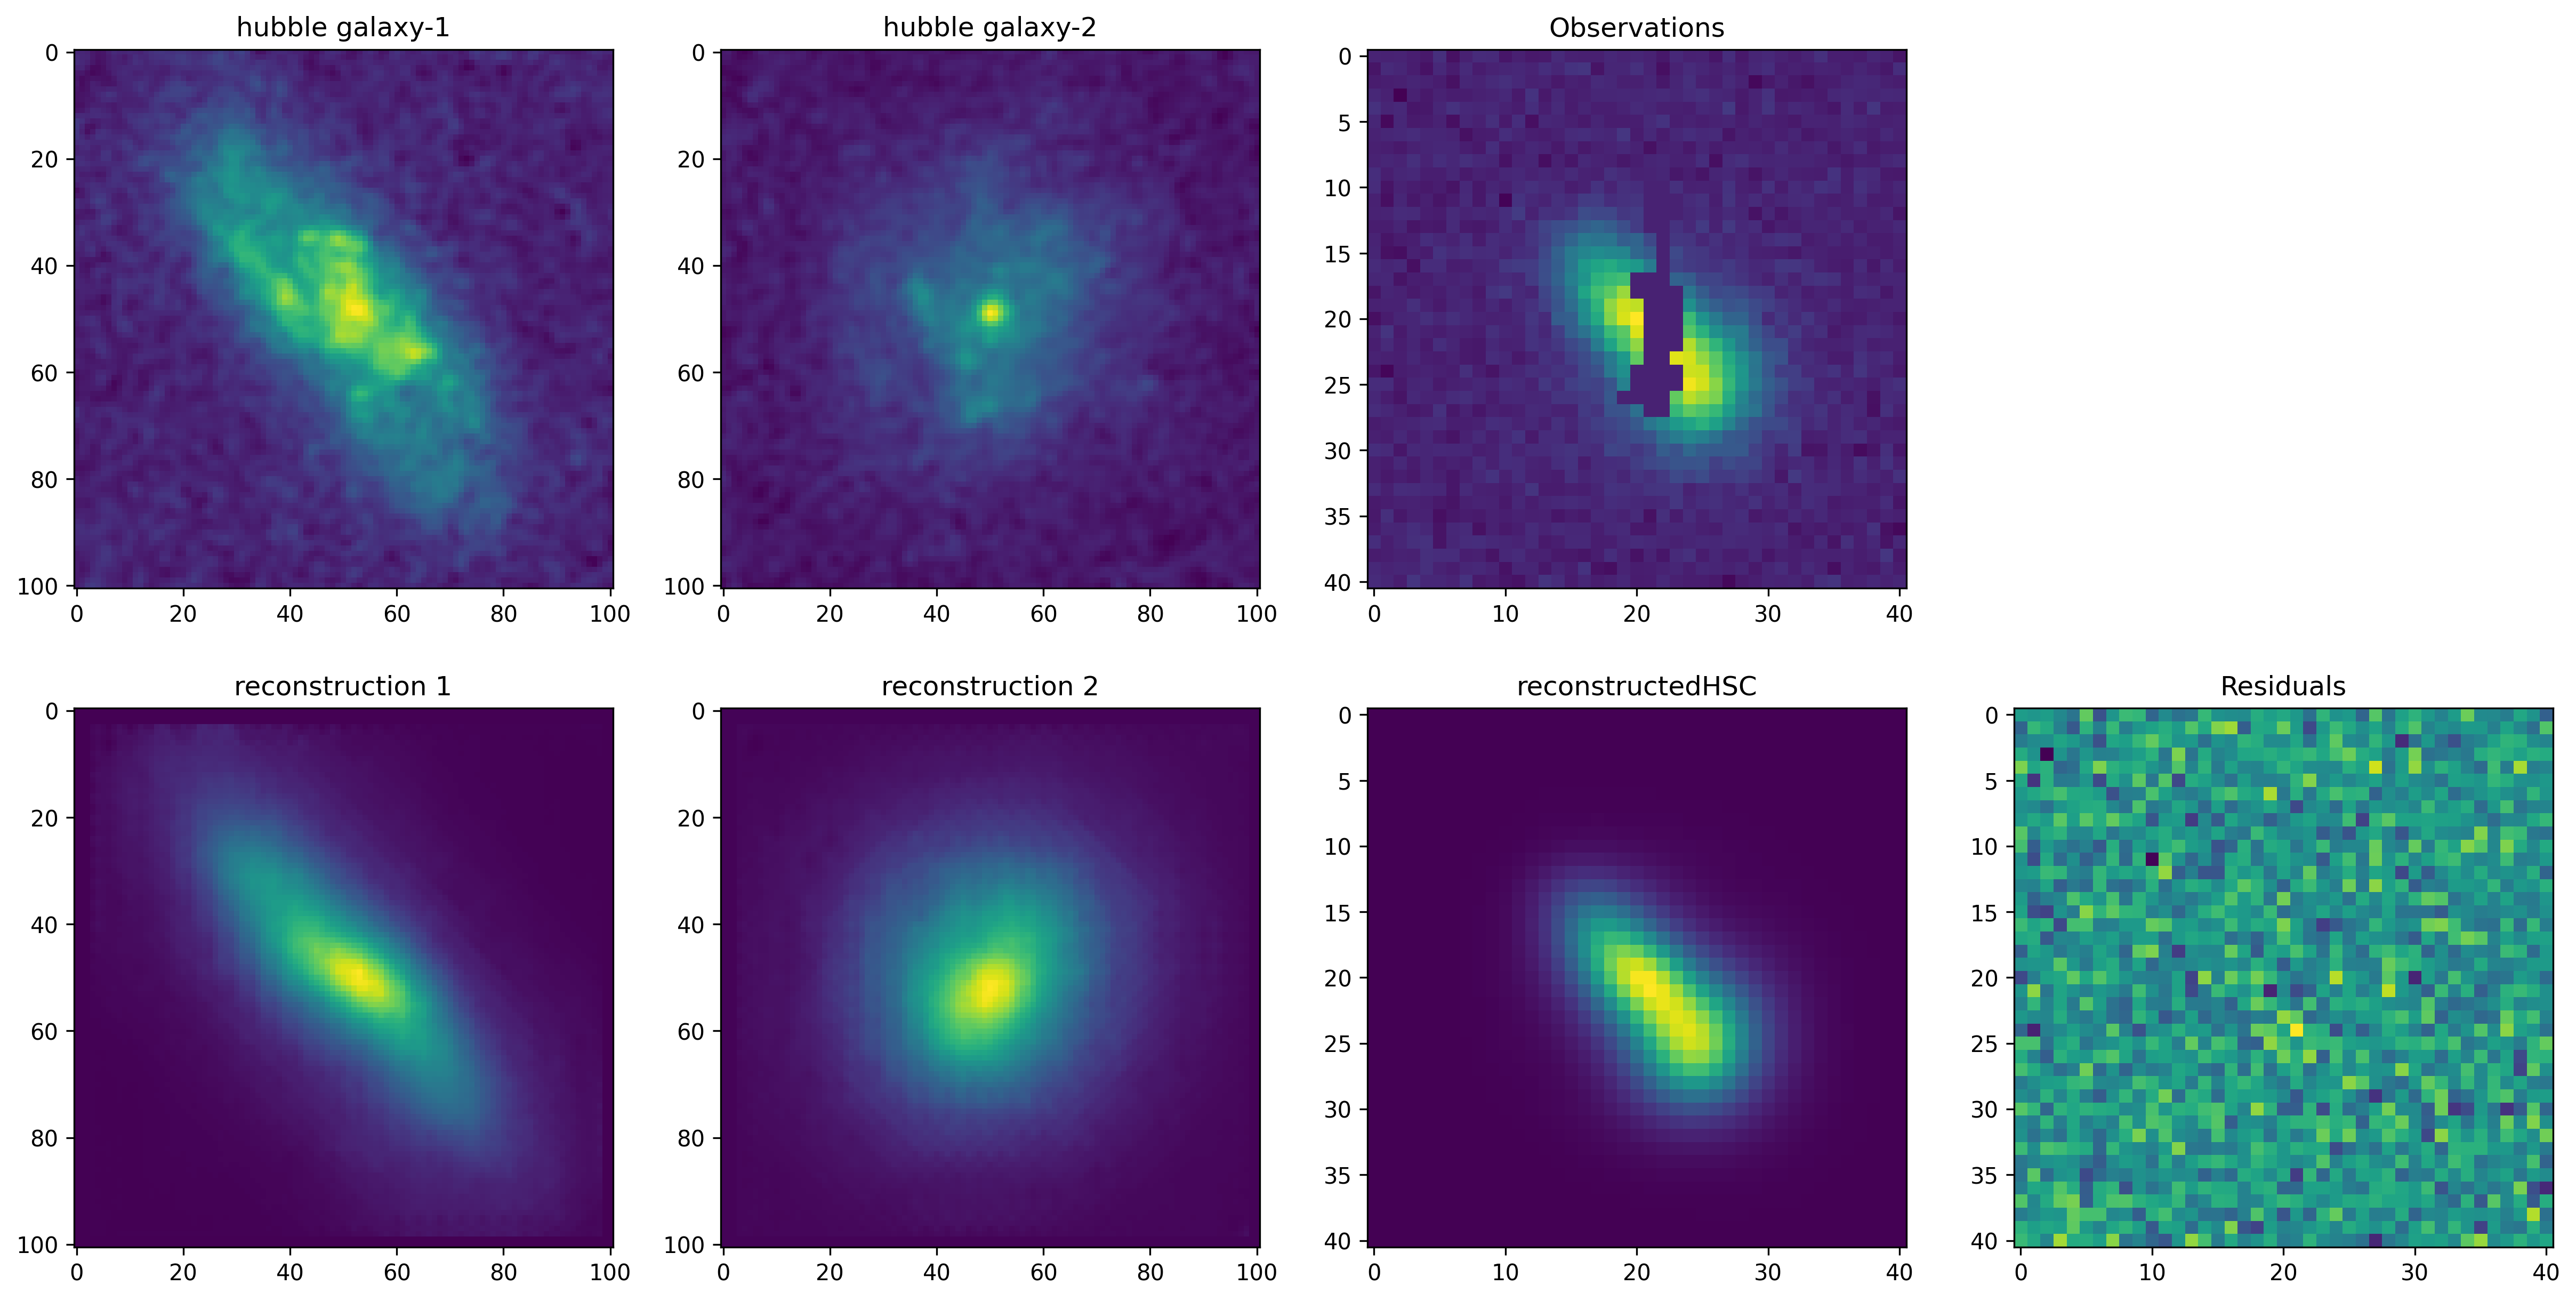

In [87]:
z=jnp.mean(states,axis=0)
im1, _ = generative_model.apply(params, state, z[0:32])
im2, _ = generative_model.apply(params, state, z[32:64])
plt.rcParams['figure.dpi']=300
figure(figsize=[20,10])
subplot(241)
imshow(x1_true)
title('hubble galaxy-1')
subplot(242)
imshow(x2_true)
title('hubble galaxy-2')
subplot(243)
imshow(y_obs)
title('Observations')
subplot(245)
imshow(im1[0])
title('reconstruction 1')
subplot(246)
imshow(im2[0])
title('reconstruction 2')
subplot(247)
imshow(blending(z[0:32],z[32:64]))
title('reconstructedHSC')
subplot(248)
imshow(im_noise-blending(z[0:32],z[32:64]))
title('Residuals')

/home/dkn16/.local/lib/python3.7/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().


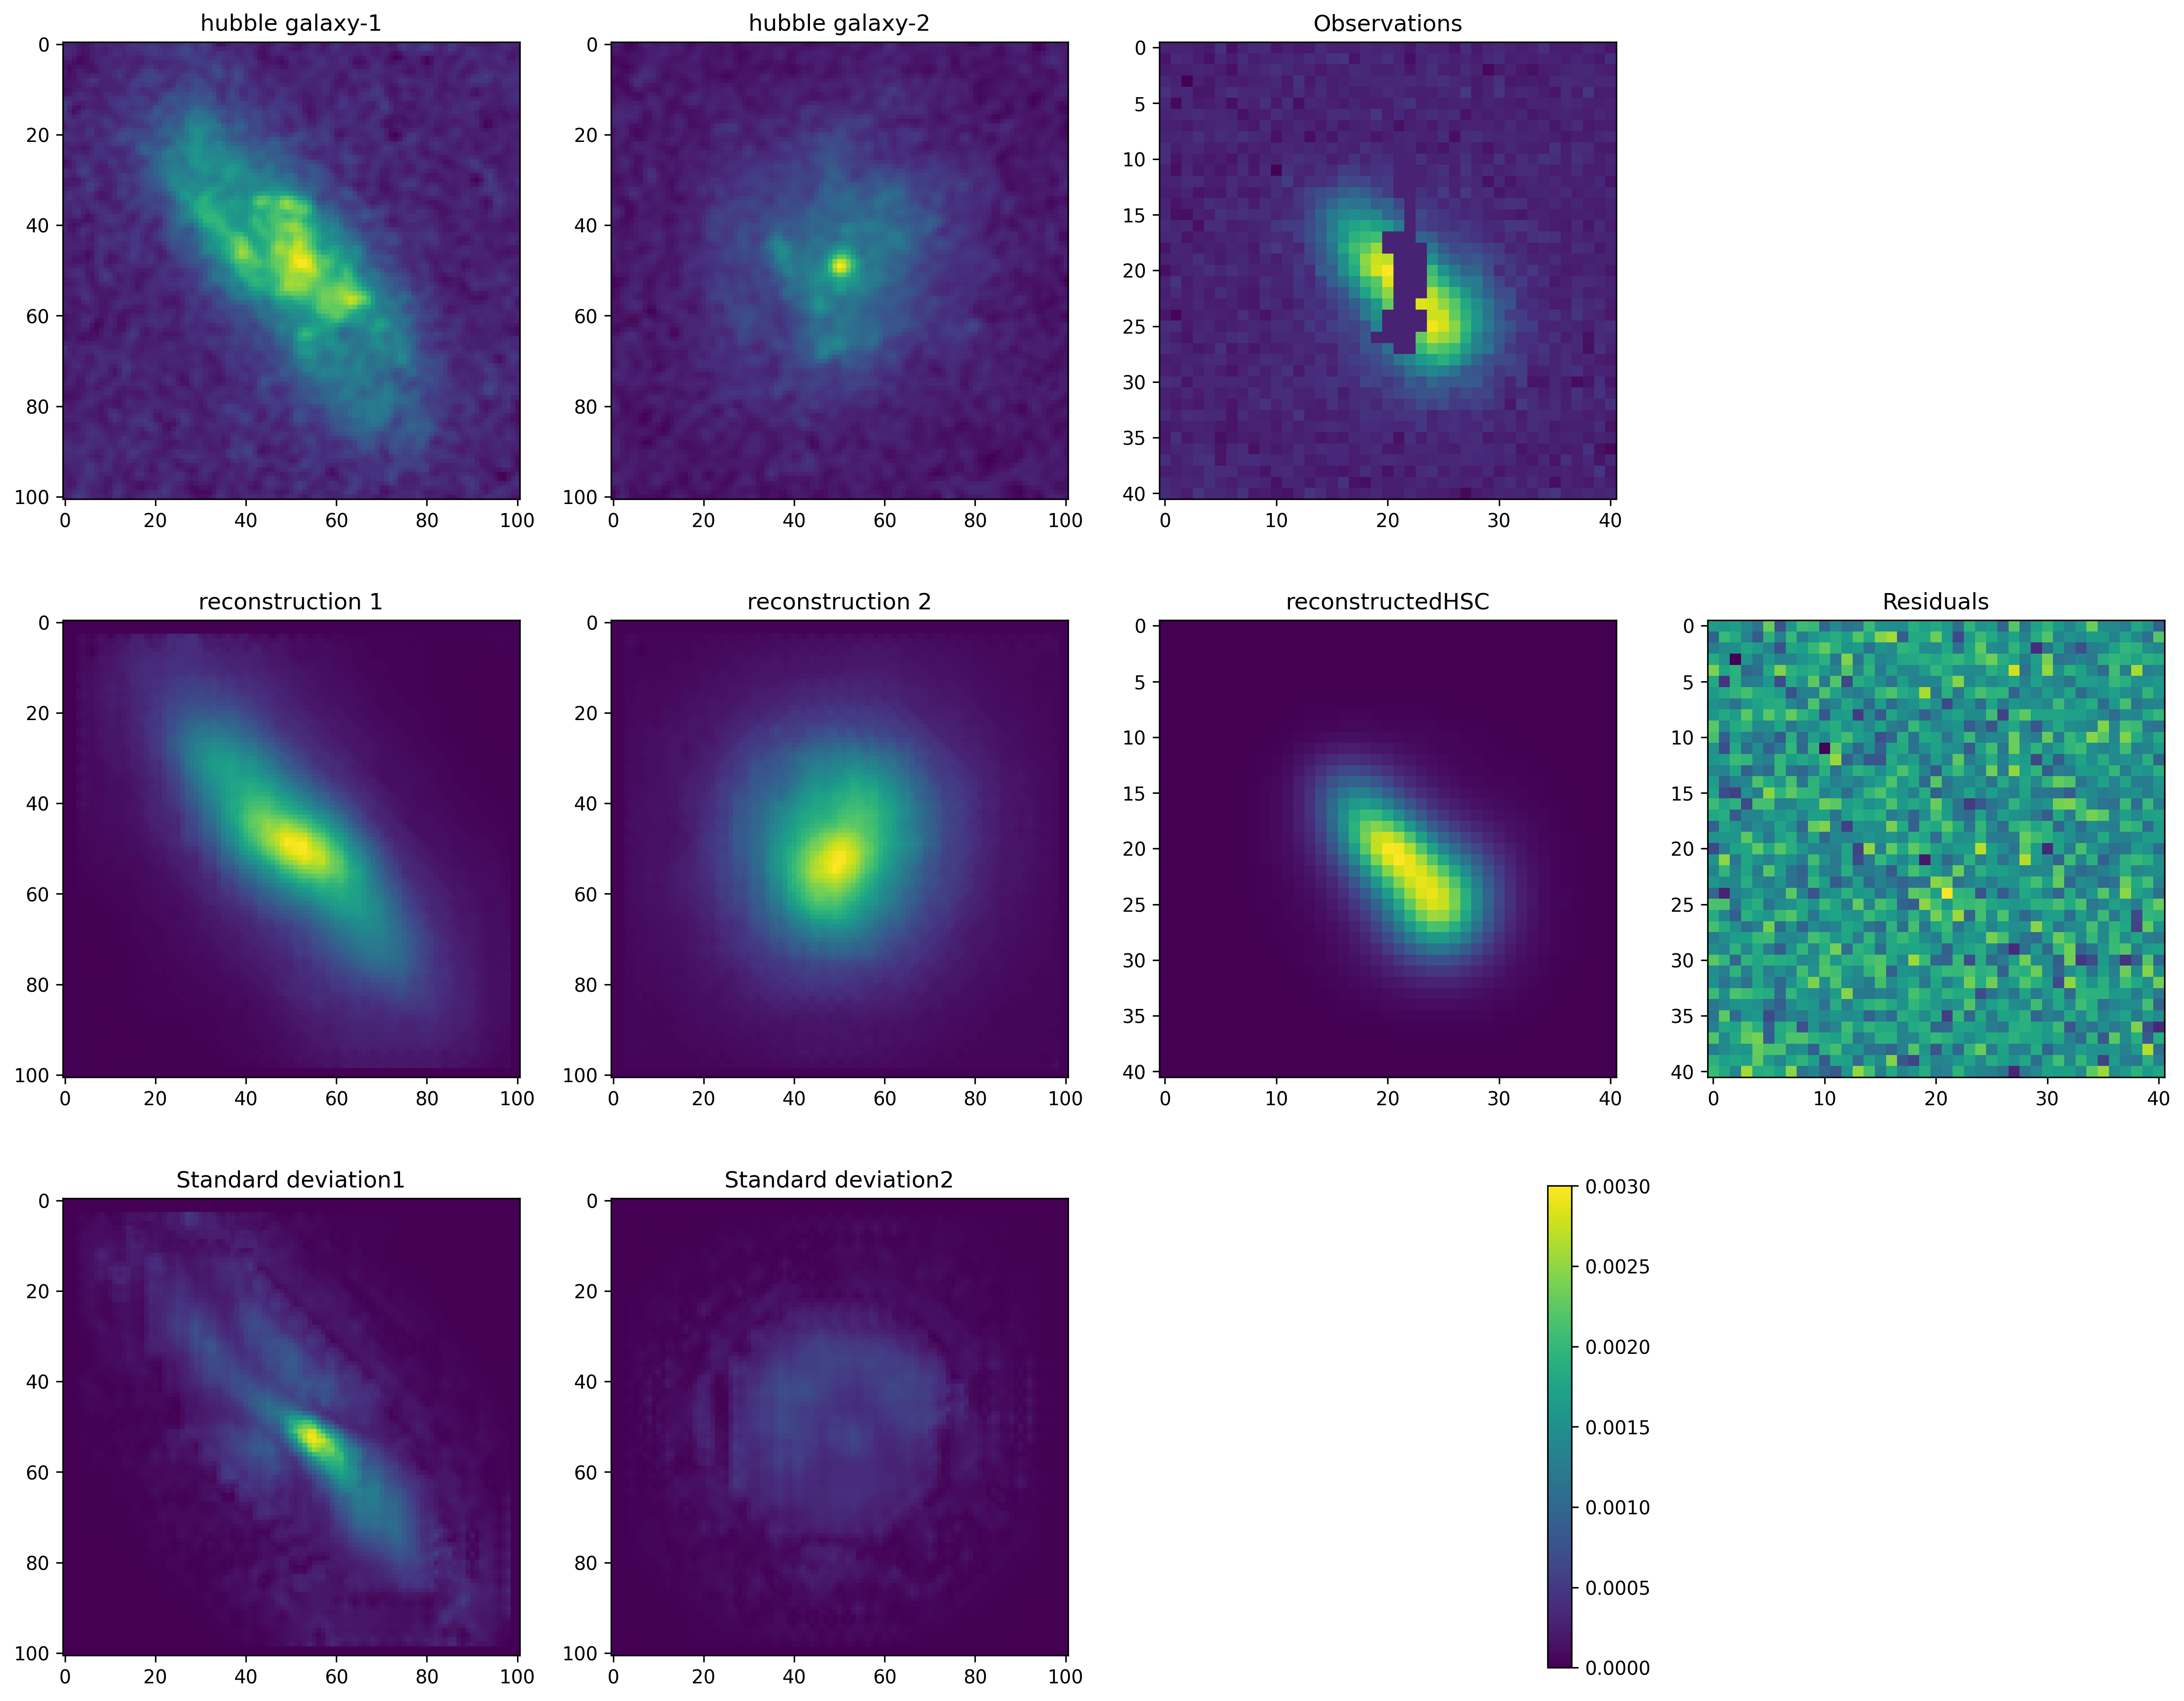

In [139]:
from matplotlib import colors
x1,_=generative_model.apply(params_1, state, states[1500:2000,0:32])
x2,_=generative_model.apply(params_1, state, states[1500:2000,32:64])
fig=figure(figsize=[20,16])
x1ave=jnp.mean(x1,axis=0)
x2ave=jnp.mean(x2,axis=0)
subplot(341)
imshow(x1_true)
title('hubble galaxy-1')
subplot(342)
imshow(x2_true)
title('hubble galaxy-2')
subplot(343)
imshow(y_obs)
title('Observations')
subplot(345)
imshow(x1ave)
title('reconstruction 1')
subplot(346)
imshow(x2ave)
title('reconstruction 2')
subplot(347)
imshow(blendingHSC(x1ave,x2ave))
title('reconstructedHSC')
subplot(348)
imshow(im_noise-blendingHSC(x1ave,x2ave))
title('Residuals')
subplot(349)
im=imshow(jnp.std(x1,axis=0),vmax=3e-3)
title('Standard deviation1')
subplot(3,4,10)
imshow(jnp.std(x2,axis=0),vmax=3e-3)
title('Standard deviation2')
subplot(3,4,11)
axis('off')
colorbar(im)



In [121]:
jnp.max(jnp.std(x1,axis=0))

DeviceArray(0.00294119, dtype=float32)

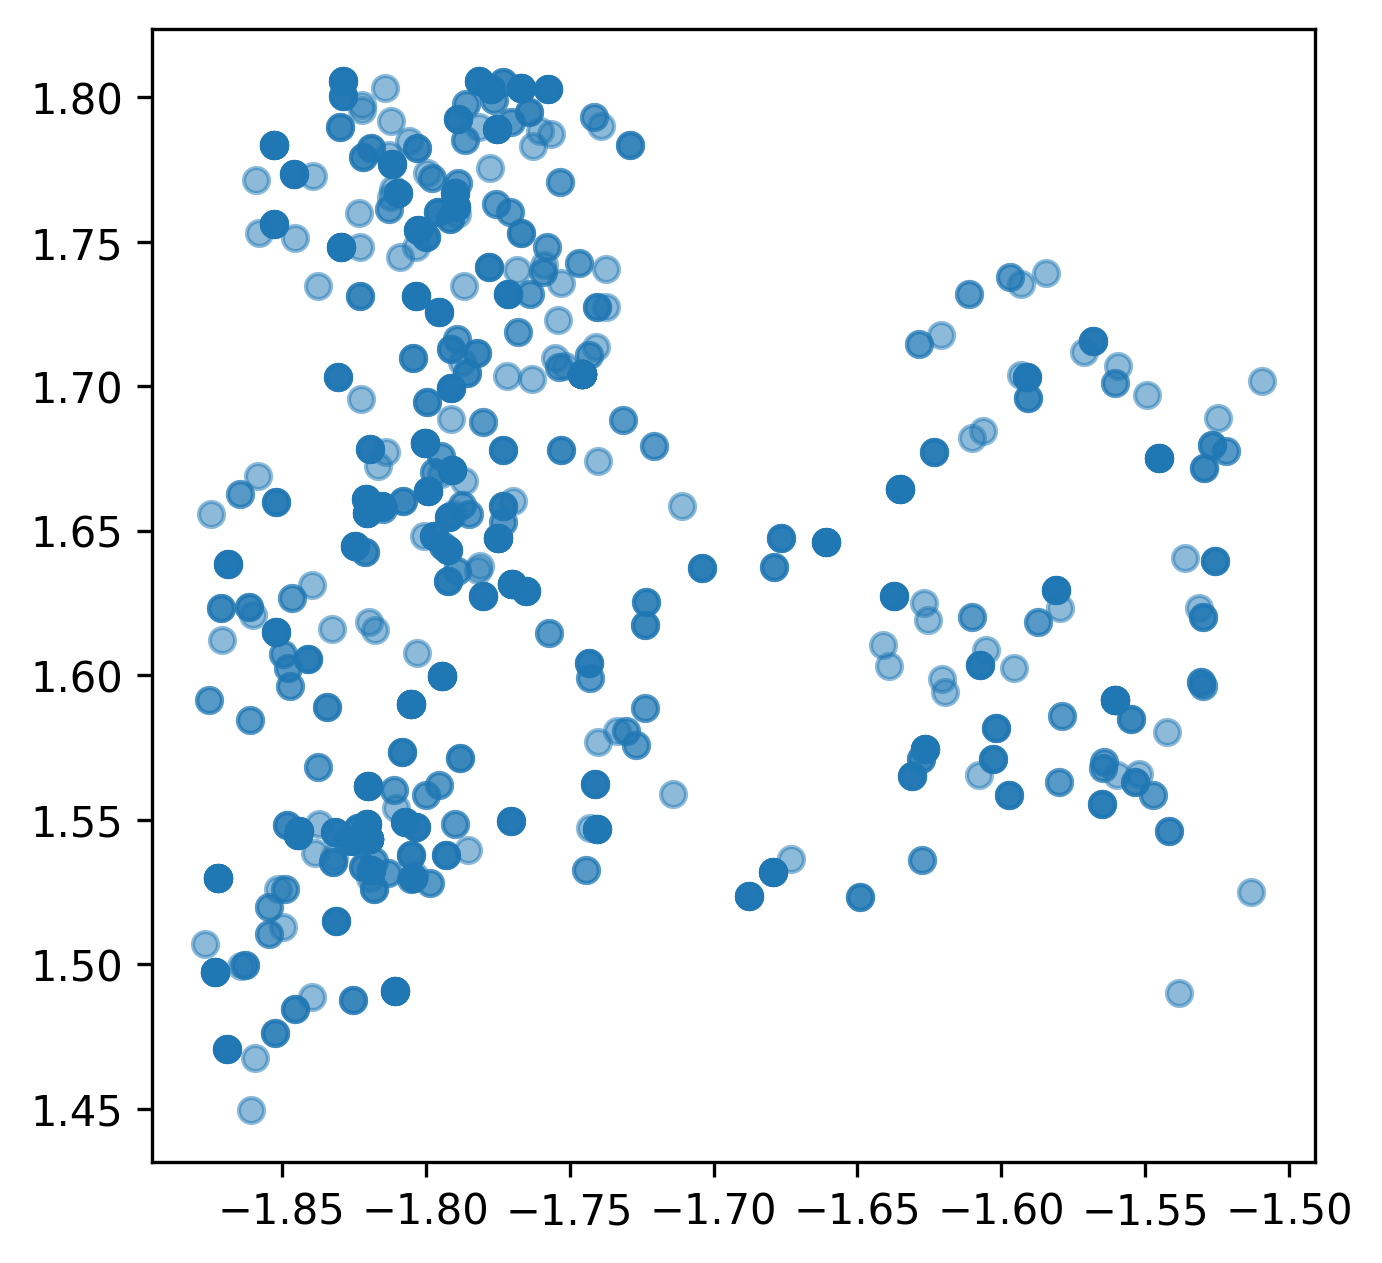

In [132]:
plt.figure(figsize=[5,5])
plt.scatter(states[1000:2000,20],states[1000:2000,52],alpha=0.5)

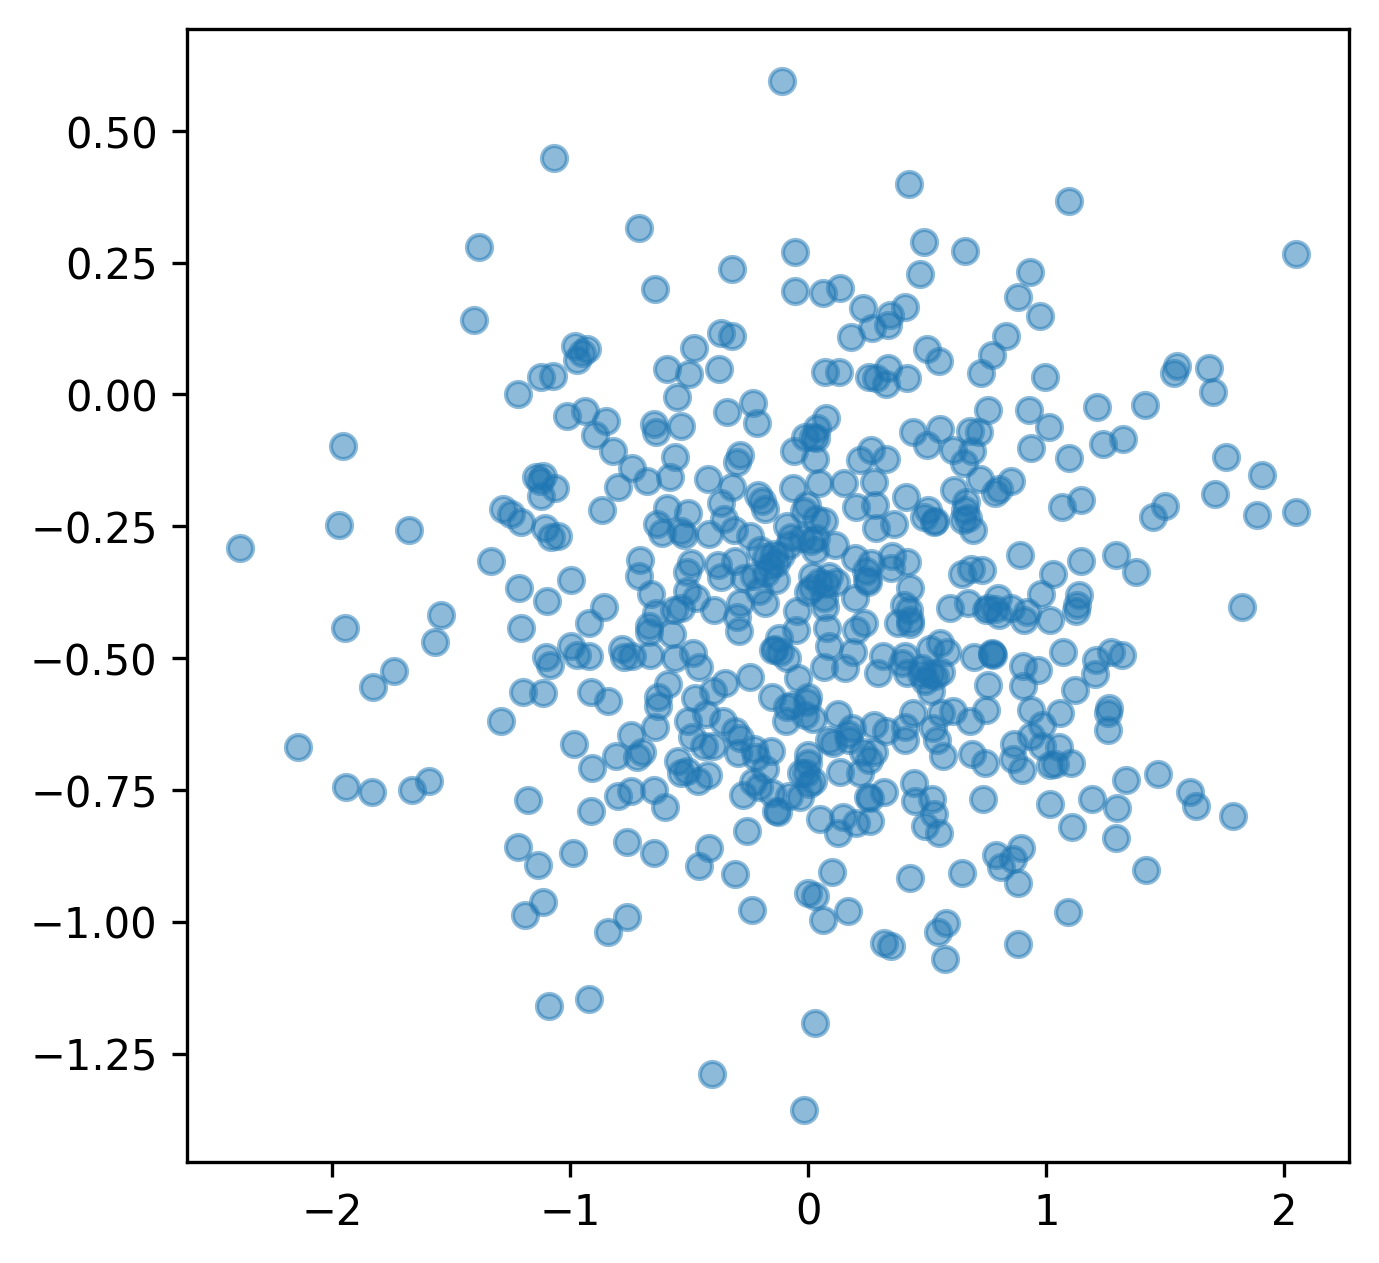

In [138]:
plt.figure(figsize=[5,5])
plt.scatter(z[:,35],z[:,54],alpha=0.5)

## Location as parameters

In [58]:
#First we import some dependencies
from tensorflow_probability.substrates import jax as tfp
@jax.jit
def blending(z1, z2, x1,x2):
    x1=jnp.int32(x1)
    x2=jnp.int32(x2)
    im1, _ = generative_model.apply(params, state, z1)
    im2, _ = generative_model.apply(params, state, z2)
    im_hsc1 = simulate_hsc(im1[0], cosmos1['psf'], hsc['psf'])
    im_hsc2 = simulate_hsc(im2[0], cosmos2['psf'], hsc['psf'])
    im_hsc2 = jnp.roll(jnp.roll(im_hsc2, x1, axis=1), x2, axis=0)
    im_blended = im_hsc1 + im_hsc2
    likelihood = tfd.Independent(tfd.Normal(loc=im_blended,
                                        scale=jnp.sqrt(hsc['variance'])), 
                             reinterpreted_batch_ndims=2) 
    return likelihood.mean()

@jax.jit
def log_probz(z):
    x=blending(z[0:32],z[32:64],z[64],z[65])
    prior=tfd.Independent(tfd.Normal(jnp.zeros(64), jnp.zeros(64)+1), # We add a high noise component in mask
                             reinterpreted_batch_ndims=1)
    likelihood = tfd.Independent(tfd.Normal(x,
                                            jnp.sqrt(hsc['variance'] + cr_mask*1e3)), # We add a high noise component in mask
                             reinterpreted_batch_ndims=2)
    return likelihood.log_prob(y_obs)+prior.log_prob(z[0:64])



#The log probability function we use is still the one we use before
step_size=jnp.concatenate((jnp.ones(64)*1e-3,jnp.ones(2)*0.3))

num_results = int(2*1e3)
num_burnin_steps = int(2e4)
kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_probz,
    num_leapfrog_steps=2,
    step_size=step_size)
#kernel = tfp.mcmc.SimpleStepSizeAdaptation(
#    inner_kernel=kernel, num_adaptation_steps=int(num_burnin_steps * 0.8))

In [59]:
#define a initial state
z_mc = tfd.MultivariateNormalDiag(jnp.zeros(66), scale_identity_multiplier=1).sample(4, seed=next(rng_seq))

print(shape(z_mc))

#define function running

def run_chain():
  # Run the chain (with burn-in).
  return tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=z_mc[0],
      kernel=kernel,
      trace_fn=lambda _,results: results,seed=random.PRNGKey(0))

 

(4, 66)


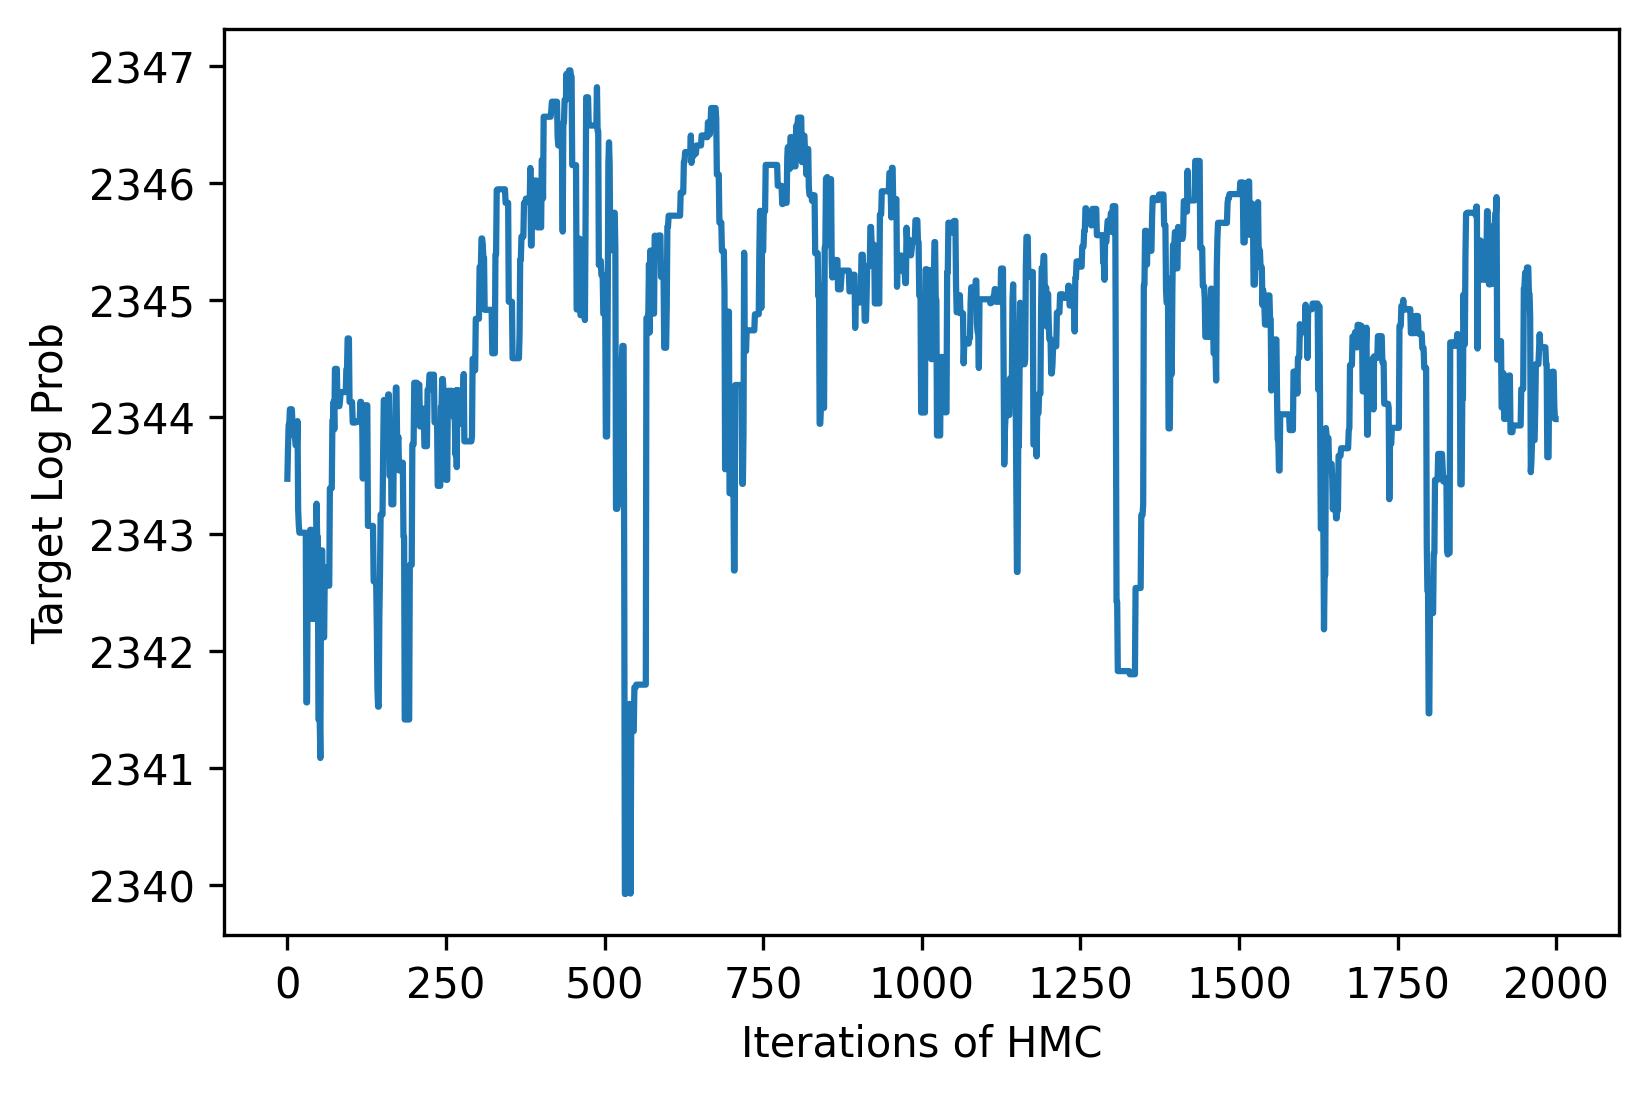

CPU times: user 3min 12s, sys: 614 ms, total: 3min 13s
Wall time: 2min 51s


In [60]:
%%time
states, log_probs= run_chain()

plt.figure()
plt.plot(log_probs.accepted_results.target_log_prob)
plt.ylabel('Target Log Prob')
plt.xlabel('Iterations of HMC')
plt.show()

In [64]:
states[2000]

DeviceArray([ 0.12748785,  0.51687783,  0.78731304,  0.57657504,
              0.5211786 ,  1.0444752 , -0.37021756, -0.8083456 ,
             -1.7072042 ,  2.3980513 , -0.6086608 , -0.5494508 ,
              0.5852578 , -0.92676985,  0.23593707,  0.8657092 ,
             -1.325623  ,  0.12903045, -0.20649943,  2.412393  ,
              1.1731927 ,  1.8811316 ,  0.36279944,  1.8084507 ,
              1.2408057 , -0.42902908, -0.3627929 ,  1.210622  ,
             -0.11221656,  0.72395974,  0.6010426 , -0.38664004,
              1.2133101 ,  0.37332746, -1.6944488 ,  1.549208  ,
              0.44535658,  0.9389901 ,  0.32400736,  0.67243385,
             -0.74437475, -1.2653519 , -1.4856293 ,  1.070681  ,
             -0.8161446 ,  0.86527777, -0.85192204,  2.0219853 ,
             -1.2167617 , -0.8543684 ,  1.6795458 , -2.9119987 ,
             -1.7351638 ,  1.553724  , -0.19076915,  0.21518885,
             -0.9868401 ,  0.92346156, -1.1649828 ,  1.2340202 ,
              0.04336711,

Text(0.5, 1.0, 'Residuals')

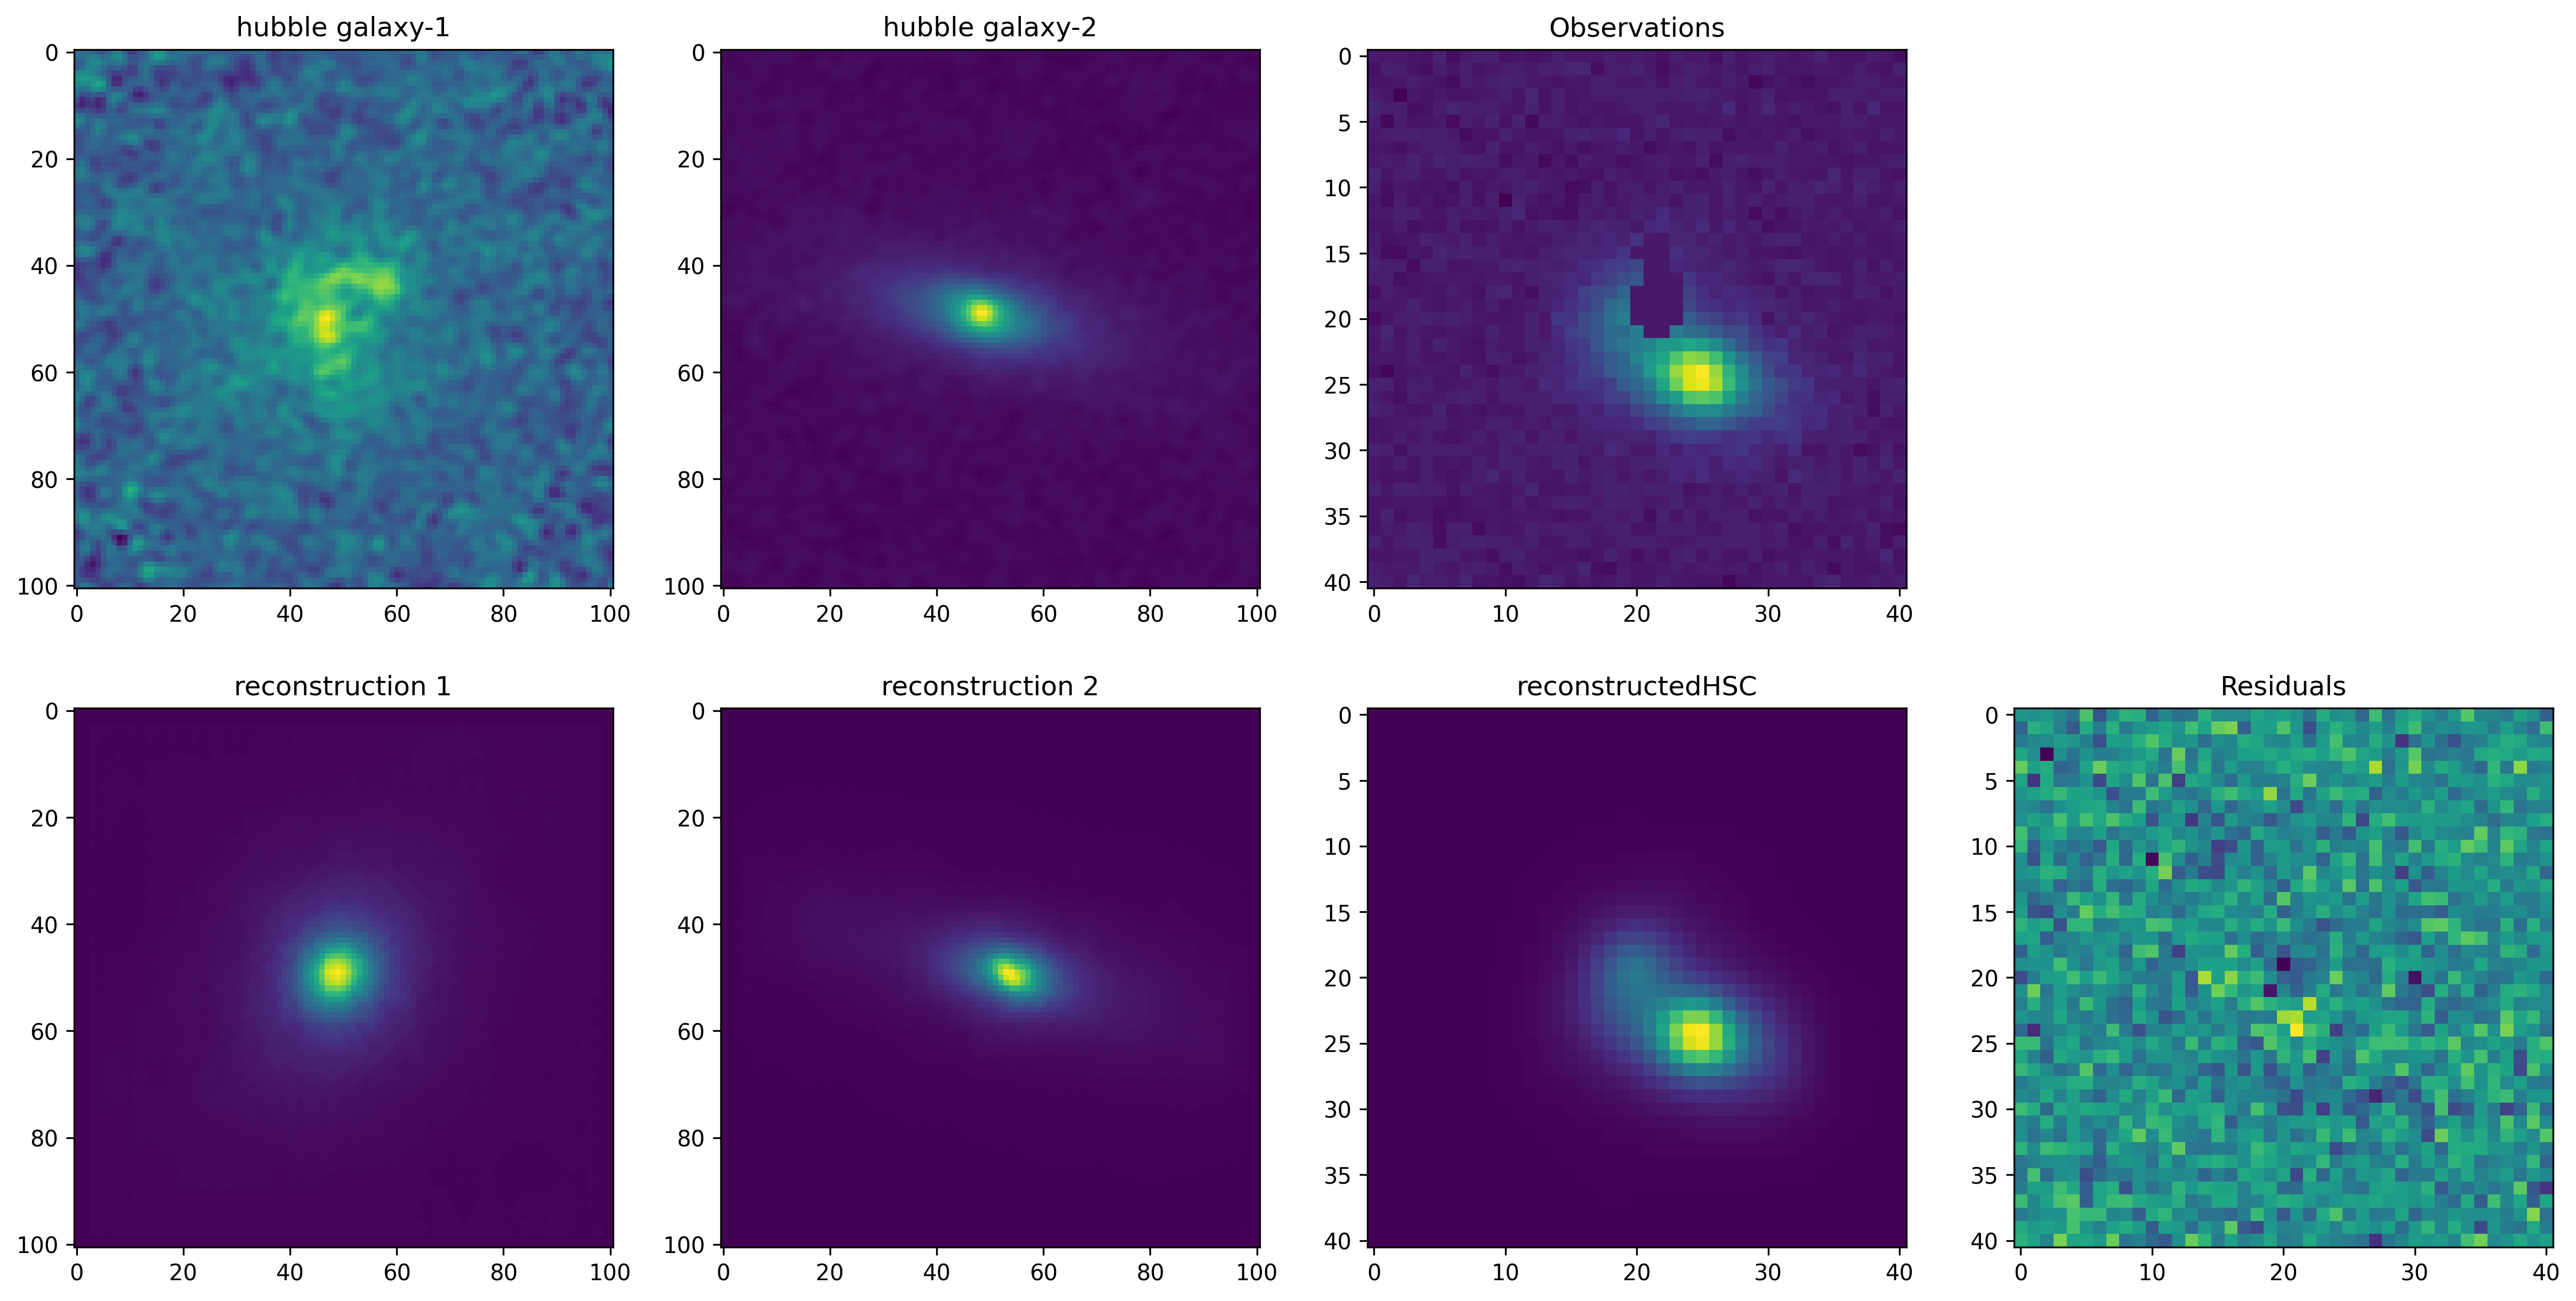

In [65]:
z=jnp.mean(states,axis=0)
im1, _ = generative_model.apply(params, state, z[0:32])
im2, _ = generative_model.apply(params, state, z[32:64])
loc_x=z[64]
loc_y=z[65]
plt.rcParams['figure.dpi']=300
figure(figsize=[20,10])
subplot(241)
imshow(x1_true)
title('hubble galaxy-1')
subplot(242)
imshow(x2_true)
title('hubble galaxy-2')
subplot(243)
imshow(y_obs)
title('Observations')
subplot(245)
imshow(im1[0])
title('reconstruction 1')
subplot(246)
imshow(im2[0])
title('reconstruction 2')
subplot(247)
imshow(blending(z[0:32],z[32:64],loc_x,loc_y))
title('reconstructedHSC')
subplot(248)
imshow(im_noise-blending(z[0:32],z[32:64],loc_x,loc_y))
title('Residuals')

DeviceArray(5.4936304, dtype=float32)